#Importing Packages and Data

In [ ]:
# Data processing libraries
import gdown
import pandas as pd
import numpy as np
import sys
import time

# Just to ignore deprecation warning and stuffs
import warnings
warnings.filterwarnings('ignore')

# Progress bar on for loops
from tqdm import tqdm

# Visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns

# Error metric ready to use function
from sklearn.metrics import mean_squared_error as mse

# Utility functions for evaluating models
from sklearn.model_selection import (
    KFold,
    train_test_split as tts,
    cross_val_score as cvs,
    cross_val_predict as cvp,
)

# Zoo of models
from sklearn import ensemble, linear_model
import xgboost as xgb
import lightgbm as lgbm
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.metrics import mean_squared_error

!pip3 install catboost
import catboost as cb
from catboost import CatBoostRegressor

# Feature impact visualization
try:
  import shap
  from sklearn.inspection import permutation_importance
except:
  !pip3 install shap
  import shap
  from sklearn.inspection import permutation_importance

from statsmodels.tsa.statespace.sarimax import SARIMAX

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 9.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 532.9/532.9 kB 5.1 MB/s eta 0:00:00


In [ ]:
#Download Data Drive

url_train = "https://drive.google.com/uc?id=1z2A7TNHutbRa5dleDCF8Xu0sUfVnijIr"

path_train = '/content/data_train.csv'

url_test = "https://drive.google.com/uc?id=1ITxTokWQY-g4EhgXVi3kLwpWjITTinob"

path_test = '/content/data_test.csv'

try:
  df_train = pd.read_csv(path_train)
  df_test = pd.read_csv(path_test)

except:
  gdown.download(url_train, path_train, quiet=False)
  gdown.download(url_test, path_test, quiet=False)
  df_train = pd.read_csv(path_train)
  df_test = pd.read_csv(path_test)

Downloading...
From: https://drive.google.com/uc?id=1z2A7TNHutbRa5dleDCF8Xu0sUfVnijIr
To: /content/data_train.csv
100%|██████████| 2.34M/2.34M [00:00<00:00, 97.9MB/s]
Downloading...
From: https://drive.google.com/uc?id=1ITxTokWQY-g4EhgXVi3kLwpWjITTinob
To: /content/data_test.csv
100%|██████████| 1.10M/1.10M [00:00<00:00, 122MB/s]


---
#**Below is the EDA Zone, Beware of Wild Animals**
---



#Pre-Processing (Fav)

##Tis a Function

###Box Plot Function

In [ ]:
def box_plot_cat(df, x_value, y_value=None, rot=0, show_mean_lines_mean=False, show_mean_lines_upper=False, show_mean_font=False, line_color='r', title: str = None):
    sns.set(style="whitegrid")

    '''
    Berguna untuk membuat box plot 1 atau 2 dimensi.


    df untuk dataframe yang akan digunakan untuk plot.
    x_value untuk nama kolom numerik yang akan digunakan untuk box plot pada 1 dimensi atau kategorik di x-axis untuk 2 dimensi.
    y_value untuk nama kolom numerik yang akan digunakan untuk box plot pada 2 dimensi.
    rot untuk rotation dari label x.
    show_mean_lines_mean memberikan pilihan menampilkan mean dari setiap box plot.
    show_mean_lines_upper memberikan pilihan menampilkan mean+2std (indikator outlier) pada setiap box plot.
    '''

    if y_value:
        # Create the box plot
        ax = sns.boxplot(data=df, x=x_value, y=y_value)

        # Wider Plot
        plt.gcf().set_size_inches(12, 6)

        # Rotation of x-labels
        plt.xticks(rotation=rot)

        if show_mean_lines_mean:
            # Calculate means for each category
            means = df.groupby(x_value)[y_value].mean()
            x_labels = df[x_value].unique()
            for x, label in enumerate(ax.get_xticklabels()):
                category = label.get_text()
                y = means[category]

                # Add horizontal line for the mean in the corresponding box plot
                ax.axhline(y=y, color=line_color, linestyle='--', lw=2, xmin=x/len(x_labels), xmax=(x+1)/len(x_labels))

        if show_mean_lines_upper:
            # Calculate means for each category
            means = df.groupby(x_value)[y_value].mean()
            x_labels = df[x_value].unique()
            for x, label in enumerate(ax.get_xticklabels()):
                category = label.get_text()
                y = means[category]

                # Calculate upper mean + 2s
                upper_mean = y + 2 * df.groupby(x_value)[y_value].std()[category]

                # Add horizontal line for upper mean + 2s in the corresponding box plot
                ax.axhline(y=upper_mean, color=line_color, linestyle='--', lw=2, xmin=x/len(x_labels), xmax=(x+1)/len(x_labels))

        if show_mean_font:
            # Calculate means for each category
            means = df.groupby(x_value)[y_value].mean()
            x_labels = df[x_value].unique()
            for x, label in enumerate(ax.get_xticklabels()):
                category = label.get_text()
                y = means[category]

                # Display the mean value at the very top
                plt.text(x, max(df[y_value]) + 0.02, f'{y:.2f}', ha='center', va='bottom', color=line_color, fontsize=10)

        # Show the plot
        plt.title(title)
        plt.show()

    else:
        ax = sns.boxplot(data=df, x=x_value)

        # Calculate the mean and std
        mean = df[x_value].mean()
        std = df[x_value].std()

        # Wider Plot
        plt.gcf().set_size_inches(12, 6)

        # Rotation of x-labels
        plt.xticks(rotation=rot)

        # Calculate the outlier cutoff
        cutoff = mean + 2 * std

        # Count the number of outliers
        outliers_count = (df[x_value] > cutoff).sum()

        # Print the number of outliers
        print(f'Number of outliers above Mean + 2s: {outliers_count}')

        if show_mean_lines_mean:
            # Add vertical line for the mean
            ax.axvline(x=mean, color=line_color, linestyle='--', label=f'Mean', lw=2)

        if show_mean_lines_upper:
            # Calculate upper mean + 2s
            upper_mean = mean + 2 * std

            # Calculate the position for the vertical line
            x_position = upper_mean  # Center of the box plot

            # Add vertical line for upper mean + 2s
            ax.axvline(x=x_position, color=line_color, linestyle='--', lw=2)

        # Add a title
        plt.title(title)

        # Add a legend
        plt.legend()

        # Show the plot
        plt.show()

##Inspecting the Data

In [ ]:
df_train.shape

(20355, 15)

In [ ]:
df_train.dtypes

timestamp         object
api_calls        float64
clouds           float64
distance_max     float64
distance_mean    float64
distance_min     float64
humidity         float64
price_mean       float64
rain             float64
surge_max        float64
surge_mean       float64
surge_min        float64
temp             float64
wind             float64
type               int64
dtype: object

In [ ]:
df_train.head()

timestamp  api_calls    clouds  distance_max  distance_mean  \
0  2018-11-26 06:00:00        9.0  0.990667          3.03       1.726667   
1  2018-11-26 07:00:00       10.0  0.970000          2.67       1.690000   
2  2018-11-26 08:00:00        1.0  0.980000          1.38       1.380000   
3  2018-11-26 09:00:00       11.0  1.000000          3.08       1.920909   
4  2018-11-26 10:00:00       12.0  0.995000          3.01       2.122500   

   distance_min  humidity  price_mean  rain  surge_max  surge_mean  surge_min  \
0          1.04  0.913333   16.555556   0.0       1.50    1.055556        1.0   
1          1.09  0.920000   17.300000   0.0       2.00    1.100000        1.0   
2          1.38  0.923333   13.500000   0.0       1.00    1.000000        1.0   
3          1.39  0.927500   17.954545   0.0       1.75    1.113636        1.0   
4          1.07  0.940000   18.625000   0.0       1.50    1.083333        1.0   

        temp      wind  type  
0  40.627333  1.350667     0  
1  41.137500  1.735000     0  
2  40.920000  1.330000     0  
3  40.937500  1.365000     0  
4  40.695000  1.895000     0

In [ ]:
df_train['surge_min'].unique()

array([1.  , 1.5 , 1.25])

In [ ]:
df_train.isna().sum()

timestamp          0
api_calls          0
clouds           192
distance_max       0
distance_mean      0
distance_min       0
humidity         192
price_mean         0
rain             192
surge_max          0
surge_mean         0
surge_min          0
temp             192
wind             192
type               0
dtype: int64

In [ ]:
df_test

index            timestamp  api_calls  clouds  distance_max  \
0          0  2018-12-14 00:00:00       13.0    0.69          3.02   
1          1  2018-12-14 01:00:00       14.0    0.77          2.34   
2          2  2018-12-14 02:00:00       13.0    0.59          3.00   
3          3  2018-12-14 03:00:00       12.0    0.68          3.14   
4          4  2018-12-14 04:00:00        7.0    0.72          2.41   
...      ...                  ...        ...     ...           ...   
11035  11035  2018-12-18 14:00:00       11.0    0.48          3.08   
11036  11036  2018-12-18 15:00:00       16.0    0.34          3.20   
11037  11037  2018-12-18 16:00:00        7.0    0.31          3.08   
11038  11038  2018-12-18 17:00:00        8.0    0.15          3.20   
11039  11039  2018-12-18 18:00:00        9.0    0.00          3.15   

       distance_mean  distance_min  humidity  rain  surge_max  surge_mean  \
0           1.980000          1.06      0.68   0.0       2.00    1.115385   
1           1.541429          1.04      0.68   0.0       1.00    1.000000   
2           2.010769          1.08      0.69   0.0       1.50    1.096154   
3           1.860833          1.06      0.70   0.0       1.25    1.020833   
4           1.634286          1.06      0.71   0.0       1.25    1.035714   
...              ...           ...       ...   ...        ...         ...   
11035       2.024545          0.72      0.47   0.0       1.00    1.000000   
11036       2.002500          0.72      0.46   0.0       1.00    1.000000   
11037       2.105714          0.72      0.47   0.0       1.00    1.000000   
11038       1.952500          0.72      0.46   0.0       1.00    1.000000   
11039       2.721111          1.06      0.46   0.0       1.00    1.000000   

       surge_min   temp   wind  type  
0            1.0  29.93   1.99     0  
1            1.0  30.19   2.35     0  
2            1.0  30.02   1.98     0  
3            1.0  29.89   1.92     0  
4            1.0  29.92   1.58     0  
...          ...    ...    ...   ...  
11035        1.0  26.19  13.89    95  
11036        1.0  27.22  15.03    95  
11037        1.0  28.70  14.60    95  
11038        1.0  30.05  13.55    95  
11039        1.0  30.79  13.09    95  

[11040 rows x 15 columns]

In [ ]:
print(df_test.columns)
print(df_train.columns)

Index(['index', 'timestamp', 'api_calls', 'clouds', 'distance_max',
       'distance_mean', 'distance_min', 'humidity', 'rain', 'surge_max',
       'surge_mean', 'surge_min', 'temp', 'wind', 'type'],
      dtype='object')
Index(['timestamp', 'api_calls', 'clouds', 'distance_max', 'distance_mean',
       'distance_min', 'humidity', 'price_mean', 'rain', 'surge_max',
       'surge_mean', 'surge_min', 'temp', 'wind', 'type'],
      dtype='object')


In [ ]:
df_merged = pd.concat([df_train,df_test])

In [ ]:
df_merged

timestamp  api_calls    clouds  distance_max  distance_mean  \
0      2018-11-26 06:00:00        9.0  0.990667          3.03       1.726667   
1      2018-11-26 07:00:00       10.0  0.970000          2.67       1.690000   
2      2018-11-26 08:00:00        1.0  0.980000          1.38       1.380000   
3      2018-11-26 09:00:00       11.0  1.000000          3.08       1.920909   
4      2018-11-26 10:00:00       12.0  0.995000          3.01       2.122500   
...                    ...        ...       ...           ...            ...   
11035  2018-12-18 14:00:00       11.0  0.480000          3.08       2.024545   
11036  2018-12-18 15:00:00       16.0  0.340000          3.20       2.002500   
11037  2018-12-18 16:00:00        7.0  0.310000          3.08       2.105714   
11038  2018-12-18 17:00:00        8.0  0.150000          3.20       1.952500   
11039  2018-12-18 18:00:00        9.0  0.000000          3.15       2.721111   

       distance_min  humidity  price_mean  rain  surge_max  surge_mean  \
0              1.04  0.913333   16.555556   0.0       1.50    1.055556   
1              1.09  0.920000   17.300000   0.0       2.00    1.100000   
2              1.38  0.923333   13.500000   0.0       1.00    1.000000   
3              1.39  0.927500   17.954545   0.0       1.75    1.113636   
4              1.07  0.940000   18.625000   0.0       1.50    1.083333   
...             ...       ...         ...   ...        ...         ...   
11035          0.72  0.470000         NaN   0.0       1.00    1.000000   
11036          0.72  0.460000         NaN   0.0       1.00    1.000000   
11037          0.72  0.470000         NaN   0.0       1.00    1.000000   
11038          0.72  0.460000         NaN   0.0       1.00    1.000000   
11039          1.06  0.460000         NaN   0.0       1.00    1.000000   

       surge_min       temp       wind  type    index  
0            1.0  40.627333   1.350667     0      NaN  
1            1.0  41.137500   1.735000     0      NaN  
2            1.0  40.920000   1.330000     0      NaN  
3            1.0  40.937500   1.365000     0      NaN  
4            1.0  40.695000   1.895000     0      NaN  
...          ...        ...        ...   ...      ...  
11035        1.0  26.190000  13.890000    95  11035.0  
11036        1.0  27.220000  15.030000    95  11036.0  
11037        1.0  28.700000  14.600000    95  11037.0  
11038        1.0  30.050000  13.550000    95  11038.0  
11039        1.0  30.790000  13.090000    95  11039.0  

[31395 rows x 16 columns]

##Data Types

In [ ]:
df_train['timestamp'] = pd.to_datetime(df_train['timestamp'])

In [ ]:
df_merged['timestamp'] = pd.to_datetime(df_merged['timestamp'])
df_merged['type'] = df_merged['type'].astype('category')

In [ ]:
df_test['timestamp'] = pd.to_datetime(df_test['timestamp'])
df_test['type'] = df_test['type'].astype('category')

##Simple Linear Correlation Between Numerical Variables

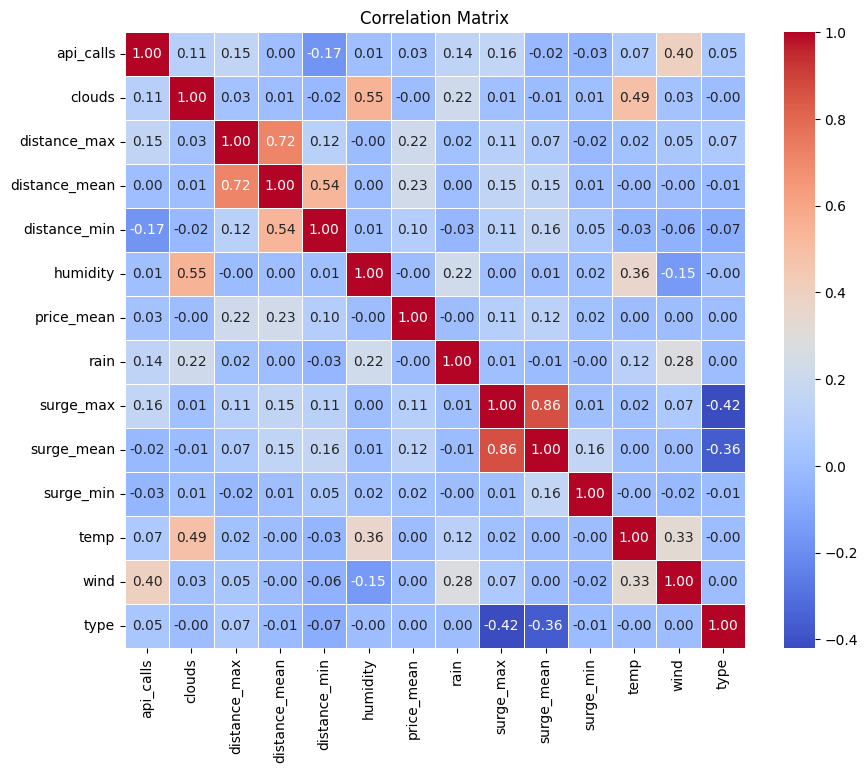

In [ ]:
# Create a heatmap of the correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(df_train.corr(), annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Correlation Matrix")
plt.show()

##Columns for Date

In [ ]:
df_train['year'] = df_train['timestamp'].dt.year

df_train['month'] = df_train['timestamp'].dt.month

df_train['day'] = df_train['timestamp'].dt.day

df_train['hour'] = df_train['timestamp'].dt.hour

df_train['day_of_week'] = df_train['timestamp'].dt.dayofweek + 1

In [ ]:
df_test['year'] = df_test['timestamp'].dt.year

df_test['month'] = df_test['timestamp'].dt.month

df_test['day'] = df_test['timestamp'].dt.day

df_test['hour'] = df_test['timestamp'].dt.hour

df_test['day_of_week'] = df_test['timestamp'].dt.dayofweek + 1

In [ ]:
df_train.head()

timestamp  api_calls    clouds  distance_max  distance_mean  \
0 2018-11-26 06:00:00        9.0  0.990667          3.03       1.726667   
1 2018-11-26 07:00:00       10.0  0.970000          2.67       1.690000   
2 2018-11-26 08:00:00        1.0  0.980000          1.38       1.380000   
3 2018-11-26 09:00:00       11.0  1.000000          3.08       1.920909   
4 2018-11-26 10:00:00       12.0  0.995000          3.01       2.122500   

   distance_min  humidity  price_mean  rain  surge_max  surge_mean  surge_min  \
0          1.04  0.913333   16.555556   0.0       1.50    1.055556        1.0   
1          1.09  0.920000   17.300000   0.0       2.00    1.100000        1.0   
2          1.38  0.923333   13.500000   0.0       1.00    1.000000        1.0   
3          1.39  0.927500   17.954545   0.0       1.75    1.113636        1.0   
4          1.07  0.940000   18.625000   0.0       1.50    1.083333        1.0   

        temp      wind  type  year  month  day  hour  day_of_week  
0  40.627333  1.350667     0  2018     11   26     6            1  
1  41.137500  1.735000     0  2018     11   26     7            1  
2  40.920000  1.330000     0  2018     11   26     8            1  
3  40.937500  1.365000     0  2018     11   26     9            1  
4  40.695000  1.895000     0  2018     11   26    10            1

In [ ]:
df_train['day_of_week'].unique()

array([1, 2, 3, 4, 5, 6, 7])

In [ ]:
df_train['year'].unique()

array([2018])

In [ ]:
df_train['month'].unique()

array([11, 12])

In [ ]:
df_train['day'].unique()

array([26, 27, 28, 29, 30,  1,  2,  3,  4,  9, 10, 13])

In [ ]:
df_train['hour'].unique()

array([ 6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22,
       23,  0,  1,  2,  3,  4,  5])

In [ ]:
df_train.drop(['year'], axis=1, inplace=True)

In [ ]:
df_train.head(1)

timestamp  api_calls    clouds  distance_max  distance_mean  \
0 2018-11-26 06:00:00        9.0  0.990667          3.03       1.726667   

   distance_min  humidity  price_mean  rain  surge_max  surge_mean  surge_min  \
0          1.04  0.913333   16.555556   0.0        1.5    1.055556        1.0   

        temp      wind  type  month  day  hour  day_of_week  
0  40.627333  1.350667     0     11   26     6            1

##Visualization for Distribution, Trends, and Tendency

###Distribution

<Figure size 900x800 with 0 Axes>

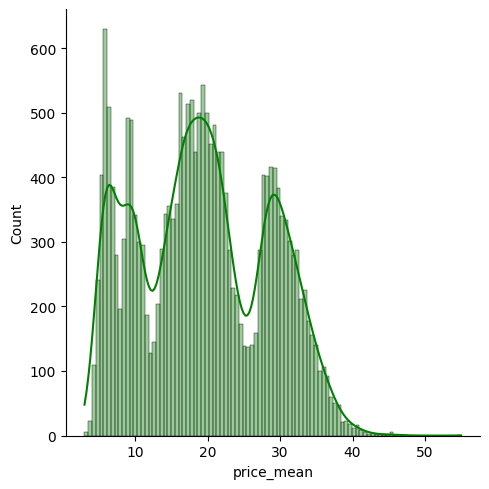

In [ ]:
plt.figure(figsize=(9, 8))
sns.displot(df_train['price_mean'], color='g', bins=100, alpha=0.4, kde=True);

In [ ]:
#df_num = df_train.select_dtypes(include = ['float64', 'int64'])
#df_num.hist(figsize=(16, 20), bins=50, xlabelsize=8, ylabelsize=8);

###Trends

####Trend of Time

#####Outlier

In [ ]:
#plt.figure(figsize=(20, 8))
#sns.lineplot(x=df_train['timestamp'], y=df_train['price_mean'], color='red', marker='o')
#plt.xticks(rotation=45)
#plt.show()

In [ ]:
df_train.nsmallest(10, 'price_mean')

timestamp  api_calls    clouds  distance_max  distance_mean  \
12980 2018-11-28 07:00:00        1.0  0.240769          1.28       1.280000   
13362 2018-11-26 08:00:00        1.0  0.986667          1.43       1.430000   
14041 2018-11-28 01:00:00        4.0       NaN          1.85       1.370000   
13967 2018-12-04 01:00:00        6.0  0.040000          2.38       1.171667   
13404 2018-11-28 08:00:00        1.0  0.521667          4.35       4.350000   
14824 2018-12-10 01:00:00        1.0  0.220000          0.69       0.690000   
13983 2018-12-13 09:00:00        6.0  0.390000          1.93       1.113333   
13829 2018-11-28 07:00:00        4.0  0.240000          1.20       0.687500   
13943 2018-12-03 01:00:00       11.0  0.990000          1.36       1.081818   
13985 2018-12-13 11:00:00        7.0  0.450000          2.38       1.204286   

       distance_min  humidity  price_mean  rain  surge_max  surge_mean  \
12980          1.28  0.795385    3.000000   0.0        1.0         1.0   
13362          1.43  0.933333    3.000000   0.0        1.0         1.0   
14041          1.14       NaN    3.375000   NaN        1.0         1.0   
13967          0.69  0.600000    3.416667   0.0        1.0         1.0   
13404          4.35  0.801667    3.500000   0.0        1.0         1.0   
14824          0.69  0.610000    3.500000   0.0        1.0         1.0   
13983          0.54  0.640000    3.583333   0.0        1.0         1.0   
13829          0.42  0.793846    3.625000   0.0        1.0         1.0   
13943          0.64  0.930000    3.636364   0.0        1.0         1.0   
13985          0.68  0.630000    3.642857   0.0        1.0         1.0   

       surge_min       temp      wind  type  month  day  hour  day_of_week  
12980        1.0  34.936923  6.332308    61     11   28     7            3  
13362        1.0  40.723333  1.313333    63     11   26     8            1  
14041        1.0        NaN       NaN    66     11   28     1            3  
13967        1.0  45.720000  7.860000    65     12    4     1            2  
13404        1.0  34.526667  5.526667    63     11   28     8            3  
14824        1.0  27.750000  4.340000    69     12   10     1            1  
13983        1.0  20.060000  3.920000    65     12   13     9            4  
13829        1.0  34.995385  6.379231    65     11   28     7            3  
13943        1.0  47.750000  1.890000    65     12    3     1            1  
13985        1.0  20.260000  2.900000    65     12   13    11            4

In [ ]:
df_train[(df_train['day']==10) & (df_train['month']==12)].sample(10)

timestamp  api_calls  clouds  distance_max  distance_mean  \
4856  2018-12-10 00:00:00        5.0  0.1100          3.15       1.568000   
8248  2018-12-10 01:00:00        2.0  0.2000          3.47       2.495000   
11851 2018-12-10 00:00:00        4.0  0.1100          3.14       2.140000   
12277 2018-12-10 02:00:00       10.0  0.2700          2.59       1.430000   
18430 2018-12-10 02:00:00        8.0  0.2625          4.74       3.532500   
8671  2018-12-10 00:00:00        1.0  0.1100          1.01       1.010000   
1674  2018-12-10 00:00:00        4.0  0.1100          3.14       2.375000   
15249 2018-12-10 01:00:00        2.0  0.2200          2.86       2.005000   
4008  2018-12-10 02:00:00       12.0  0.2700          2.90       1.576667   
2525  2018-12-10 01:00:00        1.0  0.2200          1.07       1.070000   

       distance_min  humidity  price_mean  rain  surge_max  surge_mean  \
4856           0.61    0.5800   21.700000   0.0       1.25       1.050   
8248           1.52    0.5800   10.000000   0.0       1.00       1.000   
11851          1.11    0.5800   13.625000   0.0       1.00       1.000   
12277          0.59    0.6000   13.350000   0.0       1.50       1.075   
18430          2.80    0.5950   36.250000   0.0       1.00       1.000   
8671           1.01    0.6100    7.000000   0.0       1.00       1.000   
1674           1.05    0.5800   22.000000   0.0       2.00       1.250   
15249          1.15    0.5800    5.250000   0.0       1.00       1.000   
4008           1.01    0.5975   19.666667   0.0       1.00       1.000   
2525           1.07    0.5800   13.500000   0.0       1.00       1.000   

       surge_min     temp  wind  type  month  day  hour  day_of_week  
4856         1.0  30.1300  5.15    22     12   10     0            1  
8248         1.0  29.2700  4.14    38     12   10     1            1  
11851        1.0  30.1800  5.15    55     12   10     0            1  
12277        1.0  28.8675  5.18    57     12   10     2            1  
18430        1.0  28.8700  5.00    86     12   10     2            1  
8671         1.0  28.8000  5.18    40     12   10     0            1  
1674         1.0  30.1800  5.15     7     12   10     0            1  
15249        1.0  29.2100  4.32    71     12   10     1            1  
4008         1.0  28.8750  5.20    18     12   10     2            1  
2525         1.0  29.2100  4.32    11     12   10     1            1

Number of outliers above Mean + 2s: 1


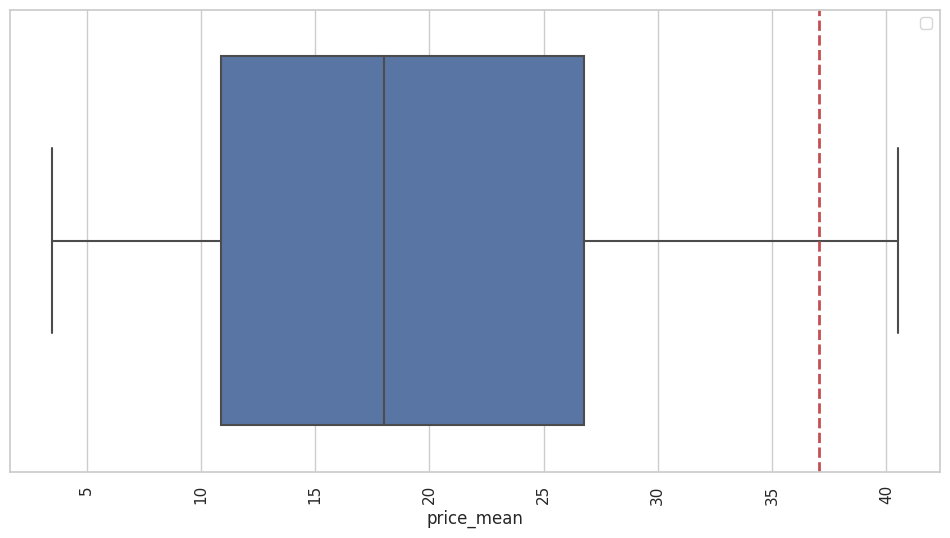

In [ ]:
box_plot_cat(df=df_train[(df_train['day']==10) & (df_train['month']==12)], x_value='price_mean', rot=90, show_mean_lines_upper=True)

<Axes: xlabel='hour', ylabel='price_mean'>

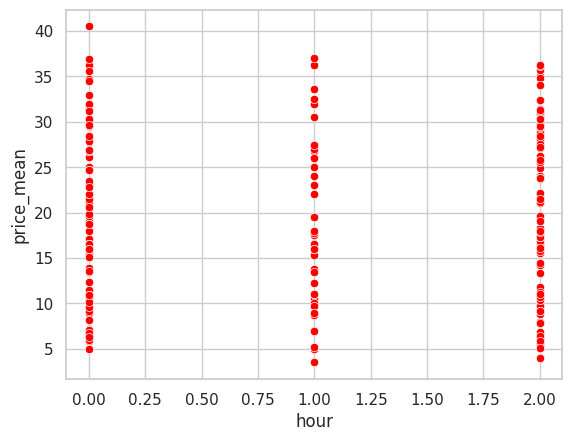

In [ ]:
sns.scatterplot(x=df_train[(df_train['day']==10) & (df_train['month']==12)]['hour'], y=df_train['price_mean'], color='red')

In [ ]:
df_train[(df_train['day']==10) & (df_train['month']==12)]['hour']

189      0
190      2
401      0
402      1
403      2
        ..
20121    1
20122    2
20331    0
20332    1
20333    2
Name: hour, Length: 253, dtype: int64

In [ ]:
df_train.shape

(20355, 19)

----
GTW MAU APUS OUTLIER ATO GAK

In [ ]:
df_train = df_train[(df_train['day']!=10) | (df_train['month']!=12)]
df_train.shape

(20102, 19)

In [ ]:
'''
plt.figure(figsize=(20, 8))
sns.lineplot(x=df_train['timestamp'], y=df_train['price_mean'], color='red', marker='o')
plt.xticks(rotation=45)
plt.show()

'''

"\nplt.figure(figsize=(20, 8))\nsns.lineplot(x=df_train['timestamp'], y=df_train['price_mean'], color='red', marker='o')\nplt.xticks(rotation=45)\nplt.show()\n\n"

In [ ]:
df_train['day'].unique()

array([26, 27, 28, 29, 30,  1,  2,  3,  4,  9, 13])

In [ ]:
df_test['day'].unique()

array([14, 15, 16, 17, 18])

<Axes: xlabel='hour', ylabel='price_mean'>

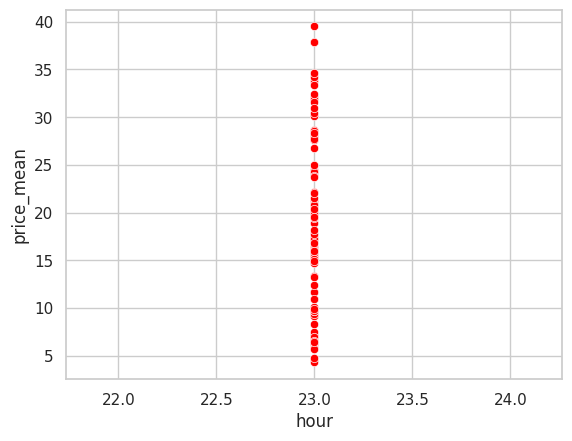

In [ ]:
sns.scatterplot(x=df_train[(df_train['day']==9) & (df_train['month']==12)]['hour'], y=df_train['price_mean'], color='red')

In [ ]:
df_train = df_train[(df_train['day']!=9) | (df_train['month']!=12)]
df_train.shape

(20006, 19)

#####Other

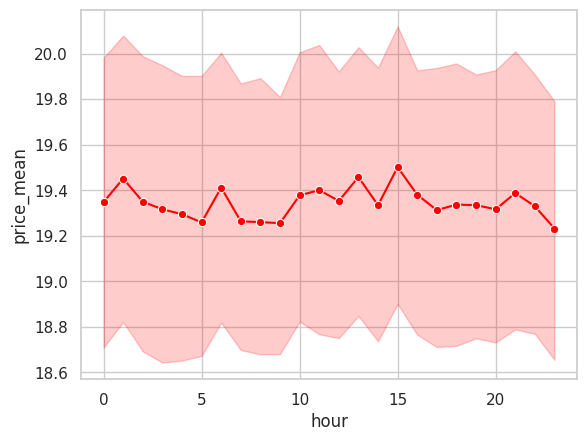

In [ ]:
sns.lineplot(x=df_train['hour'], y=df_train['price_mean'], color='red', marker='o')
plt.show()

In [ ]:
#sns.lineplot(x=df_train['day'], y=df_train['price_mean'], color='red', marker='o')
#plt.show()

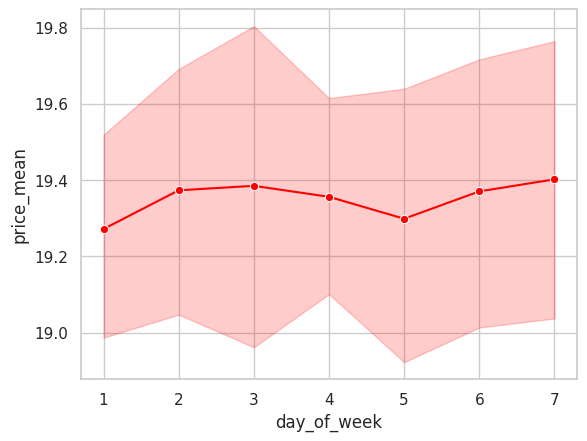

In [ ]:
sns.lineplot(x=df_train['day_of_week'], y=df_train['price_mean'], color='red', marker='o')
plt.show()

In [ ]:
#sns.lineplot(x=df_train['month'], y=df_train['price_mean'], color='red', marker='o')
#plt.show()

---
Cuma 2 Bulan Ternyata 😥

####Trend of Distance

In [ ]:
#sns.scatterplot(x=df_train['distance_mean'], y=df_train['price_mean'], color='red')
#plt.show()

---
Harusnya ini paling relevan?

In [ ]:
#sns.scatterplot(x=df_train['distance_max'], y=df_train['price_mean'], color='red')
#plt.show()

In [ ]:
#sns.scatterplot(x=df_train['distance_min'], y=df_train['price_mean'], color='red')
#plt.show()

####Trend of Surge

In [ ]:
#sns.scatterplot(x=df_train['surge_mean'], y=df_train['price_mean'], color='red')
#plt.show()

---
zero-inflated, tp di titik 1?

In [ ]:
#sns.lineplot(x=df_train['surge_max'], y=df_train['price_mean'], color='red', marker='o')
#plt.show()

In [ ]:
#sns.lineplot(x=df_train['surge_min'], y=df_train['price_mean'], color='red', marker='o')
#plt.show()

####Trend of Weather

In [ ]:
#sns.scatterplot(x=df_train['clouds'], y=df_train['price_mean'], color='red')
#plt.show()

In [ ]:
#sns.scatterplot(x=df_train['humidity'], y=df_train['price_mean'], color='red')
#plt.show()

In [ ]:
#sns.scatterplot(x=df_train['rain'], y=df_train['price_mean'], color='red')
#plt.show()

---
Pertimbangkan ubah aja ke 0 dan 1 untuk hujan dengan tidak hujan

In [ ]:
#sns.scatterplot(x=df_train['temp'], y=df_train['price_mean'], color='red')
#plt.show()

---
Clustering juga?

In [ ]:
#sns.scatterplot(x=df_train['wind'], y=df_train['price_mean'], color='red')
#plt.show()

---
Ini clustering juga?

##Checking for Outliers and Anomalies

###Outliers

In [ ]:
df_train.describe()

api_calls        clouds  distance_max  distance_mean  distance_min  \
count  20006.000000  19814.000000   20006.00000   20006.000000  20006.000000   
mean      14.207988      0.639807       3.57582       2.184923      1.009765   
std        7.127382      0.333560       1.10851       0.606090      0.494026   
min        1.000000      0.000000       0.03000       0.030000      0.020000   
25%       10.000000      0.390000       2.74250       1.768576      0.580000   
50%       13.000000      0.730000       3.30000       2.130000      1.000000   
75%       17.000000      0.956250       4.42000       2.641861      1.350000   
max       53.000000      1.000000       7.50000       6.090000      6.090000   

           humidity    price_mean          rain     surge_max    surge_mean  \
count  19814.000000  20006.000000  19814.000000  20006.000000  20006.000000   
mean       0.749250     19.344649      0.006119      1.203139      1.023394   
std        0.138124      8.942249      0.029819      0.322339      0.043110   
min        0.460000      3.000000      0.000000      1.000000      1.000000   
25%        0.630000     11.541667      0.000000      1.000000      1.000000   
50%        0.730000     19.000000      0.000000      1.000000      1.000000   
75%        0.890000     27.384615      0.000000      1.250000      1.031250   
max        0.990000     55.000000      0.359825      3.000000      1.535714   

          surge_min          temp          wind          type         month  \
count  20006.000000  19814.000000  19814.000000  20006.000000  20006.000000   
mean       1.000137     39.542601      5.949875     47.479306     11.479856   
std        0.007286      7.067656      3.502918     27.708943      0.499607   
min        1.000000     19.620000      0.300000      0.000000     11.000000   
25%        1.000000     36.070000      2.920000     23.000000     11.000000   
50%        1.000000     40.508667      5.100000     47.000000     11.000000   
75%        1.000000     44.215000      9.240000     71.000000     12.000000   
max        1.500000     55.410000     16.570000     95.000000     12.000000   

                day          hour   day_of_week  
count  20006.000000  20006.000000  20006.000000  
mean      16.758273     11.815505      3.701889  
std       12.266684      6.832088      2.003821  
min        1.000000      0.000000      1.000000  
25%        3.000000      6.000000      2.000000  
50%       26.000000     12.000000      4.000000  
75%       28.000000     18.000000      5.000000  
max       30.000000     23.000000      7.000000

Number of outliers above Mean + 2s: 288


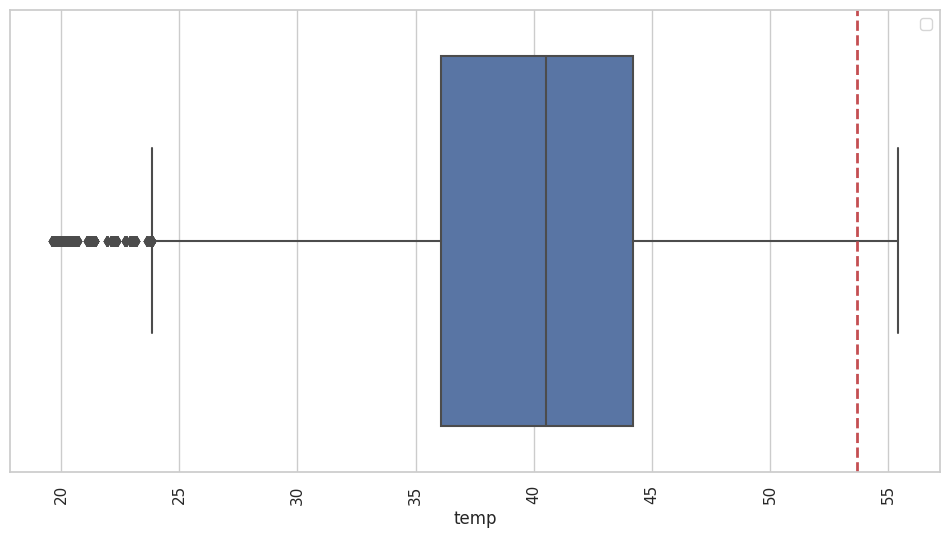

In [ ]:
box_plot_cat(df=df_train, x_value='temp', rot=90, show_mean_lines_upper=True)

Number of outliers above Mean + 2s: 222


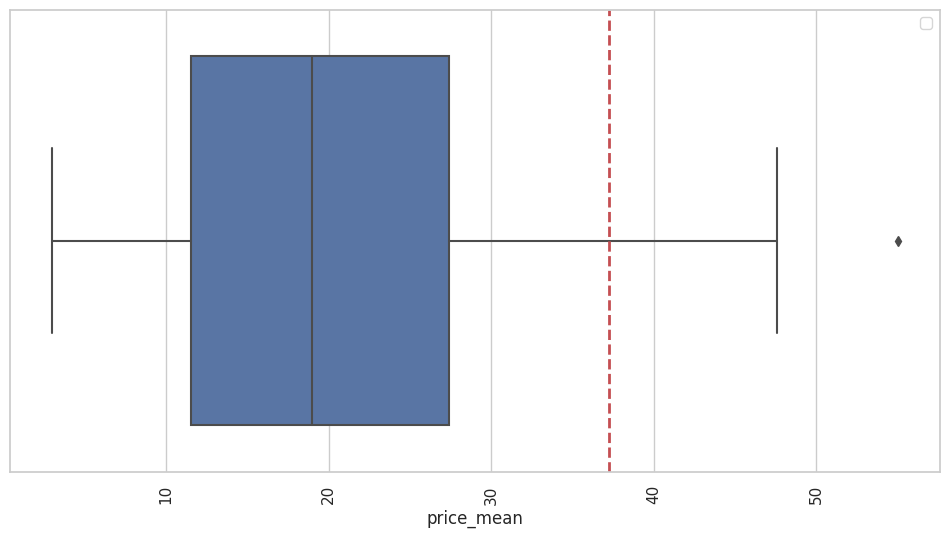

In [ ]:
box_plot_cat(df=df_train, x_value='price_mean', rot=90, show_mean_lines_upper=True)

----
**HMMMMM**

In [ ]:
df_train.nlargest(10, 'price_mean')

timestamp  api_calls    clouds  distance_max  distance_mean  \
5985 2018-11-28 08:00:00        1.0  0.505000          6.09       6.090000   
7286 2018-11-29 15:00:00        5.0  0.590000          4.73       3.912000   
5520 2018-11-26 09:00:00        8.0  1.000000          3.44       2.790000   
5519 2018-11-26 08:00:00        1.0  0.980000          3.00       3.000000   
5731 2018-11-26 08:00:00        2.0  0.986667          3.22       2.335000   
5984 2018-11-28 07:00:00        1.0  0.239231          3.87       3.870000   
5875 2018-12-02 14:00:00       10.0  1.000000          4.34       3.068000   
6882 2018-11-30 11:00:00        8.0  0.040000          3.31       2.906250   
5530 2018-11-26 19:00:00        7.0  0.945000          3.53       3.185714   
5772 2018-11-28 01:00:00        3.0       NaN          4.23       2.953333   

      distance_min  humidity  price_mean    rain  surge_max  surge_mean  \
5985          6.09  0.786667   55.000000  0.0000        1.0    1.000000   
7286          1.74  0.540000   47.600000  0.0000        1.5    1.150000   
5520          1.53  0.927500   46.000000  0.0000        2.0    1.343750   
5519          3.00  0.923333   45.500000  0.0000        1.5    1.500000   
5731          1.45  0.933333   45.500000  0.0000        2.0    1.500000   
5984          3.87  0.770000   45.500000  0.0000        1.0    1.000000   
5875          2.38  0.940000   45.450000  0.0052        2.0    1.275000   
6882          1.24  0.840000   45.187500  0.0000        2.0    1.250000   
5530          2.40  0.835000   44.857143  0.0000        2.0    1.250000   
5772          1.42       NaN   44.333333     NaN        1.5    1.166667   

      surge_min       temp       wind  type  month  day  hour  day_of_week  
5985        1.0  35.131667   5.660000    28     11   28     8            3  
7286        1.0  43.740000  11.310000    34     11   29    15            4  
5520        1.0  40.892500   1.532500    26     11   26     9            1  
5519        1.5  40.836667   1.330000    26     11   26     8            1  
5731        1.0  40.723333   1.313333    27     11   26     8            1  
5984        1.0  35.675385   6.411538    28     11   28     7            3  
5875        1.0  43.600000   6.450000    27     12    2    14            7  
6882        1.0  29.830000   3.180000    32     11   30    11            5  
5530        1.0  45.930000   8.380000    26     11   26    19            1  
5772        1.0        NaN        NaN    27     11   28     1            3

### Missing Value

In [ ]:
df2 = df_train.copy()
df_train_ori = df_train.copy()

In [ ]:
percent_missing = df2.isnull().sum()*100/len(df2)
missing_value = pd.DataFrame({'column_name': df2.columns, 'percent_missing': percent_missing})
missing_value

column_name  percent_missing
timestamp          timestamp         0.000000
api_calls          api_calls         0.000000
clouds                clouds         0.959712
distance_max    distance_max         0.000000
distance_mean  distance_mean         0.000000
distance_min    distance_min         0.000000
humidity            humidity         0.959712
price_mean        price_mean         0.000000
rain                    rain         0.959712
surge_max          surge_max         0.000000
surge_mean        surge_mean         0.000000
surge_min          surge_min         0.000000
temp                    temp         0.959712
wind                    wind         0.959712
type                    type         0.000000
month                  month         0.000000
day                      day         0.000000
hour                    hour         0.000000
day_of_week      day_of_week         0.000000

In [ ]:
df2 = df2.dropna()

In [ ]:
percent_missing = df2.isnull().sum()*100/len(df2)
missing_value = pd.DataFrame({'column_name': df2.columns, 'percent_missing': percent_missing})
missing_value

column_name  percent_missing
timestamp          timestamp              0.0
api_calls          api_calls              0.0
clouds                clouds              0.0
distance_max    distance_max              0.0
distance_mean  distance_mean              0.0
distance_min    distance_min              0.0
humidity            humidity              0.0
price_mean        price_mean              0.0
rain                    rain              0.0
surge_max          surge_max              0.0
surge_mean        surge_mean              0.0
surge_min          surge_min              0.0
temp                    temp              0.0
wind                    wind              0.0
type                    type              0.0
month                  month              0.0
day                      day              0.0
hour                    hour              0.0
day_of_week      day_of_week              0.0

In [ ]:
df2_merge = pd.merge(left=df_train, right=df2, how='outer')
df2_merge

timestamp  api_calls    clouds  distance_max  distance_mean  \
0     2018-11-26 06:00:00        9.0  0.990667          3.03       1.726667   
1     2018-11-26 07:00:00       10.0  0.970000          2.67       1.690000   
2     2018-11-26 08:00:00        1.0  0.980000          1.38       1.380000   
3     2018-11-26 09:00:00       11.0  1.000000          3.08       1.920909   
4     2018-11-26 10:00:00       12.0  0.995000          3.01       2.122500   
...                   ...        ...       ...           ...            ...   
20001 2018-12-13 19:00:00       13.0  0.510000          3.39       2.307692   
20002 2018-12-13 20:00:00        9.0  0.590000          2.80       1.902222   
20003 2018-12-13 21:00:00       16.0  0.760000          3.08       1.987500   
20004 2018-12-13 22:00:00        9.0  0.830000          3.08       2.441111   
20005 2018-12-13 23:00:00        9.0  0.540000          3.18       2.355556   

       distance_min  humidity  price_mean  rain  surge_max  surge_mean  \
0              1.04  0.913333   16.555556   0.0       1.50    1.055556   
1              1.09  0.920000   17.300000   0.0       2.00    1.100000   
2              1.38  0.923333   13.500000   0.0       1.00    1.000000   
3              1.39  0.927500   17.954545   0.0       1.75    1.113636   
4              1.07  0.940000   18.625000   0.0       1.50    1.083333   
...             ...       ...         ...   ...        ...         ...   
20001          0.72  0.570000   31.115385   0.0       1.00    1.000000   
20002          0.72  0.620000   28.833333   0.0       1.00    1.000000   
20003          0.72  0.630000   29.625000   0.0       1.00    1.000000   
20004          1.23  0.640000   30.500000   0.0       1.00    1.000000   
20005          0.72  0.660000   31.111111   0.0       1.00    1.000000   

       surge_min       temp      wind  type  month  day  hour  day_of_week  
0            1.0  40.627333  1.350667     0     11   26     6            1  
1            1.0  41.137500  1.735000     0     11   26     7            1  
2            1.0  40.920000  1.330000     0     11   26     8            1  
3            1.0  40.937500  1.365000     0     11   26     9            1  
4            1.0  40.695000  1.895000     0     11   26    10            1  
...          ...        ...       ...   ...    ...  ...   ...          ...  
20001        1.0  32.630000  1.840000    95     12   13    19            4  
20002        1.0  32.100000  1.390000    95     12   13    20            4  
20003        1.0  31.500000  2.030000    95     12   13    21            4  
20004        1.0  31.180000  2.310000    95     12   13    22            4  
20005        1.0  30.540000  2.060000    95     12   13    23            4  

[20006 rows x 19 columns]

In [ ]:
import gc
del [df2]

##Addressing Date Issues

###Peeking

In [ ]:
df_train['year'] = df_train['timestamp'].dt.year

df_train['month'] = df_train['timestamp'].dt.month

df_train['day'] = df_train['timestamp'].dt.day

df_train['hour'] = df_train['timestamp'].dt.hour

df_train['day_of_week'] = df_train['timestamp'].dt.dayofweek + 1

In [ ]:
df_test['type'].unique()

[0, 1, 2, 3, 4, ..., 91, 92, 93, 94, 95]
Length: 96
Categories (96, int64): [0, 1, 2, 3, ..., 92, 93, 94, 95]

In [ ]:
df_train = df_train[(df_train['day']!=10) | (df_train['month']!=12)]

In [ ]:
df_train = df_train[(df_train['day']!=9) | (df_train['month']!=12)]
df_train.shape

(20006, 20)

In [ ]:
df_train['type'].value_counts()

0     209
61    209
36    209
37    209
39    209
     ... 
89    207
44    207
83    207
20    207
95    207
Name: type, Length: 96, dtype: int64

###Addressing

In [ ]:
df_train.tail()

timestamp  api_calls  clouds  distance_max  distance_mean  \
20350 2018-12-13 19:00:00       13.0    0.51          3.39       2.307692   
20351 2018-12-13 20:00:00        9.0    0.59          2.80       1.902222   
20352 2018-12-13 21:00:00       16.0    0.76          3.08       1.987500   
20353 2018-12-13 22:00:00        9.0    0.83          3.08       2.441111   
20354 2018-12-13 23:00:00        9.0    0.54          3.18       2.355556   

       distance_min  humidity  price_mean  rain  surge_max  surge_mean  \
20350          0.72      0.57   31.115385   0.0        1.0         1.0   
20351          0.72      0.62   28.833333   0.0        1.0         1.0   
20352          0.72      0.63   29.625000   0.0        1.0         1.0   
20353          1.23      0.64   30.500000   0.0        1.0         1.0   
20354          0.72      0.66   31.111111   0.0        1.0         1.0   

       surge_min   temp  wind  type  month  day  hour  day_of_week  year  
20350        1.0  32.63  1.84    95     12   13    19            4  2018  
20351        1.0  32.10  1.39    95     12   13    20            4  2018  
20352        1.0  31.50  2.03    95     12   13    21            4  2018  
20353        1.0  31.18  2.31    95     12   13    22            4  2018  
20354        1.0  30.54  2.06    95     12   13    23            4  2018

In [ ]:
df_train.head()

timestamp  api_calls    clouds  distance_max  distance_mean  \
0 2018-11-26 06:00:00        9.0  0.990667          3.03       1.726667   
1 2018-11-26 07:00:00       10.0  0.970000          2.67       1.690000   
2 2018-11-26 08:00:00        1.0  0.980000          1.38       1.380000   
3 2018-11-26 09:00:00       11.0  1.000000          3.08       1.920909   
4 2018-11-26 10:00:00       12.0  0.995000          3.01       2.122500   

   distance_min  humidity  price_mean  rain  surge_max  surge_mean  surge_min  \
0          1.04  0.913333   16.555556   0.0       1.50    1.055556        1.0   
1          1.09  0.920000   17.300000   0.0       2.00    1.100000        1.0   
2          1.38  0.923333   13.500000   0.0       1.00    1.000000        1.0   
3          1.39  0.927500   17.954545   0.0       1.75    1.113636        1.0   
4          1.07  0.940000   18.625000   0.0       1.50    1.083333        1.0   

        temp      wind  type  month  day  hour  day_of_week  year  
0  40.627333  1.350667     0     11   26     6            1  2018  
1  41.137500  1.735000     0     11   26     7            1  2018  
2  40.920000  1.330000     0     11   26     8            1  2018  
3  40.937500  1.365000     0     11   26     9            1  2018  
4  40.695000  1.895000     0     11   26    10            1  2018

In [ ]:
df_train2 = df_train.copy()
'''
# Create a new DataFrame with hourly datetime values
start_date = df_train2['timestamp'].min()
end_date = df_train2['timestamp'].max()
hourly_dates = pd.date_range(start=start_date, end=end_date, freq='H')

# Merge the hourly datetime DataFrame with the original DataFrame
df_train2 = pd.merge(df_train2, pd.DataFrame({'timestamp': pd.to_datetime(hourly_dates)}), on='timestamp', how='outer')
'''

"\n# Create a new DataFrame with hourly datetime values\nstart_date = df_train2['timestamp'].min()\nend_date = df_train2['timestamp'].max()\nhourly_dates = pd.date_range(start=start_date, end=end_date, freq='H')\n\n# Merge the hourly datetime DataFrame with the original DataFrame\ndf_train2 = pd.merge(df_train2, pd.DataFrame({'timestamp': pd.to_datetime(hourly_dates)}), on='timestamp', how='outer')\n"

In [ ]:
'''
hourly_dates
'''

'\nhourly_dates\n'

In [ ]:
df_train2['timestamp'] = pd.to_datetime(df_train2['timestamp'])

In [ ]:
df_train['type'].unique()

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
       51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67,
       68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84,
       85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95])

In [ ]:
df_train2['type'].unique()

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
       51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67,
       68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84,
       85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95])

In [ ]:
#df_train2['type'] = df_train['type']

In [ ]:
df_train2['type'].unique()

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
       51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67,
       68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84,
       85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95])

In [ ]:
df_train2.head()

timestamp  api_calls    clouds  distance_max  distance_mean  \
0 2018-11-26 06:00:00        9.0  0.990667          3.03       1.726667   
1 2018-11-26 07:00:00       10.0  0.970000          2.67       1.690000   
2 2018-11-26 08:00:00        1.0  0.980000          1.38       1.380000   
3 2018-11-26 09:00:00       11.0  1.000000          3.08       1.920909   
4 2018-11-26 10:00:00       12.0  0.995000          3.01       2.122500   

   distance_min  humidity  price_mean  rain  surge_max  surge_mean  surge_min  \
0          1.04  0.913333   16.555556   0.0       1.50    1.055556        1.0   
1          1.09  0.920000   17.300000   0.0       2.00    1.100000        1.0   
2          1.38  0.923333   13.500000   0.0       1.00    1.000000        1.0   
3          1.39  0.927500   17.954545   0.0       1.75    1.113636        1.0   
4          1.07  0.940000   18.625000   0.0       1.50    1.083333        1.0   

        temp      wind  type  month  day  hour  day_of_week  year  
0  40.627333  1.350667     0     11   26     6            1  2018  
1  41.137500  1.735000     0     11   26     7            1  2018  
2  40.920000  1.330000     0     11   26     8            1  2018  
3  40.937500  1.365000     0     11   26     9            1  2018  
4  40.695000  1.895000     0     11   26    10            1  2018

In [ ]:
df_train2['year'] = df_train2['timestamp'].dt.year

df_train2['month'] = df_train2['timestamp'].dt.month

df_train2['day'] = df_train2['timestamp'].dt.day

df_train2['hour'] = df_train2['timestamp'].dt.hour

df_train2['day_of_week'] = df_train2['timestamp'].dt.dayofweek + 1

In [ ]:
df_train2[(df_train2['day']==12)]['hour'].unique()

array([], dtype=int64)

In [ ]:
df_train2[(df_train2['day']==12)]['timestamp'].unique()

array([], dtype='datetime64[ns]')

In [ ]:
df_train2[(df_train2['day']==6)]['timestamp'].unique()

array([], dtype='datetime64[ns]')

In [ ]:
df_train2[(df_train2['day']==6)]['hour'].unique()

array([], dtype=int64)

In [ ]:
df_train2[(df_train2['day']==12)].tail(10)

Empty DataFrame
Columns: [timestamp, api_calls, clouds, distance_max, distance_mean, distance_min, humidity, price_mean, rain, surge_max, surge_mean, surge_min, temp, wind, type, month, day, hour, day_of_week, year]
Index: []

In [ ]:
df_train2['type'].unique()

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
       51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67,
       68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84,
       85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95])

In [ ]:
#df_train2 = df_train2.sort_values(by='timestamp')

In [ ]:
df_train = df_train2
del(df_train2)

In [ ]:
df_train.head(1)

timestamp  api_calls    clouds  distance_max  distance_mean  \
0 2018-11-26 06:00:00        9.0  0.990667          3.03       1.726667   

   distance_min  humidity  price_mean  rain  surge_max  surge_mean  surge_min  \
0          1.04  0.913333   16.555556   0.0        1.5    1.055556        1.0   

        temp      wind  type  month  day  hour  day_of_week  year  
0  40.627333  1.350667     0     11   26     6            1  2018

In [ ]:
df_train.drop(['month', 'day', 'year'], axis=1, inplace=True)

In [ ]:
df_train.head(1)

timestamp  api_calls    clouds  distance_max  distance_mean  \
0 2018-11-26 06:00:00        9.0  0.990667          3.03       1.726667   

   distance_min  humidity  price_mean  rain  surge_max  surge_mean  surge_min  \
0          1.04  0.913333   16.555556   0.0        1.5    1.055556        1.0   

        temp      wind  type  hour  day_of_week  
0  40.627333  1.350667     0     6            1

In [ ]:
df_train['type'].unique()

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
       51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67,
       68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84,
       85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95])

###Cyclic Feature Engineering + **Shuffling Order of Type**

In [ ]:
# Shuffle the DataFrame
df_train = df_train.sample(frac=1, random_state=69).reset_index(drop=True)

# Reindex the shuffled DataFrame
df_train = df_train.reset_index(drop=True)

# Sort the DataFrame by the 'timestamp' column
df_train = df_train.sort_values(by='timestamp')

In [ ]:
def time_features(
    _df: pd.DataFrame,
) -> pd.DataFrame:
    """
    """
    df = _df.copy()

    time = pd.to_datetime(df_train.pop('timestamp'))

    hour = time.dt.hour
    dw = time.dt.day_of_week
    dm = time.dt.day

    for time, col in zip([hour
                          , dm
                          , dw], ['hour'
                          , 'dm'
                          , 'dw']):
        time_range = {'hour': 24, 'dw': 7
                      , 'dm': 31,
                      }
        df[f'{col}_sin'] = np.sin(time * (2 * np.pi / time_range[col]))
        df[f'{col}_cos'] = np.cos(time * (2 * np.pi / time_range[col]))

    return df

def time_features2(
    _df: pd.DataFrame,
) -> pd.DataFrame:
    """
    """
    df = _df.copy()

    time = pd.to_datetime(df_train.pop('timestamp'))

    hour = time.dt.hour
    dw = time.dt.day_of_week
    dm = time.dt.day

    for time, col in zip([hour
                          , dm
                          , dw], ['hour'
                          , 'dm'
                          , 'dw']):
        time_range = {'hour': 24, 'dw': 7
                      , 'dm': 31,
                      }
        df[f'{col}_sin'] = np.sin(time * (2 * np.pi / time_range[col]))
        df[f'{col}_cos'] = np.cos(time * (2 * np.pi / time_range[col]))


def time_features3(
    _df: pd.DataFrame,
) -> pd.DataFrame:
    """
    """
    df = _df.copy()

    time = pd.to_datetime(df_test.pop('timestamp'))

    hour = time.dt.hour
    dw = time.dt.day_of_week
    dm = time.dt.day

    for time, col in zip([hour
                          , dm
                          , dw], ['hour'
                          , 'dm'
                          , 'dw']):
        time_range = {'hour': 24, 'dw': 7
                      , 'dm': 31,
                      }
        df[f'{col}_sin'] = np.sin(time * (2 * np.pi / time_range[col]))
        df[f'{col}_cos'] = np.cos(time * (2 * np.pi / time_range[col]))

    return df

def time_features4(
    _df: pd.DataFrame,
) -> pd.DataFrame:
    """
    """
    df = _df.copy()

    time = pd.to_datetime(df_test.pop('timestamp'))

    hour = time.dt.hour
    dw = time.dt.day_of_week
    dm = time.dt.day

    for time, col in zip([hour
                          , dm
                          , dw], ['hour'
                          , 'dm'
                          , 'dw']):
        time_range = {'hour': 24, 'dw': 7
                      , 'dm': 31,
                      }
        df[f'{col}_sin'] = np.sin(time * (2 * np.pi / time_range[col]))
        df[f'{col}_cos'] = np.cos(time * (2 * np.pi / time_range[col]))

In [ ]:
df_test.iloc[188:191]

index           timestamp  api_calls  clouds  distance_max  \
188    188 2018-12-17 01:00:00       17.0     1.0          2.52   
189    189 2018-12-17 02:00:00       13.0     1.0          2.49   
190    190 2018-12-17 03:00:00       12.0     1.0          2.45   

     distance_mean  distance_min  humidity   rain  surge_max  surge_mean  \
188       2.072941          1.27      0.90  0.025       1.50    1.058824   
189       2.058462          1.38      0.92  0.006       1.25    1.019231   
190       2.118333          1.32      0.91  0.002       1.00    1.000000   

     surge_min   temp   wind type  year  month  day  hour  day_of_week  
188        1.0  40.39  10.48    1  2018     12   17     1            1  
189        1.0  39.76  10.28    1  2018     12   17     2            1  
190        1.0  39.19  11.45    1  2018     12   17     3            1

In [ ]:
##Apply Function
df_train = df_train.pipe(time_features)
df_test = df_test.pipe(time_features3)

In [ ]:
df_train.drop(['timestamp'], axis=1, inplace=True)
df_test.drop(['timestamp'], axis=1, inplace=True)

In [ ]:
df_train=df_train.reset_index()

In [ ]:
df_train

index  api_calls    clouds  distance_max  distance_mean  distance_min  \
0       9449        9.0  0.990667          3.03       1.726667          1.04   
1       8562       11.0  0.990667          2.48       2.184545          1.35   
2       9146        6.0  0.990667          4.03       2.893333          1.27   
3       2994        8.0  0.990667          3.24       2.193750          1.27   
4      16472        7.0  0.990667          2.80       1.502857          1.13   
...      ...        ...       ...           ...            ...           ...   
20001   2121       14.0  0.540000          3.00       2.171429          0.83   
20002  19571       11.0  0.540000          4.46       3.130909          1.44   
20003  11727       14.0  0.540000          5.15       2.805000          0.45   
20004  17228        9.0  0.540000          4.57       3.015556          1.64   
20005  16656       12.0  0.540000          3.18       2.191667          1.71   

       humidity  price_mean  rain  surge_max  ...      wind  type  hour  \
0      0.913333   16.555556   0.0       1.50  ...  1.350667     0     6   
1      0.913333   28.227273   0.0       1.00  ...  1.376667    85     6   
2      0.920000   23.250000   0.0       1.50  ...  1.328667     8     6   
3      0.920000   22.250000   0.0       1.25  ...  1.328667    20     6   
4      0.913333   12.785714   0.0       1.00  ...  1.422000    54     6   
...         ...         ...   ...        ...  ...       ...   ...   ...   
20001  0.660000    9.678571   0.0       1.00  ...  2.060000    47    23   
20002  0.670000   20.909091   0.0       1.25  ...  2.040000     3    23   
20003  0.620000   10.535714   0.0       1.75  ...  2.120000    40    23   
20004  0.670000   31.777778   0.0       1.00  ...  2.070000    92    23   
20005  0.670000   24.041667   0.0       2.00  ...  2.100000    22    23   

       day_of_week  hour_sin      hour_cos    dm_sin    dm_cos    dw_sin  \
0                1  1.000000  6.123234e-17 -0.848644  0.528964  0.000000   
1                1  1.000000  6.123234e-17 -0.848644  0.528964  0.000000   
2                1  1.000000  6.123234e-17 -0.848644  0.528964  0.000000   
3                1  1.000000  6.123234e-17 -0.848644  0.528964  0.000000   
4                1  1.000000  6.123234e-17 -0.848644  0.528964  0.000000   
...            ...       ...           ...       ...       ...       ...   
20001            4 -0.258819  9.659258e-01  0.485302 -0.874347  0.433884   
20002            4 -0.258819  9.659258e-01  0.485302 -0.874347  0.433884   
20003            4 -0.258819  9.659258e-01  0.485302 -0.874347  0.433884   
20004            4 -0.258819  9.659258e-01  0.485302 -0.874347  0.433884   
20005            4 -0.258819  9.659258e-01  0.485302 -0.874347  0.433884   

         dw_cos  
0      1.000000  
1      1.000000  
2      1.000000  
3      1.000000  
4      1.000000  
...         ...  
20001 -0.900969  
20002 -0.900969  
20003 -0.900969  
20004 -0.900969  
20005 -0.900969  

[20006 rows x 23 columns]

In [ ]:
df_train.shape

(20006, 23)

In [ ]:
df_train = df_train.dropna(subset=['price_mean'])
df_train.shape

(20006, 23)

In [ ]:
df_train.isna().sum()

index              0
api_calls          0
clouds           192
distance_max       0
distance_mean      0
distance_min       0
humidity         192
price_mean         0
rain             192
surge_max          0
surge_mean         0
surge_min          0
temp             192
wind             192
type               0
hour               0
day_of_week        0
hour_sin           0
hour_cos           0
dm_sin             0
dm_cos             0
dw_sin             0
dw_cos             0
dtype: int64

In [ ]:
df_test.isna().sum()

index            0
api_calls        0
clouds           0
distance_max     0
distance_mean    0
distance_min     0
humidity         0
rain             0
surge_max        0
surge_mean       0
surge_min        0
temp             0
wind             0
type             0
year             0
month            0
day              0
hour             0
day_of_week      0
hour_sin         0
hour_cos         0
dm_sin           0
dm_cos           0
dw_sin           0
dw_cos           0
dtype: int64

##Imputation

In [ ]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
df_fill=df_train.copy()
imp = IterativeImputer(max_iter=10, random_state=69)
imp.fit(df_fill)
IterativeImputer(random_state=69)
df_fill=imp.transform(df_fill)
# the model learns that the second feature is double the first
df_fill = pd.DataFrame(df_fill)
df_fill.isna().sum()

0     0
1     0
2     0
3     0
4     0
5     0
6     0
7     0
8     0
9     0
10    0
11    0
12    0
13    0
14    0
15    0
16    0
17    0
18    0
19    0
20    0
21    0
22    0
dtype: int64

In [ ]:
df_fill.columns = df_train.columns

In [ ]:
df_fill.isna().sum()

index            0
api_calls        0
clouds           0
distance_max     0
distance_mean    0
distance_min     0
humidity         0
price_mean       0
rain             0
surge_max        0
surge_mean       0
surge_min        0
temp             0
wind             0
type             0
hour             0
day_of_week      0
hour_sin         0
hour_cos         0
dm_sin           0
dm_cos           0
dw_sin           0
dw_cos           0
dtype: int64

In [ ]:
df_fill.head()

index  api_calls    clouds  distance_max  distance_mean  distance_min  \
0   9449.0        9.0  0.990667          3.03       1.726667          1.04   
1   8562.0       11.0  0.990667          2.48       2.184545          1.35   
2   9146.0        6.0  0.990667          4.03       2.893333          1.27   
3   2994.0        8.0  0.990667          3.24       2.193750          1.27   
4  16472.0        7.0  0.990667          2.80       1.502857          1.13   

   humidity  price_mean  rain  surge_max  ...      wind  type  hour  \
0  0.913333   16.555556   0.0       1.50  ...  1.350667   0.0   6.0   
1  0.913333   28.227273   0.0       1.00  ...  1.376667  85.0   6.0   
2  0.920000   23.250000   0.0       1.50  ...  1.328667   8.0   6.0   
3  0.920000   22.250000   0.0       1.25  ...  1.328667  20.0   6.0   
4  0.913333   12.785714   0.0       1.00  ...  1.422000  54.0   6.0   

   day_of_week  hour_sin      hour_cos    dm_sin    dm_cos  dw_sin  dw_cos  
0          1.0       1.0  6.123234e-17 -0.848644  0.528964     0.0     1.0  
1          1.0       1.0  6.123234e-17 -0.848644  0.528964     0.0     1.0  
2          1.0       1.0  6.123234e-17 -0.848644  0.528964     0.0     1.0  
3          1.0       1.0  6.123234e-17 -0.848644  0.528964     0.0     1.0  
4          1.0       1.0  6.123234e-17 -0.848644  0.528964     0.0     1.0  

[5 rows x 23 columns]

In [ ]:
df_train.isna().sum()

index              0
api_calls          0
clouds           192
distance_max       0
distance_mean      0
distance_min       0
humidity         192
price_mean         0
rain             192
surge_max          0
surge_mean         0
surge_min          0
temp             192
wind             192
type               0
hour               0
day_of_week        0
hour_sin           0
hour_cos           0
dm_sin             0
dm_cos             0
dw_sin             0
dw_cos             0
dtype: int64

In [ ]:
df_train[df_train.isnull().any(axis=1)]

index  api_calls  clouds  distance_max  distance_mean  distance_min  \
4114   14847        1.0     NaN          4.19       4.190000          4.19   
4115    6177        2.0     NaN          3.21       2.130000          1.05   
4116     894        3.0     NaN          3.61       1.996667          1.13   
4117    2908        5.0     NaN          5.56       3.856000          1.25   
4118   12008        7.0     NaN          3.15       2.267143          0.59   
...      ...        ...     ...           ...            ...           ...   
17985   6535        4.0     NaN          5.39       2.910000          0.43   
17986    312       12.0     NaN          3.29       2.106667          0.72   
17987  17918        4.0     NaN          3.39       1.347500          0.43   
17988   6317        9.0     NaN          2.35       1.094444          0.53   
17989    401       13.0     NaN          3.33       2.096923          0.56   

       humidity  price_mean  rain  surge_max  ...  wind  type  hour  \
4114        NaN   27.500000   NaN        1.0  ...   NaN     8     1   
4115        NaN   13.500000   NaN        1.0  ...   NaN    55     1   
4116        NaN   21.000000   NaN        1.0  ...   NaN    18     1   
4117        NaN   28.100000   NaN        1.0  ...   NaN    76     1   
4118        NaN   14.428571   NaN        1.0  ...   NaN    58     1   
...         ...         ...   ...        ...  ...   ...   ...   ...   
17985       NaN    8.125000   NaN        1.0  ...   NaN    64     6   
17986       NaN   17.000000   NaN        1.0  ...   NaN     7     6   
17987       NaN   14.500000   NaN        1.0  ...   NaN     4     6   
17988       NaN    7.000000   NaN        1.0  ...   NaN    41     6   
17989       NaN   20.923077   NaN        1.0  ...   NaN    79     6   

       day_of_week  hour_sin      hour_cos    dm_sin    dm_cos    dw_sin  \
4114             3  0.258819  9.659258e-01 -0.571268  0.820763  0.974928   
4115             3  0.258819  9.659258e-01 -0.571268  0.820763  0.974928   
4116             3  0.258819  9.659258e-01 -0.571268  0.820763  0.974928   
4117             3  0.258819  9.659258e-01 -0.571268  0.820763  0.974928   
4118             3  0.258819  9.659258e-01 -0.571268  0.820763  0.974928   
...            ...       ...           ...       ...       ...       ...   
17985            2  1.000000  6.123234e-17  0.724793  0.688967  0.781831   
17986            2  1.000000  6.123234e-17  0.724793  0.688967  0.781831   
17987            2  1.000000  6.123234e-17  0.724793  0.688967  0.781831   
17988            2  1.000000  6.123234e-17  0.724793  0.688967  0.781831   
17989            2  1.000000  6.123234e-17  0.724793  0.688967  0.781831   

         dw_cos  
4114  -0.222521  
4115  -0.222521  
4116  -0.222521  
4117  -0.222521  
4118  -0.222521  
...         ...  
17985  0.623490  
17986  0.623490  
17987  0.623490  
17988  0.623490  
17989  0.623490  

[192 rows x 23 columns]

In [ ]:
df_fill.loc[4114:4118]

index  api_calls    clouds  distance_max  distance_mean  distance_min  \
4114  14847.0        1.0  0.445996          4.19       4.190000          4.19   
4115   6177.0        2.0  0.418947          3.21       2.130000          1.05   
4116    894.0        3.0  0.429296          3.61       1.996667          1.13   
4117   2908.0        5.0  0.434911          5.56       3.856000          1.25   
4118  12008.0        7.0  0.451028          3.15       2.267143          0.59   

      humidity  price_mean      rain  surge_max  ...      wind  type  hour  \
4114  0.708168   27.500000  0.014480        1.0  ...  9.464284   8.0   1.0   
4115  0.702708   13.500000  0.015604        1.0  ...  9.901309  55.0   1.0   
4116  0.703682   21.000000  0.016182        1.0  ...  9.861516  18.0   1.0   
4117  0.705751   28.100000  0.016682        1.0  ...  9.969577  76.0   1.0   
4118  0.710903   14.428571  0.017065        1.0  ...  9.987458  58.0   1.0   

      day_of_week  hour_sin  hour_cos    dm_sin    dm_cos    dw_sin    dw_cos  
4114          3.0  0.258819  0.965926 -0.571268  0.820763  0.974928 -0.222521  
4115          3.0  0.258819  0.965926 -0.571268  0.820763  0.974928 -0.222521  
4116          3.0  0.258819  0.965926 -0.571268  0.820763  0.974928 -0.222521  
4117          3.0  0.258819  0.965926 -0.571268  0.820763  0.974928 -0.222521  
4118          3.0  0.258819  0.965926 -0.571268  0.820763  0.974928 -0.222521  

[5 rows x 23 columns]

In [ ]:
df_train.describe()

index     api_calls        clouds  distance_max  distance_mean  \
count  20006.000000  20006.000000  19814.000000   20006.00000   20006.000000   
mean   10002.500000     14.207988      0.639807       3.57582       2.184923   
std     5775.379078      7.127382      0.333560       1.10851       0.606090   
min        0.000000      1.000000      0.000000       0.03000       0.030000   
25%     5001.250000     10.000000      0.390000       2.74250       1.768576   
50%    10002.500000     13.000000      0.730000       3.30000       2.130000   
75%    15003.750000     17.000000      0.956250       4.42000       2.641861   
max    20005.000000     53.000000      1.000000       7.50000       6.090000   

       distance_min      humidity    price_mean          rain     surge_max  \
count  20006.000000  19814.000000  20006.000000  19814.000000  20006.000000   
mean       1.009765      0.749250     19.344649      0.006119      1.203139   
std        0.494026      0.138124      8.942249      0.029819      0.322339   
min        0.020000      0.460000      3.000000      0.000000      1.000000   
25%        0.580000      0.630000     11.541667      0.000000      1.000000   
50%        1.000000      0.730000     19.000000      0.000000      1.000000   
75%        1.350000      0.890000     27.384615      0.000000      1.250000   
max        6.090000      0.990000     55.000000      0.359825      3.000000   

       ...          wind          type          hour   day_of_week  \
count  ...  19814.000000  20006.000000  20006.000000  20006.000000   
mean   ...      5.949875     47.479306     11.815505      3.701889   
std    ...      3.502918     27.708943      6.832088      2.003821   
min    ...      0.300000      0.000000      0.000000      1.000000   
25%    ...      2.920000     23.000000      6.000000      2.000000   
50%    ...      5.100000     47.000000     12.000000      4.000000   
75%    ...      9.240000     71.000000     18.000000      5.000000   
max    ...     16.570000     95.000000     23.000000      7.000000   

           hour_sin      hour_cos        dm_sin        dm_cos        dw_sin  \
count  20006.000000  2.000600e+04  20006.000000  20006.000000  20006.000000   
mean      -0.020780 -2.348998e-02     -0.067984      0.664519      0.044503   
std        0.708791  7.047562e-01      0.520349      0.532032      0.644828   
min       -1.000000 -1.000000e+00     -0.848644     -0.874347     -0.974928   
25%       -0.707107 -7.071068e-01     -0.571268      0.688967     -0.433884   
50%        0.000000 -1.836970e-16     -0.201299      0.820763      0.000000   
75%        0.707107  7.071068e-01      0.394356      0.918958      0.433884   
max        1.000000  1.000000e+00      0.724793      0.979530      0.974928   

             dw_cos  
count  20006.000000  
mean       0.021723  
std        0.762755  
min       -0.900969  
25%       -0.900969  
50%       -0.222521  
75%        0.623490  
max        1.000000  

[8 rows x 23 columns]

In [ ]:
df_fill['rain'] = df_fill['rain'].apply(lambda x: 0 if x < 0 else x)

##Manual Weather Feature Engineering

In [ ]:
# Define cutoff values for low, medium, and high categories
cutoffs = [0.5, 0.7]
categories = ['low', 'medium', 'high']

# Categorize humidity values based on cutoffs using numpy's select function
df_test['humidity_cat'] = pd.Series(pd.cut(df_test['humidity'], bins=[-float('inf')] + cutoffs + [float('inf')], labels=categories))
df_test

index  api_calls  clouds  distance_max  distance_mean  distance_min  \
0          0       13.0    0.69          3.02       1.980000          1.06   
1          1       14.0    0.77          2.34       1.541429          1.04   
2          2       13.0    0.59          3.00       2.010769          1.08   
3          3       12.0    0.68          3.14       1.860833          1.06   
4          4        7.0    0.72          2.41       1.634286          1.06   
...      ...        ...     ...           ...            ...           ...   
11035  11035       11.0    0.48          3.08       2.024545          0.72   
11036  11036       16.0    0.34          3.20       2.002500          0.72   
11037  11037        7.0    0.31          3.08       2.105714          0.72   
11038  11038        8.0    0.15          3.20       1.952500          0.72   
11039  11039        9.0    0.00          3.15       2.721111          1.06   

       humidity  rain  surge_max  surge_mean  ...  day  hour  day_of_week  \
0          0.68   0.0       2.00    1.115385  ...   14     0            5   
1          0.68   0.0       1.00    1.000000  ...   14     1            5   
2          0.69   0.0       1.50    1.096154  ...   14     2            5   
3          0.70   0.0       1.25    1.020833  ...   14     3            5   
4          0.71   0.0       1.25    1.035714  ...   14     4            5   
...         ...   ...        ...         ...  ...  ...   ...          ...   
11035      0.47   0.0       1.00    1.000000  ...   18    14            2   
11036      0.46   0.0       1.00    1.000000  ...   18    15            2   
11037      0.47   0.0       1.00    1.000000  ...   18    16            2   
11038      0.46   0.0       1.00    1.000000  ...   18    17            2   
11039      0.46   0.0       1.00    1.000000  ...   18    18            2   

       hour_sin      hour_cos    dm_sin    dm_cos    dw_sin    dw_cos  \
0      0.000000  1.000000e+00  0.299363 -0.954139 -0.433884 -0.900969   
1      0.258819  9.659258e-01  0.299363 -0.954139 -0.433884 -0.900969   
2      0.500000  8.660254e-01  0.299363 -0.954139 -0.433884 -0.900969   
3      0.707107  7.071068e-01  0.299363 -0.954139 -0.433884 -0.900969   
4      0.866025  5.000000e-01  0.299363 -0.954139 -0.433884 -0.900969   
...         ...           ...       ...       ...       ...       ...   
11035 -0.500000 -8.660254e-01 -0.485302 -0.874347  0.781831  0.623490   
11036 -0.707107 -7.071068e-01 -0.485302 -0.874347  0.781831  0.623490   
11037 -0.866025 -5.000000e-01 -0.485302 -0.874347  0.781831  0.623490   
11038 -0.965926 -2.588190e-01 -0.485302 -0.874347  0.781831  0.623490   
11039 -1.000000 -1.836970e-16 -0.485302 -0.874347  0.781831  0.623490   

       humidity_cat  
0            medium  
1            medium  
2            medium  
3            medium  
4              high  
...             ...  
11035           low  
11036           low  
11037           low  
11038           low  
11039           low  

[11040 rows x 26 columns]

In [ ]:
conditions_rain = [

    (df_test['rain'] <= 0.02),
    (df_test['rain']  > 0.02)

]

choices_rain = ['No', 'Yes']

# Use numpy's select function to assign categories based on conditions
df_test['rain_cat'] = pd.Series(pd.np.select(conditions_rain, choices_rain, default='undefined'))

In [ ]:
cutoffs = [0.5, 0.7]
categories_clouds = ['low', 'medium', 'high']

# Categorize 'clouds' column based on cutoff values using conditional statements
df_test['clouds_cat'] = pd.cut(df_test['clouds'], bins=[-float('inf')] + cutoffs + [float('inf')], labels=categories_clouds)

In [ ]:
cutoffs = [3, 9]
categories_wind = ['low', 'medium', 'high']

# Categorize 'wind' column based on cutoff values using conditional statements
df_test['wind_cat'] = pd.cut(df_test['wind'], bins=[-float('inf')] + cutoffs + [float('inf')], labels=categories_wind)


In [ ]:

# Define conditions based on combinations of clouds_cat, rain, and humidity
conditions_clear = (df_test['clouds_cat'] == 'low') & (df_test['rain_cat'] == 'No')
conditions_cloudy_medium = (df_test['clouds_cat'] == 'medium') & (df_test['rain_cat'] == 'No')
conditions_cloudy_high = (df_test['clouds_cat'] == 'high') & (df_test['rain_cat'] == 'No')
conditions_rainy = (df_test['rain_cat'] == 'Yes')
#conditions_storm = (df_test['wind_cat'] == 'Yes') & (df_test['wind_cat'] == 'high')

df_test['weather'] = 'undefined'

# Apply conditions to categorize weather
df_test.loc[conditions_clear, 'weather'] = 'clear'
df_test.loc[conditions_cloudy_medium, 'weather'] = 'cloudy'
df_test.loc[conditions_cloudy_high, 'weather'] = 'cloudy'

df_test.loc[conditions_rainy, 'weather'] = 'rainy'
#df_test.loc[conditions_storm, 'weather'] = 'storm'

df_test


index  api_calls  clouds  distance_max  distance_mean  distance_min  \
0          0       13.0    0.69          3.02       1.980000          1.06   
1          1       14.0    0.77          2.34       1.541429          1.04   
2          2       13.0    0.59          3.00       2.010769          1.08   
3          3       12.0    0.68          3.14       1.860833          1.06   
4          4        7.0    0.72          2.41       1.634286          1.06   
...      ...        ...     ...           ...            ...           ...   
11035  11035       11.0    0.48          3.08       2.024545          0.72   
11036  11036       16.0    0.34          3.20       2.002500          0.72   
11037  11037        7.0    0.31          3.08       2.105714          0.72   
11038  11038        8.0    0.15          3.20       1.952500          0.72   
11039  11039        9.0    0.00          3.15       2.721111          1.06   

       humidity  rain  surge_max  surge_mean  ...      hour_cos    dm_sin  \
0          0.68   0.0       2.00    1.115385  ...  1.000000e+00  0.299363   
1          0.68   0.0       1.00    1.000000  ...  9.659258e-01  0.299363   
2          0.69   0.0       1.50    1.096154  ...  8.660254e-01  0.299363   
3          0.70   0.0       1.25    1.020833  ...  7.071068e-01  0.299363   
4          0.71   0.0       1.25    1.035714  ...  5.000000e-01  0.299363   
...         ...   ...        ...         ...  ...           ...       ...   
11035      0.47   0.0       1.00    1.000000  ... -8.660254e-01 -0.485302   
11036      0.46   0.0       1.00    1.000000  ... -7.071068e-01 -0.485302   
11037      0.47   0.0       1.00    1.000000  ... -5.000000e-01 -0.485302   
11038      0.46   0.0       1.00    1.000000  ... -2.588190e-01 -0.485302   
11039      0.46   0.0       1.00    1.000000  ... -1.836970e-16 -0.485302   

         dm_cos    dw_sin    dw_cos  humidity_cat  rain_cat  clouds_cat  \
0     -0.954139 -0.433884 -0.900969        medium        No      medium   
1     -0.954139 -0.433884 -0.900969        medium        No        high   
2     -0.954139 -0.433884 -0.900969        medium        No      medium   
3     -0.954139 -0.433884 -0.900969        medium        No      medium   
4     -0.954139 -0.433884 -0.900969          high        No        high   
...         ...       ...       ...           ...       ...         ...   
11035 -0.874347  0.781831  0.623490           low        No         low   
11036 -0.874347  0.781831  0.623490           low        No         low   
11037 -0.874347  0.781831  0.623490           low        No         low   
11038 -0.874347  0.781831  0.623490           low        No         low   
11039 -0.874347  0.781831  0.623490           low        No         low   

       wind_cat  weather  
0           low   cloudy  
1           low   cloudy  
2           low   cloudy  
3           low   cloudy  
4           low   cloudy  
...         ...      ...  
11035      high    clear  
11036      high    clear  
11037      high    clear  
11038      high    clear  
11039      high    clear  

[11040 rows x 30 columns]

In [ ]:
# Define cutoff values for low, medium, and high categories
cutoffs = [0.5, 0.7]
categories = ['low', 'medium', 'high']

# Categorize humidity values based on cutoffs using numpy's select function
df_fill['humidity_cat'] = pd.Series(pd.cut(df_fill['humidity'], bins=[-float('inf')] + cutoffs + [float('inf')], labels=categories))

In [ ]:
conditions_rain = [

    (df_fill['rain'] <= 0.02),
    (df_fill['rain']  > 0.02)

]

choices_rain = ['No', 'Yes']

# Use numpy's select function to assign categories based on conditions
df_fill['rain_cat'] = pd.Series(pd.np.select(conditions_rain, choices_rain, default='undefined'))

In [ ]:
cutoffs = [0.5, 0.7]
categories_clouds = ['low', 'medium', 'high']

# Categorize 'clouds' column based on cutoff values using conditional statements
df_fill['clouds_cat'] = pd.cut(df_fill['clouds'], bins=[-float('inf')] + cutoffs + [float('inf')], labels=categories_clouds)

In [ ]:
'''
cutoffs = [3, 9]
categories_wind = ['low', 'medium', 'high']

# Categorize 'wind' column based on cutoff values using conditional statements
df_fill['wind_cat'] = pd.cut(df_fill['wind'], bins=[-float('inf')] + cutoffs + [float('inf')], labels=categories_wind)
'''

"\ncutoffs = [3, 9]\ncategories_wind = ['low', 'medium', 'high']\n\n# Categorize 'wind' column based on cutoff values using conditional statements\ndf_fill['wind_cat'] = pd.cut(df_fill['wind'], bins=[-float('inf')] + cutoffs + [float('inf')], labels=categories_wind)\n"

In [ ]:

# Define conditions based on combinations of clouds_cat, rain, and humidity
conditions_clear = (df_fill['clouds_cat'] == 'low') & (df_fill['rain_cat'] == 'No')
conditions_cloudy_medium = (df_fill['clouds_cat'] == 'medium') & (df_fill['rain_cat'] == 'No')
conditions_cloudy_high = (df_fill['clouds_cat'] == 'high') & (df_fill['rain_cat'] == 'No')
conditions_rainy = (df_fill['rain_cat'] == 'Yes')
#conditions_storm = (df_fill['wind_cat'] == 'Yes') & (df_fill['wind_cat'] == 'high')

df_fill['weather'] = 'undefined'

# Apply conditions to categorize weather
df_fill.loc[conditions_clear, 'weather'] = 'clear'
df_fill.loc[conditions_cloudy_medium, 'weather'] = 'cloudy'
df_fill.loc[conditions_cloudy_high, 'weather'] = 'cloudy'

df_fill.loc[conditions_rainy, 'weather'] = 'rainy'
#df_fill.loc[conditions_storm, 'weather'] = 'storm'

df_fill


index  api_calls    clouds  distance_max  distance_mean  \
0       9449.0        9.0  0.990667          3.03       1.726667   
1       8562.0       11.0  0.990667          2.48       2.184545   
2       9146.0        6.0  0.990667          4.03       2.893333   
3       2994.0        8.0  0.990667          3.24       2.193750   
4      16472.0        7.0  0.990667          2.80       1.502857   
...        ...        ...       ...           ...            ...   
20001   2121.0       14.0  0.540000          3.00       2.171429   
20002  19571.0       11.0  0.540000          4.46       3.130909   
20003  11727.0       14.0  0.540000          5.15       2.805000   
20004  17228.0        9.0  0.540000          4.57       3.015556   
20005  16656.0       12.0  0.540000          3.18       2.191667   

       distance_min  humidity  price_mean  rain  surge_max  ...  hour_sin  \
0              1.04  0.913333   16.555556   0.0       1.50  ...  1.000000   
1              1.35  0.913333   28.227273   0.0       1.00  ...  1.000000   
2              1.27  0.920000   23.250000   0.0       1.50  ...  1.000000   
3              1.27  0.920000   22.250000   0.0       1.25  ...  1.000000   
4              1.13  0.913333   12.785714   0.0       1.00  ...  1.000000   
...             ...       ...         ...   ...        ...  ...       ...   
20001          0.83  0.660000    9.678571   0.0       1.00  ... -0.258819   
20002          1.44  0.670000   20.909091   0.0       1.25  ... -0.258819   
20003          0.45  0.620000   10.535714   0.0       1.75  ... -0.258819   
20004          1.64  0.670000   31.777778   0.0       1.00  ... -0.258819   
20005          1.71  0.670000   24.041667   0.0       2.00  ... -0.258819   

           hour_cos    dm_sin    dm_cos    dw_sin    dw_cos  humidity_cat  \
0      6.123234e-17 -0.848644  0.528964  0.000000  1.000000          high   
1      6.123234e-17 -0.848644  0.528964  0.000000  1.000000          high   
2      6.123234e-17 -0.848644  0.528964  0.000000  1.000000          high   
3      6.123234e-17 -0.848644  0.528964  0.000000  1.000000          high   
4      6.123234e-17 -0.848644  0.528964  0.000000  1.000000          high   
...             ...       ...       ...       ...       ...           ...   
20001  9.659258e-01  0.485302 -0.874347  0.433884 -0.900969        medium   
20002  9.659258e-01  0.485302 -0.874347  0.433884 -0.900969        medium   
20003  9.659258e-01  0.485302 -0.874347  0.433884 -0.900969        medium   
20004  9.659258e-01  0.485302 -0.874347  0.433884 -0.900969        medium   
20005  9.659258e-01  0.485302 -0.874347  0.433884 -0.900969        medium   

       rain_cat  clouds_cat  weather  
0            No        high   cloudy  
1            No        high   cloudy  
2            No        high   cloudy  
3            No        high   cloudy  
4            No        high   cloudy  
...         ...         ...      ...  
20001        No      medium   cloudy  
20002        No      medium   cloudy  
20003        No      medium   cloudy  
20004        No      medium   cloudy  
20005        No      medium   cloudy  

[20006 rows x 27 columns]

In [ ]:

df_test['weather'] = df_test['weather'].astype('category')
df_fill['weather'] = df_fill['weather'].astype('category')


df_test['rain_cat'] = df_test['rain_cat'].astype('category')
df_fill['rain_cat'] = df_fill['rain_cat'].astype('category')

##CrossChecking

---


*   day_of_week_cat is when the day is tuesday or saturday in which they are lower than the rest of the days of the week, thus they are categorized as 0, the rest as 1
*   hour_cat is when the hour is 6 and 10 to 16 (or in 24h format is 7 and 11 to 17) in which they are higher than the rest of the hours, representing the active mobility hour for school (underage thus not allowed to drive by themselves)m thus categorized as 0, the rest as 1




In [ ]:
df_train.head()

index  api_calls    clouds  distance_max  distance_mean  distance_min  \
0   9449        9.0  0.990667          3.03       1.726667          1.04   
1   8562       11.0  0.990667          2.48       2.184545          1.35   
2   9146        6.0  0.990667          4.03       2.893333          1.27   
3   2994        8.0  0.990667          3.24       2.193750          1.27   
4  16472        7.0  0.990667          2.80       1.502857          1.13   

   humidity  price_mean  rain  surge_max  ...      wind  type  hour  \
0  0.913333   16.555556   0.0       1.50  ...  1.350667     0     6   
1  0.913333   28.227273   0.0       1.00  ...  1.376667    85     6   
2  0.920000   23.250000   0.0       1.50  ...  1.328667     8     6   
3  0.920000   22.250000   0.0       1.25  ...  1.328667    20     6   
4  0.913333   12.785714   0.0       1.00  ...  1.422000    54     6   

   day_of_week  hour_sin      hour_cos    dm_sin    dm_cos  dw_sin  dw_cos  
0            1       1.0  6.123234e-17 -0.848644  0.528964     0.0     1.0  
1            1       1.0  6.123234e-17 -0.848644  0.528964     0.0     1.0  
2            1       1.0  6.123234e-17 -0.848644  0.528964     0.0     1.0  
3            1       1.0  6.123234e-17 -0.848644  0.528964     0.0     1.0  
4            1       1.0  6.123234e-17 -0.848644  0.528964     0.0     1.0  

[5 rows x 23 columns]

In [ ]:
# Define a function to categorize values based on conditions
def categorize_day_of_week(value):
    if value in [2, 6]:
        return 0
    else:
        return 1

def categorize_hour(value):
    if value == 6 or value in range(10, 17):
        return 0
    else:
        return 1
'''
# Apply the functions to create new categorical columns
df_train['day_of_week_cat'] = df_train['day_of_week'].apply(categorize_day_of_week)
df_train['hour_cat'] = df_train['hour'].apply(categorize_hour)

df_fill['day_of_week_cat'] = df_fill['day_of_week'].apply(categorize_day_of_week)
df_fill['hour_cat'] = df_fill['hour'].apply(categorize_hour)

df_test['day_of_week_cat'] = df_test['day_of_week'].apply(categorize_day_of_week)
df_test['hour_cat'] = df_test['hour'].apply(categorize_hour)
'''

"\n# Apply the functions to create new categorical columns\ndf_train['day_of_week_cat'] = df_train['day_of_week'].apply(categorize_day_of_week)\ndf_train['hour_cat'] = df_train['hour'].apply(categorize_hour)\n\ndf_fill['day_of_week_cat'] = df_fill['day_of_week'].apply(categorize_day_of_week)\ndf_fill['hour_cat'] = df_fill['hour'].apply(categorize_hour)\n\ndf_test['day_of_week_cat'] = df_test['day_of_week'].apply(categorize_day_of_week)\ndf_test['hour_cat'] = df_test['hour'].apply(categorize_hour)\n"

In [ ]:
#df_fill['day_of_week_cat'].unique()

In [ ]:
df_train.dtypes

index              int64
api_calls        float64
clouds           float64
distance_max     float64
distance_mean    float64
distance_min     float64
humidity         float64
price_mean       float64
rain             float64
surge_max        float64
surge_mean       float64
surge_min        float64
temp             float64
wind             float64
type               int64
hour               int64
day_of_week        int64
hour_sin         float64
hour_cos         float64
dm_sin           float64
dm_cos           float64
dw_sin           float64
dw_cos           float64
dtype: object

In [ ]:
df_train.drop(['hour', 'day_of_week'], axis=1, inplace=True)
'''
df_train['day_of_week_cat'] = df_train['day_of_week_cat'].astype('category')
df_train['hour_cat'] = df_train['hour_cat'].astype('category')
'''

"\ndf_train['day_of_week_cat'] = df_train['day_of_week_cat'].astype('category')\ndf_train['hour_cat'] = df_train['hour_cat'].astype('category')\n"

In [ ]:
df_fill.dtypes

index             float64
api_calls         float64
clouds            float64
distance_max      float64
distance_mean     float64
distance_min      float64
humidity          float64
price_mean        float64
rain              float64
surge_max         float64
surge_mean        float64
surge_min         float64
temp              float64
wind              float64
type              float64
hour              float64
day_of_week       float64
hour_sin          float64
hour_cos          float64
dm_sin            float64
dm_cos            float64
dw_sin            float64
dw_cos            float64
humidity_cat     category
rain_cat         category
clouds_cat       category
weather          category
dtype: object

In [ ]:
df_fill.drop(['hour', 'day_of_week'], axis=1, inplace=True)

#df_fill['day_of_week_cat'] = df_fill['day_of_week_cat'].astype('category')
df_fill['type'] = df_fill['type'].astype('category')
#df_fill['hour_cat'] = df_fill['hour_cat'].astype('category')


In [ ]:
df_test.drop(['hour', 'day_of_week'], axis=1, inplace=True)
#df_test['day_of_week_cat'] = df_test['day_of_week_cat'].astype('category')
df_test['type'] = df_test['type'].astype('category')
#df_test['hour_cat'] = df_test['hour_cat'].astype('category')

#Clustering (Right Now May or May not be a Good Idea) (Yea, no)

##Weather Clusters

###Preparation

In [ ]:
df_test.drop(['year', 'month', 'day', 'index'], axis=1, inplace=True)
df_train.drop(['index'], axis=1, inplace=True)
df_fill.drop(['index'], axis=1, inplace=True)

In [ ]:
df_fill.columns

Index(['api_calls', 'clouds', 'distance_max', 'distance_mean', 'distance_min',
       'humidity', 'price_mean', 'rain', 'surge_max', 'surge_mean',
       'surge_min', 'temp', 'wind', 'type', 'hour_sin', 'hour_cos', 'dm_sin',
       'dm_cos', 'dw_sin', 'dw_cos', 'humidity_cat', 'rain_cat', 'clouds_cat',
       'weather'],
      dtype='object')

In [ ]:
df_test.columns

Index(['api_calls', 'clouds', 'distance_max', 'distance_mean', 'distance_min',
       'humidity', 'rain', 'surge_max', 'surge_mean', 'surge_min', 'temp',
       'wind', 'type', 'hour_sin', 'hour_cos', 'dm_sin', 'dm_cos', 'dw_sin',
       'dw_cos', 'humidity_cat', 'rain_cat', 'clouds_cat', 'wind_cat',
       'weather'],
      dtype='object')

In [ ]:
df_fill.shape, df_test.shape

((20006, 24), (11040, 24))

In [ ]:
df_combined = pd.concat([df_fill, df_test], axis=0)
train_end_index = len(df_train)

In [ ]:
df_combined.shape

(31046, 25)

In [ ]:
from sklearn import cluster, datasets
from sklearn.metrics import silhouette_score as siluet
from sklearn.metrics.cluster import homogeneity_score as purity
from sklearn.metrics import normalized_mutual_info_score as NMI

###The Clustering

####Columns and Scatter Checking

In [ ]:
df_combined.columns

Index(['api_calls', 'clouds', 'distance_max', 'distance_mean', 'distance_min',
       'humidity', 'price_mean', 'rain', 'surge_max', 'surge_mean',
       'surge_min', 'temp', 'wind', 'type', 'hour_sin', 'hour_cos', 'dm_sin',
       'dm_cos', 'dw_sin', 'dw_cos', 'humidity_cat', 'rain_cat', 'clouds_cat',
       'weather', 'wind_cat'],
      dtype='object')

In [ ]:
df_combined.isna().sum()

api_calls            0
clouds               0
distance_max         0
distance_mean        0
distance_min         0
humidity             0
price_mean       11040
rain                 0
surge_max            0
surge_mean           0
surge_min            0
temp                 0
wind                 0
type                 0
hour_sin             0
hour_cos             0
dm_sin               0
dm_cos               0
dw_sin               0
dw_cos               0
humidity_cat         0
rain_cat             0
clouds_cat           0
weather              0
wind_cat         20006
dtype: int64

In [ ]:
#g = sns.pairplot(df_combined[['clouds', 'humidity', 'rain', 'wind']])

---
The result:

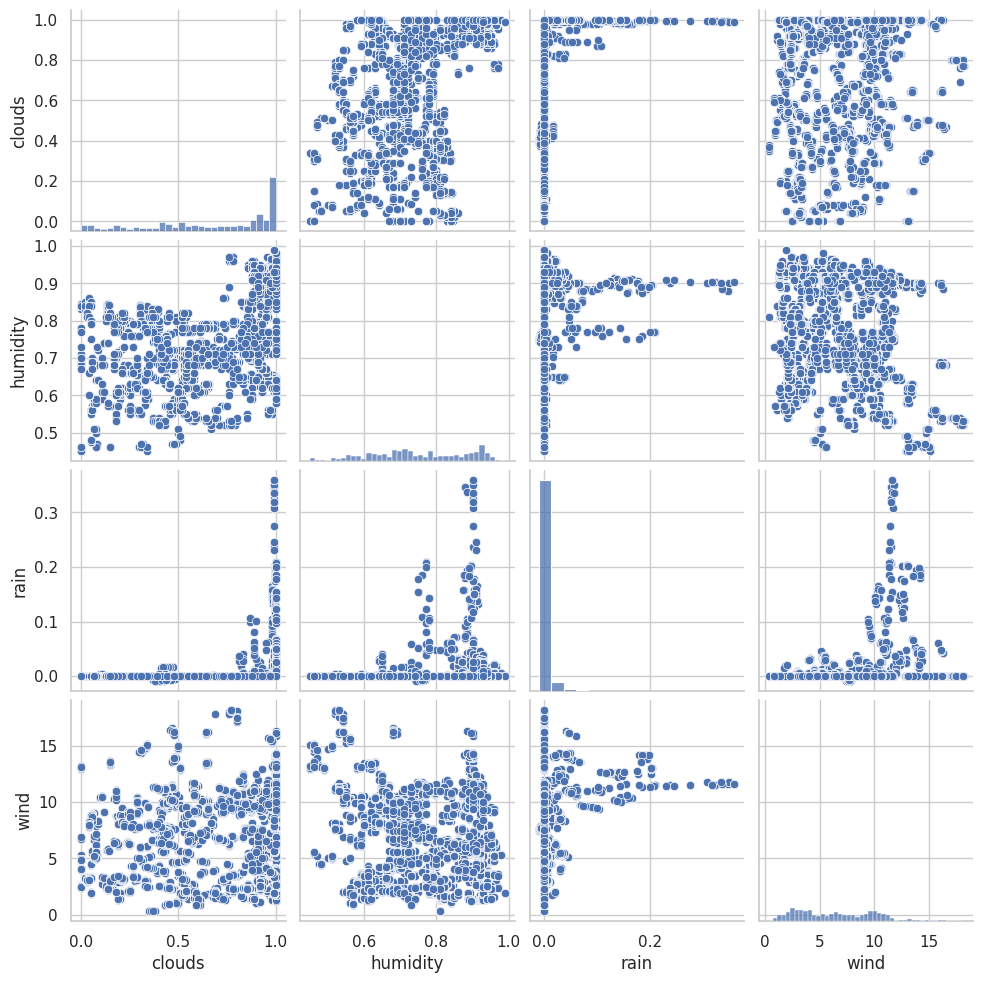

####Clusters Number

---
######**4 Clusters - Hierarchical**

In [ ]:
'''
hierarchical = cluster.AgglomerativeClustering(n_clusters=4, linkage='average', affinity = 'euclidean')
hierarchical.fit(df_combined[['clouds', 'humidity', 'rain', 'wind']])
C_h = hierarchical.labels_.astype(int)

sns.countplot(x=C_h)
C_h[:10]
'''

"\nhierarchical = cluster.AgglomerativeClustering(n_clusters=4, linkage='average', affinity = 'euclidean')\nhierarchical.fit(df_combined[['clouds', 'humidity', 'rain', 'wind']])\nC_h = hierarchical.labels_.astype(int)\n\nsns.countplot(x=C_h)\nC_h[:10]\n"

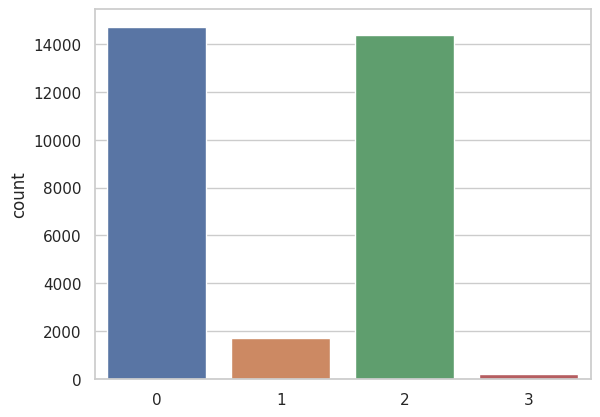

In [ ]:
#C_h = hierarchical.fit_predict(df_combined[['clouds', 'humidity', 'rain', 'wind']])

In [ ]:
'''
df_combined['Hierarchical'] = C_h
df_combined['Hierarchical'] = df_combined['Hierarchical'].astype('category')

# Plot the clustering result
g = sns.pairplot(df_combined[['clouds', 'humidity', 'rain', 'wind', 'Hierarchical']],
                 hue='Hierarchical', diag_kind="hist", palette="tab10")
'''

'\ndf_combined[\'Hierarchical\'] = C_h\ndf_combined[\'Hierarchical\'] = df_combined[\'Hierarchical\'].astype(\'category\')\n\n# Plot the clustering result\ng = sns.pairplot(df_combined[[\'clouds\', \'humidity\', \'rain\', \'wind\', \'Hierarchical\']],\n                 hue=\'Hierarchical\', diag_kind="hist", palette="tab10")\n'

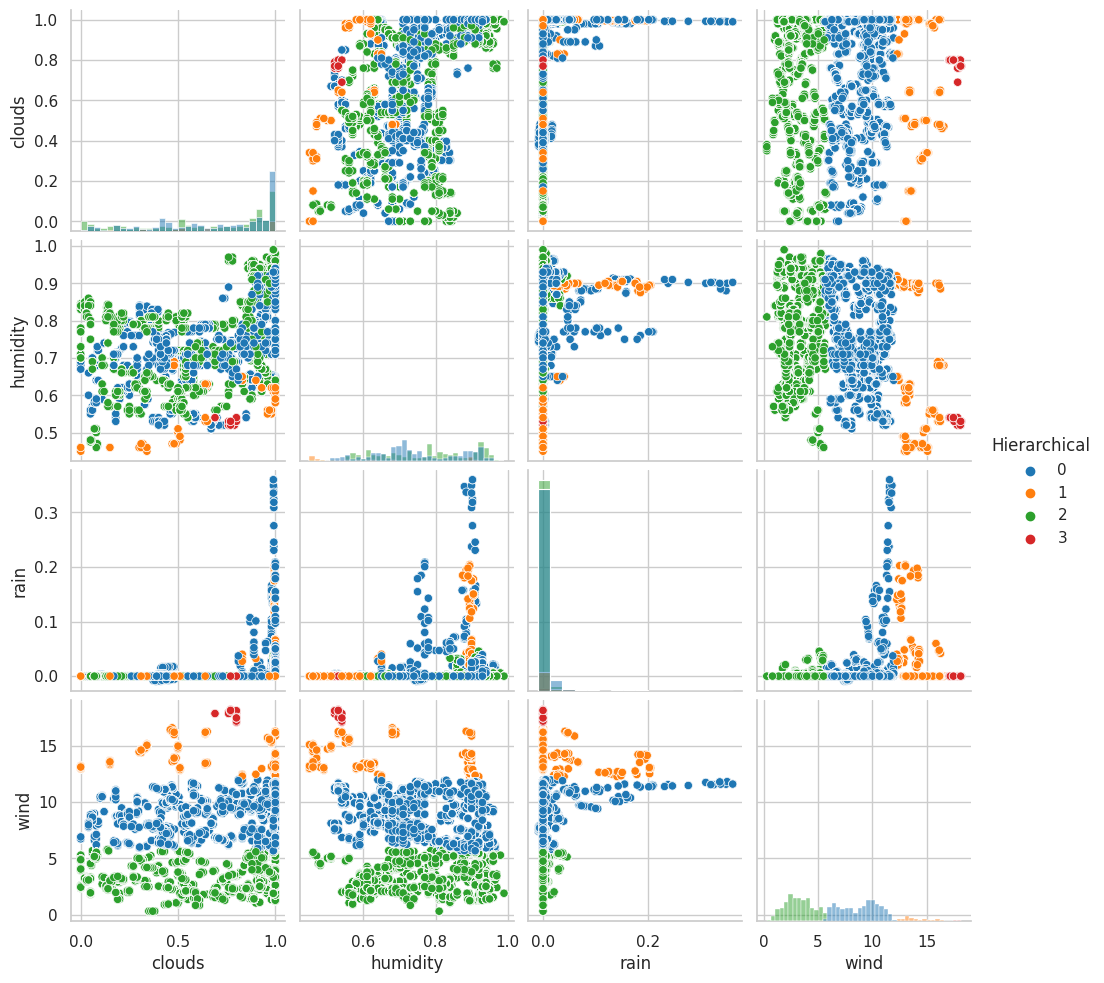

---
######**3 Clusters - Hierarchical**

In [ ]:
'''
hierarchical = cluster.AgglomerativeClustering(n_clusters=3, linkage='average', affinity = 'euclidean')
hierarchical.fit(df_combined[['clouds', 'humidity', 'rain', 'wind']])
C_h = hierarchical.labels_.astype(int)

sns.countplot(x=C_h)
C_h[:10]
'''

"\nhierarchical = cluster.AgglomerativeClustering(n_clusters=3, linkage='average', affinity = 'euclidean')\nhierarchical.fit(df_combined[['clouds', 'humidity', 'rain', 'wind']])\nC_h = hierarchical.labels_.astype(int)\n\nsns.countplot(x=C_h)\nC_h[:10]\n"

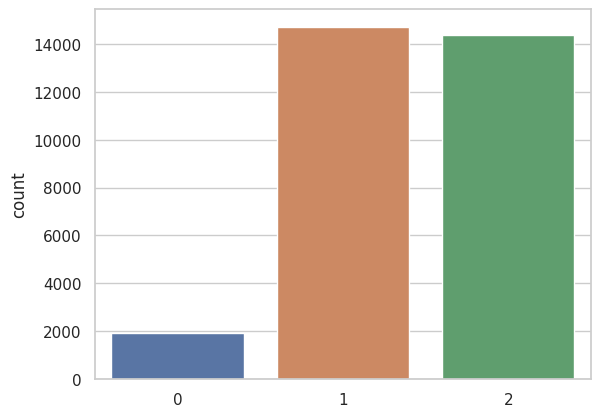

In [ ]:
#C_h = hierarchical.fit_predict(df_combined[['clouds', 'humidity', 'rain', 'wind']])

In [ ]:
'''
df_combined['Hierarchical'] = C_h
df_combined['Hierarchical'] = df_combined['Hierarchical'].astype('category')

# Plot the clustering result
g = sns.pairplot(df_combined[['clouds', 'humidity', 'rain', 'wind', 'Hierarchical']],
                 hue='Hierarchical', diag_kind="hist", palette="tab10")
'''

'\ndf_combined[\'Hierarchical\'] = C_h\ndf_combined[\'Hierarchical\'] = df_combined[\'Hierarchical\'].astype(\'category\')\n\n# Plot the clustering result\ng = sns.pairplot(df_combined[[\'clouds\', \'humidity\', \'rain\', \'wind\', \'Hierarchical\']],\n                 hue=\'Hierarchical\', diag_kind="hist", palette="tab10")\n'

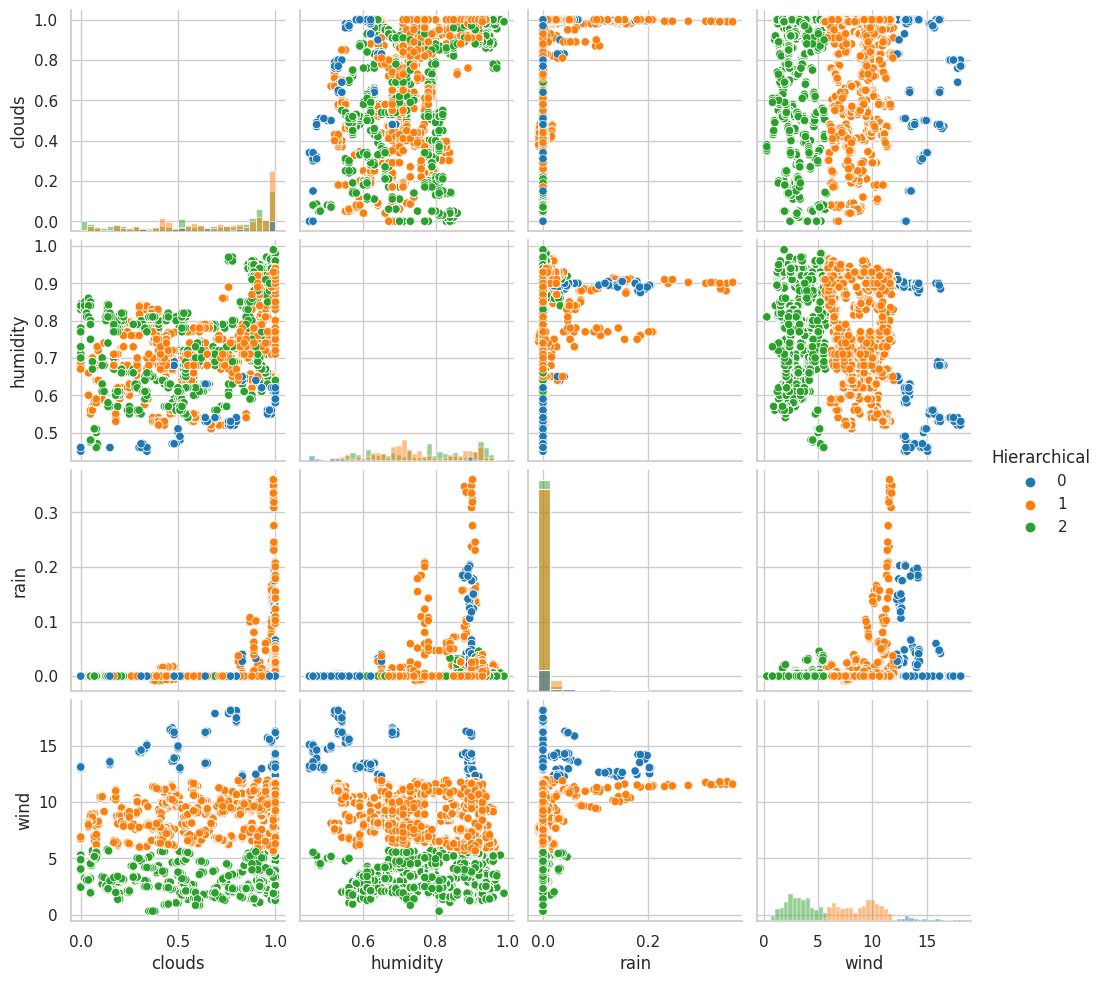

---
######**Finding Number of Clusters - Kmeans**

In [ ]:
'''
distorsions, k1, kN = [], 2, 10
for k in range(k1, kN):
    kmeans = cluster.KMeans(n_clusters=k, init='k-means++').fit(df_combined[['clouds', 'humidity', 'rain', 'wind']])
    distorsions.append(kmeans.inertia_)

plt.plot(range(k1, kN), distorsions); plt.grid(True)
plt.title('Elbow curve')
'''

"\ndistorsions, k1, kN = [], 2, 10\nfor k in range(k1, kN):\n    kmeans = cluster.KMeans(n_clusters=k, init='k-means++').fit(df_combined[['clouds', 'humidity', 'rain', 'wind']])\n    distorsions.append(kmeans.inertia_)\n\nplt.plot(range(k1, kN), distorsions); plt.grid(True)\nplt.title('Elbow curve')\n"

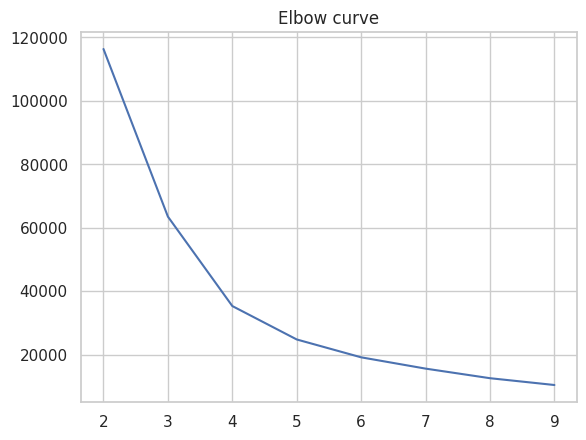

---
**4 Clusters Seems Good**

In [ ]:
'''
km = cluster.KMeans(n_clusters=4, init='k-means++', random_state = 0)
km.fit(df_combined[['clouds', 'humidity', 'rain', 'wind']])
# Hasil clusteringnya
C_km = km.predict(df_combined[['clouds', 'humidity', 'rain', 'wind']])
p= sns.countplot(x=C_km)
'''

"\nkm = cluster.KMeans(n_clusters=4, init='k-means++', random_state = 0)\nkm.fit(df_combined[['clouds', 'humidity', 'rain', 'wind']])\n# Hasil clusteringnya\nC_km = km.predict(df_combined[['clouds', 'humidity', 'rain', 'wind']])\np= sns.countplot(x=C_km)\n"

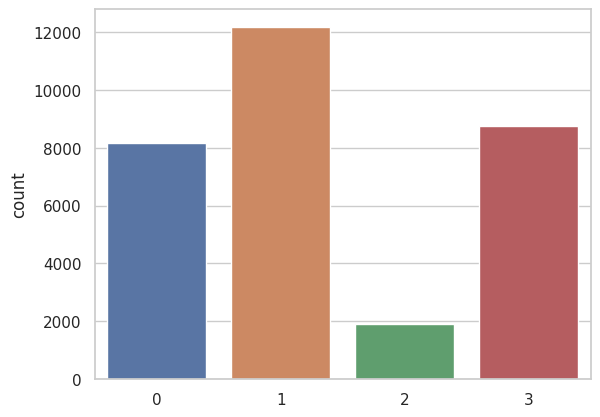

In [ ]:
'''
df_combined['k-means++'] = C_km
g = sns.pairplot(df_combined[['clouds', 'humidity', 'rain', 'wind', 'k-means++']], \
                 hue="k-means++", diag_kind="hist", palette="tab10")
'''

'\ndf_combined[\'k-means++\'] = C_km\ng = sns.pairplot(df_combined[[\'clouds\', \'humidity\', \'rain\', \'wind\', \'k-means++\']],                  hue="k-means++", diag_kind="hist", palette="tab10")\n'

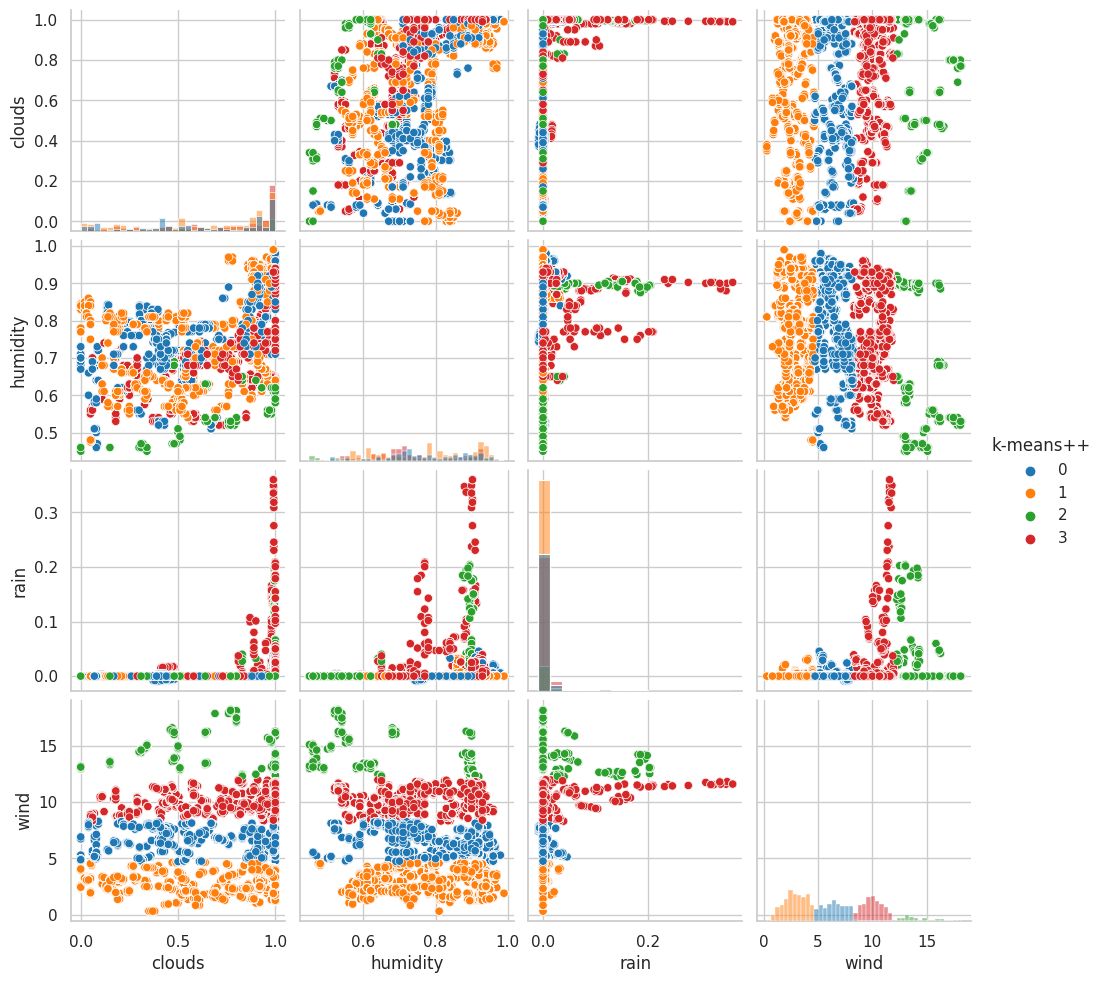

####Main Clustering

In [ ]:
'''
km = cluster.KMeans(n_clusters=4, init='k-means++', random_state = 0)
km.fit(df_combined[['clouds', 'humidity', 'rain', 'wind']])
# Hasil clusteringnya
C_km = km.predict(df_combined[['clouds', 'humidity', 'rain', 'wind']])

df_combined['k-means++'] = C_km
'''

"\nkm = cluster.KMeans(n_clusters=4, init='k-means++', random_state = 0)\nkm.fit(df_combined[['clouds', 'humidity', 'rain', 'wind']])\n# Hasil clusteringnya\nC_km = km.predict(df_combined[['clouds', 'humidity', 'rain', 'wind']])\n\ndf_combined['k-means++'] = C_km\n"

###Restoration

In [ ]:
'''
df_train_restored = df_combined.iloc[:train_end_index, :]
df_test_restored = df_combined.iloc[train_end_index:, :]
'''

'\ndf_train_restored = df_combined.iloc[:train_end_index, :]\ndf_test_restored = df_combined.iloc[train_end_index:, :]\n'

In [ ]:
#df_train_restored.isna().sum()

In [ ]:
#df_test_restored.drop(['price_mean'], axis=1, inplace=True)

In [ ]:
#df_train_restored.shape, df_test_restored.shape

In [ ]:
'''
df_test = df_test_restored
df_fill = df_train_restored
'''

'\ndf_test = df_test_restored\ndf_fill = df_train_restored\n'

In [ ]:
'''
df_test['k-means++'] = df_test['k-means++'].astype('category')
df_fill['k-means++'] = df_fill['k-means++'].astype('category')
'''

"\ndf_test['k-means++'] = df_test['k-means++'].astype('category')\ndf_fill['k-means++'] = df_fill['k-means++'].astype('category')\n"

In [ ]:
#df_test['k-means++'].unique()

In [ ]:
#df_fill['k-means++'].unique()

## Mean Price and Mean Distance Clustering

###Setting Up

from sklearn import cluster, datasets
from sklearn.metrics import silhouette_score as siluet
from sklearn.metrics.cluster import homogeneity_score as purity
from sklearn.metrics import normalized_mutual_info_score as NMI

dbscan = cluster.DBSCAN(eps=0.625, min_samples=5, metric='euclidean')
X = df_[['price_mean','distance_mean']] #.values
dbscan.fit(X)
C_db = dbscan.labels_.astype(int)
sns.countplot(x=C_db)
C_db[:10]

In [ ]:
'''
from sklearn import cluster, datasets
from sklearn.metrics import silhouette_score as siluet
from sklearn.metrics.cluster import homogeneity_score as purity
from sklearn.metrics import normalized_mutual_info_score as NMI

X = df_fill[['price_mean','distance_mean']] #.values
'''

"\nfrom sklearn import cluster, datasets\nfrom sklearn.metrics import silhouette_score as siluet\nfrom sklearn.metrics.cluster import homogeneity_score as purity\nfrom sklearn.metrics import normalized_mutual_info_score as NMI\n\nX = df_fill[['price_mean','distance_mean']] #.values\n"

Hirarki



```
# Hierarchical http://scikit-learn.org/stable/modules/generated/sklearn.cluster.AgglomerativeClustering.html#sklearn.cluster.AgglomerativeClustering
hierarchical = cluster.AgglomerativeClustering(n_clusters=4, linkage='average', affinity = 'euclidean')
hierarchical.fit(X) # Lambat .... dan menggunakan banyak memori O(N^2 log(N))
C_h = hierarchical.labels_.astype(int)

sns.countplot(x=C_h)
C_h[:10]
```



In [ ]:
'''
# Hierarchical http://scikit-learn.org/stable/modules/generated/sklearn.cluster.AgglomerativeClustering.html#sklearn.cluster.AgglomerativeClustering
hierarchical = cluster.AgglomerativeClustering(n_clusters=5, linkage='complete', affinity = 'euclidean')
hierarchical.fit(X) # Lambat .... dan menggunakan banyak memori O(N^2 log(N))
C_h = hierarchical.labels_.astype(int)

sns.countplot(x=C_h)
C_h[:10]
'''

"\n# Hierarchical http://scikit-learn.org/stable/modules/generated/sklearn.cluster.AgglomerativeClustering.html#sklearn.cluster.AgglomerativeClustering\nhierarchical = cluster.AgglomerativeClustering(n_clusters=5, linkage='complete', affinity = 'euclidean')\nhierarchical.fit(X) # Lambat .... dan menggunakan banyak memori O(N^2 log(N))\nC_h = hierarchical.labels_.astype(int)\n\nsns.countplot(x=C_h)\nC_h[:10]\n"



```
df_train['Hierarchical'] = C_h

# Plot the clustering result
g = sns.pairplot(df_train[['price_mean','distance_mean','Hierarchical']], \
                 hue="Hierarchical", diag_kind="hist", palette="tab10")
```



In [ ]:
#df_fill['label_distance'] = C_h

In [ ]:
'''
df_fill['label_distance'] = df_fill['label_distance'].apply(lambda x: 2 if x == 4 else x)

# Plot the clustering result
g = sns.pairplot(df_fill[['price_mean','distance_mean','label_distance']],
                 hue="label_distance", diag_kind="hist", palette="tab10")
'''

'\ndf_fill[\'label_distance\'] = df_fill[\'label_distance\'].apply(lambda x: 2 if x == 4 else x)\n\n# Plot the clustering result\ng = sns.pairplot(df_fill[[\'price_mean\',\'distance_mean\',\'label_distance\']],\n                 hue="label_distance", diag_kind="hist", palette="tab10")\n'

###Applying the Clustering

In [ ]:
#import tensorflow as tf

In [ ]:
'''
label_distmean = hierarchical.fit_predict(df_test)

df_test['label_distance'] = label_distmean
'''

"\nlabel_distmean = hierarchical.fit_predict(df_test)\n\ndf_test['label_distance'] = label_distmean\n"

In [ ]:
#sns.countplot(x=df_test['label_distance'])

In [ ]:
'''
# Plot
plt.figure(figsize=(60, 6))
sns.countplot(x='type', hue='label_distance', data=df_test)
plt.title('Count of combinations of label_distance and type')
plt.show()
'''

"\n# Plot\nplt.figure(figsize=(60, 6))\nsns.countplot(x='type', hue='label_distance', data=df_test)\nplt.title('Count of combinations of label_distance and type')\nplt.show()\n"

In [ ]:
#df_test['label_distance'] = df_test['label_distance'].apply(lambda x: 2 if x == 4 else x)

#Preprocessing Part 2

## Adding Interaction Terms

In [ ]:
df_fill.columns

Index(['api_calls', 'clouds', 'distance_max', 'distance_mean', 'distance_min',
       'humidity', 'price_mean', 'rain', 'surge_max', 'surge_mean',
       'surge_min', 'temp', 'wind', 'type', 'hour_sin', 'hour_cos', 'dm_sin',
       'dm_cos', 'dw_sin', 'dw_cos', 'humidity_cat', 'rain_cat', 'clouds_cat',
       'weather'],
      dtype='object')

In [ ]:
df_test.columns

Index(['api_calls', 'clouds', 'distance_max', 'distance_mean', 'distance_min',
       'humidity', 'rain', 'surge_max', 'surge_mean', 'surge_min', 'temp',
       'wind', 'type', 'hour_sin', 'hour_cos', 'dm_sin', 'dm_cos', 'dw_sin',
       'dw_cos', 'humidity_cat', 'rain_cat', 'clouds_cat', 'wind_cat',
       'weather'],
      dtype='object')

In [ ]:
df_train.shape, df_fill.shape, df_test.shape

((20006, 20), (20006, 24), (11040, 24))

In [ ]:
df_fill['surge_mean_hour_sin'] = df_fill['surge_mean'] * df_fill['hour_sin']
df_fill['surge_mean_hour_cos'] = df_fill['surge_mean'] * df_fill['hour_cos']
df_fill['surge_mean_dw_cos'] = df_fill['surge_mean'] * df_fill['dw_cos']
df_fill['surge_mean_sw_sin'] = df_fill['surge_mean'] * df_fill['dw_sin']

In [ ]:
df_fill['surge_max_hour_sin'] = df_fill['surge_max'] * df_fill['hour_sin']
df_fill['surge_max_hour_cos'] = df_fill['surge_max'] * df_fill['hour_cos']
df_fill['surge_max_dw_cos'] = df_fill['surge_max'] * df_fill['dw_cos']
df_fill['surge_max_sw_sin'] = df_fill['surge_max'] * df_fill['dw_sin']

In [ ]:
df_fill['surge_min_hour_sin'] = df_fill['surge_min'] * df_fill['hour_sin']
df_fill['surge_min_hour_cos'] = df_fill['surge_min'] * df_fill['hour_cos']
df_fill['surge_min_dw_cos'] = df_fill['surge_min'] * df_fill['dw_cos']
df_fill['surge_min_sw_sin'] = df_fill['surge_min'] * df_fill['dw_sin']

In [ ]:
df_fill['distance_mean_rain'] = df_fill['distance_mean'] * df_fill['rain']
df_fill['distance_max_rain'] = df_fill['distance_max'] * df_fill['rain']
df_fill['distance_min_rain'] = df_fill['distance_min'] * df_fill['rain']

In [ ]:
df_fill['rain_hour_sin'] = df_fill['hour_sin'] * df_fill['rain']
df_fill['rain_hour_cos'] = df_fill['hour_cos'] * df_fill['rain']

In [ ]:
df_fill['distance_mean_hour_cos'] = df_fill['hour_cos'] * df_fill['distance_mean']
df_fill['distance_max_hour_cos'] = df_fill['hour_cos'] * df_fill['distance_max']
df_fill['distance_min_hour_cos'] = df_fill['hour_cos'] * df_fill['distance_min']
df_fill['distance_mean_hour_sin'] = df_fill['hour_sin'] * df_fill['distance_mean']
df_fill['distance_max_hour_sin'] = df_fill['hour_sin'] * df_fill['distance_max']
df_fill['distance_min_hour_sin'] = df_fill['hour_sin'] * df_fill['distance_min']

In [ ]:
df_fill['distance_mean_hour_cos_rain'] = df_fill['hour_cos'] * df_fill['distance_mean'] *df_fill['rain']
df_fill['distance_max_hour_cos_rain'] = df_fill['hour_cos'] * df_fill['distance_max'] *df_fill['rain']
df_fill['distance_min_hour_cos_rain'] = df_fill['hour_cos'] * df_fill['distance_min'] *df_fill['rain']
df_fill['distance_mean_hour_sin_rain'] = df_fill['hour_sin'] * df_fill['distance_mean'] *df_fill['rain']
df_fill['distance_max_hour_sin_rain'] = df_fill['hour_sin'] * df_fill['distance_max'] *df_fill['rain']
df_fill['distance_min_hour_sin_rain'] = df_fill['hour_sin'] * df_fill['distance_min'] *df_fill['rain']

In [ ]:
df_fill.shape

(20006, 53)

In [ ]:
df_test['surge_mean_hour_sin'] = df_test['surge_mean'] * df_test['hour_sin']
df_test['surge_mean_hour_cos'] = df_test['surge_mean'] * df_test['hour_cos']
df_test['surge_mean_dw_cos'] = df_test['surge_mean'] * df_test['dw_cos']
df_test['surge_mean_sw_sin'] = df_test['surge_mean'] * df_test['dw_sin']

In [ ]:
df_test['surge_max_hour_sin'] = df_test['surge_max'] * df_test['hour_sin']
df_test['surge_max_hour_cos'] = df_test['surge_max'] * df_test['hour_cos']
df_test['surge_max_dw_cos'] = df_test['surge_max'] * df_test['dw_cos']
df_test['surge_max_sw_sin'] = df_test['surge_max'] * df_test['dw_sin']

In [ ]:
df_test['surge_min_hour_sin'] = df_test['surge_min'] * df_test['hour_sin']
df_test['surge_min_hour_cos'] = df_test['surge_min'] * df_test['hour_cos']
df_test['surge_min_dw_cos'] = df_test['surge_min'] * df_test['dw_cos']
df_test['surge_min_sw_sin'] = df_test['surge_min'] * df_test['dw_sin']

In [ ]:
df_test['distance_mean_rain'] = df_test['distance_mean'] * df_test['rain']
df_test['distance_max_rain'] = df_test['distance_max'] * df_test['rain']
df_test['distance_min_rain'] = df_test['distance_min'] * df_test['rain']

In [ ]:
df_test['rain_hour_sin'] = df_test['hour_sin'] * df_test['rain']
df_test['rain_hour_cos'] = df_test['hour_cos'] * df_test['rain']

In [ ]:
df_test['distance_mean_hour_cos'] = df_test['hour_cos'] * df_test['distance_mean']
df_test['distance_max_hour_cos'] = df_test['hour_cos'] * df_test['distance_max']
df_test['distance_min_hour_cos'] = df_test['hour_cos'] * df_test['distance_min']
df_test['distance_mean_hour_sin'] = df_test['hour_sin'] * df_test['distance_mean']
df_test['distance_max_hour_sin'] = df_test['hour_sin'] * df_test['distance_max']
df_test['distance_min_hour_sin'] = df_test['hour_sin'] * df_test['distance_min']

In [ ]:
df_test['distance_mean_hour_cos_rain'] = df_test['hour_cos'] * df_test['distance_mean'] *df_test['rain']
df_test['distance_max_hour_cos_rain'] = df_test['hour_cos'] * df_test['distance_max'] *df_test['rain']
df_test['distance_min_hour_cos_rain'] = df_test['hour_cos'] * df_test['distance_min'] *df_test['rain']
df_test['distance_mean_hour_sin_rain'] = df_test['hour_sin'] * df_test['distance_mean'] *df_test['rain']
df_test['distance_max_hour_sin_rain'] = df_test['hour_sin'] * df_test['distance_max'] *df_test['rain']
df_test['distance_min_hour_sin_rain'] = df_test['hour_sin'] * df_test['distance_min'] *df_test['rain']

##Normalization **+ including y** **||CURRENTLY PLAN TO NOT BEING USED||**

In [ ]:
df_test.dtypes

api_calls                       float64
clouds                          float64
distance_max                    float64
distance_mean                   float64
distance_min                    float64
humidity                        float64
rain                            float64
surge_max                       float64
surge_mean                      float64
surge_min                       float64
temp                            float64
wind                            float64
type                           category
hour_sin                        float64
hour_cos                        float64
dm_sin                          float64
dm_cos                          float64
dw_sin                          float64
dw_cos                          float64
humidity_cat                   category
rain_cat                       category
clouds_cat                     category
wind_cat                       category
weather                        category
surge_mean_hour_sin             float64


In [ ]:
df_fill.dtypes

api_calls                       float64
clouds                          float64
distance_max                    float64
distance_mean                   float64
distance_min                    float64
humidity                        float64
price_mean                      float64
rain                            float64
surge_max                       float64
surge_mean                      float64
surge_min                       float64
temp                            float64
wind                            float64
type                           category
hour_sin                        float64
hour_cos                        float64
dm_sin                          float64
dm_cos                          float64
dw_sin                          float64
dw_cos                          float64
humidity_cat                   category
rain_cat                       category
clouds_cat                     category
weather                        category
surge_mean_hour_sin             float64


In [ ]:
df_train['type'] = df_train['type'].astype('category')
df_test['type'] = df_test['type'].astype('category')
df_fill['type'] = df_fill['type'].astype('category')

'''
df_test['label_distance'] = df_test['label_distance'].astype('category')
df_fill['label_distance'] = df_fill['label_distance'].astype('category')
'''

"\ndf_test['label_distance'] = df_test['label_distance'].astype('category')\ndf_fill['label_distance'] = df_fill['label_distance'].astype('category')\n"

In [ ]:
df_fill['type'] = df_fill['type'].astype('int64')
df_fill['type'] = df_fill['type'].astype('category')
df_fill['type'].unique()

[0, 85, 8, 20, 54, ..., 21, 63, 82, 37, 49]
Length: 96
Categories (96, int64): [0, 1, 2, 3, ..., 92, 93, 94, 95]

In [ ]:
df_test['type'] = df_test['type'].astype('int64')
df_test['type'] = df_test['type'].astype('category')
df_test['type'].unique()

[0, 1, 2, 3, 4, ..., 91, 92, 93, 94, 95]
Length: 96
Categories (96, int64): [0, 1, 2, 3, ..., 92, 93, 94, 95]

In [ ]:
df_train['type'] = df_train['type'].astype('int64')
df_train['type'] = df_train['type'].astype('category')
df_train['type'].unique()

[0, 85, 8, 20, 54, ..., 21, 63, 82, 37, 49]
Length: 96
Categories (96, int64): [0, 1, 2, 3, ..., 92, 93, 94, 95]

In [ ]:
df_test.dtypes

api_calls                       float64
clouds                          float64
distance_max                    float64
distance_mean                   float64
distance_min                    float64
humidity                        float64
rain                            float64
surge_max                       float64
surge_mean                      float64
surge_min                       float64
temp                            float64
wind                            float64
type                           category
hour_sin                        float64
hour_cos                        float64
dm_sin                          float64
dm_cos                          float64
dw_sin                          float64
dw_cos                          float64
humidity_cat                   category
rain_cat                       category
clouds_cat                     category
wind_cat                       category
weather                        category
surge_mean_hour_sin             float64


In [ ]:
##Label X and y for regression
X1, y1 = df_train.drop(columns=['price_mean']), df_train.price_mean

In [ ]:
# Separate the DataFrame based on data types

X1_combined = pd.concat([X1, df_test], axis=0, ignore_index=True)
X_num = X1_combined.select_dtypes(include=['int', 'float'])
X_cat = X1_combined.select_dtypes(include=['category'])

In [ ]:
colname = X_num.columns

In [ ]:
y1.shape

(20006,)

In [ ]:
colname

Index(['api_calls', 'clouds', 'distance_max', 'distance_mean', 'distance_min',
       'humidity', 'rain', 'surge_max', 'surge_mean', 'surge_min', 'temp',
       'wind', 'hour_sin', 'hour_cos', 'dm_sin', 'dm_cos', 'dw_sin', 'dw_cos',
       'surge_mean_hour_sin', 'surge_mean_hour_cos', 'surge_mean_dw_cos',
       'surge_mean_sw_sin', 'surge_max_hour_sin', 'surge_max_hour_cos',
       'surge_max_dw_cos', 'surge_max_sw_sin', 'surge_min_hour_sin',
       'surge_min_hour_cos', 'surge_min_dw_cos', 'surge_min_sw_sin',
       'distance_mean_rain', 'distance_max_rain', 'distance_min_rain',
       'rain_hour_sin', 'rain_hour_cos', 'distance_mean_hour_cos',
       'distance_max_hour_cos', 'distance_min_hour_cos',
       'distance_mean_hour_sin', 'distance_max_hour_sin',
       'distance_min_hour_sin', 'distance_mean_hour_cos_rain',
       'distance_max_hour_cos_rain', 'distance_min_hour_cos_rain',
       'distance_mean_hour_sin_rain', 'distance_max_hour_sin_rain',
       'distance_min_hour_sin_ra

In [ ]:
'''
from sklearn.preprocessing import RobustScaler
transformer = RobustScaler().fit(X_num)
transformer
RobustScaler()
X_num=transformer.transform(X_num)

transformer2 = RobustScaler().fit(np.array(y1).reshape(-1, 1))
transformer2
RobustScaler()
y1=transformer2.transform(np.array(y1).reshape(-1, 1))
'''

'\nfrom sklearn.preprocessing import RobustScaler\ntransformer = RobustScaler().fit(X_num)\ntransformer\nRobustScaler()\nX_num=transformer.transform(X_num)\n\ntransformer2 = RobustScaler().fit(np.array(y1).reshape(-1, 1))\ntransformer2\nRobustScaler()\ny1=transformer2.transform(np.array(y1).reshape(-1, 1))\n'

In [ ]:
#y1.reshape(20064, ).shape

In [ ]:
X_num = pd.DataFrame(X_num)
X_num.columns = colname

In [ ]:
X_cat

type humidity_cat rain_cat clouds_cat wind_cat weather
0        0          NaN      NaN        NaN      NaN     NaN
1       85          NaN      NaN        NaN      NaN     NaN
2        8          NaN      NaN        NaN      NaN     NaN
3       20          NaN      NaN        NaN      NaN     NaN
4       54          NaN      NaN        NaN      NaN     NaN
...    ...          ...      ...        ...      ...     ...
31041   95          low       No        low     high   clear
31042   95          low       No        low     high   clear
31043   95          low       No        low     high   clear
31044   95          low       No        low     high   clear
31045   95          low       No        low     high   clear

[31046 rows x 6 columns]

In [ ]:
X_num.tail()

api_calls  clouds  distance_max  distance_mean  distance_min  humidity  \
31041       11.0    0.48          3.08       2.024545          0.72      0.47   
31042       16.0    0.34          3.20       2.002500          0.72      0.46   
31043        7.0    0.31          3.08       2.105714          0.72      0.47   
31044        8.0    0.15          3.20       1.952500          0.72      0.46   
31045        9.0    0.00          3.15       2.721111          1.06      0.46   

       rain  surge_max  surge_mean  surge_min  ...  distance_min_hour_cos  \
31041   0.0        1.0         1.0        1.0  ...          -6.235383e-01   
31042   0.0        1.0         1.0        1.0  ...          -5.091169e-01   
31043   0.0        1.0         1.0        1.0  ...          -3.600000e-01   
31044   0.0        1.0         1.0        1.0  ...          -1.863497e-01   
31045   0.0        1.0         1.0        1.0  ...          -1.947188e-16   

       distance_mean_hour_sin  distance_max_hour_sin  distance_min_hour_sin  \
31041               -1.012273              -1.540000              -0.360000   
31042               -1.415981              -2.262742              -0.509117   
31043               -1.823602              -2.667358              -0.623538   
31044               -1.885970              -3.090963              -0.695467   
31045               -2.721111              -3.150000              -1.060000   

       distance_mean_hour_cos_rain  distance_max_hour_cos_rain  \
31041                         -0.0                        -0.0   
31042                         -0.0                        -0.0   
31043                         -0.0                        -0.0   
31044                         -0.0                        -0.0   
31045                         -0.0                        -0.0   

       distance_min_hour_cos_rain  distance_mean_hour_sin_rain  \
31041                        -0.0                         -0.0   
31042                        -0.0                         -0.0   
31043                        -0.0                         -0.0   
31044                        -0.0                         -0.0   
31045                        -0.0                         -0.0   

       distance_max_hour_sin_rain  distance_min_hour_sin_rain  
31041                        -0.0                        -0.0  
31042                        -0.0                        -0.0  
31043                        -0.0                        -0.0  
31044                        -0.0                        -0.0  
31045                        -0.0                        -0.0  

[5 rows x 47 columns]

In [ ]:
X1 = pd.concat([X_num, X_cat], axis=1)
X1

api_calls    clouds  distance_max  distance_mean  distance_min  \
0            9.0  0.990667          3.03       1.726667          1.04   
1           11.0  0.990667          2.48       2.184545          1.35   
2            6.0  0.990667          4.03       2.893333          1.27   
3            8.0  0.990667          3.24       2.193750          1.27   
4            7.0  0.990667          2.80       1.502857          1.13   
...          ...       ...           ...            ...           ...   
31041       11.0  0.480000          3.08       2.024545          0.72   
31042       16.0  0.340000          3.20       2.002500          0.72   
31043        7.0  0.310000          3.08       2.105714          0.72   
31044        8.0  0.150000          3.20       1.952500          0.72   
31045        9.0  0.000000          3.15       2.721111          1.06   

       humidity  rain  surge_max  surge_mean  surge_min  ...  \
0      0.913333   0.0       1.50    1.055556        1.0  ...   
1      0.913333   0.0       1.00    1.000000        1.0  ...   
2      0.920000   0.0       1.50    1.166667        1.0  ...   
3      0.920000   0.0       1.25    1.062500        1.0  ...   
4      0.913333   0.0       1.00    1.000000        1.0  ...   
...         ...   ...        ...         ...        ...  ...   
31041  0.470000   0.0       1.00    1.000000        1.0  ...   
31042  0.460000   0.0       1.00    1.000000        1.0  ...   
31043  0.470000   0.0       1.00    1.000000        1.0  ...   
31044  0.460000   0.0       1.00    1.000000        1.0  ...   
31045  0.460000   0.0       1.00    1.000000        1.0  ...   

       distance_min_hour_cos_rain  distance_mean_hour_sin_rain  \
0                             NaN                          NaN   
1                             NaN                          NaN   
2                             NaN                          NaN   
3                             NaN                          NaN   
4                             NaN                          NaN   
...                           ...                          ...   
31041                        -0.0                         -0.0   
31042                        -0.0                         -0.0   
31043                        -0.0                         -0.0   
31044                        -0.0                         -0.0   
31045                        -0.0                         -0.0   

       distance_max_hour_sin_rain  distance_min_hour_sin_rain  type  \
0                             NaN                         NaN     0   
1                             NaN                         NaN    85   
2                             NaN                         NaN     8   
3                             NaN                         NaN    20   
4                             NaN                         NaN    54   
...                           ...                         ...   ...   
31041                        -0.0                        -0.0    95   
31042                        -0.0                        -0.0    95   
31043                        -0.0                        -0.0    95   
31044                        -0.0                        -0.0    95   
31045                        -0.0                        -0.0    95   

       humidity_cat  rain_cat  clouds_cat  wind_cat  weather  
0               NaN       NaN         NaN       NaN      NaN  
1               NaN       NaN         NaN       NaN      NaN  
2               NaN       NaN         NaN       NaN      NaN  
3               NaN       NaN         NaN       NaN      NaN  
4               NaN       NaN         NaN       NaN      NaN  
...             ...       ...         ...       ...      ...  
31041           low        No         low      high    clear  
31042           low        No         low      high    clear  
31043           low        No         low      high    clear  
31044           low        No         low      high    clear  
31045           low   

In [ ]:
X1.isna().sum()

api_calls                          0
clouds                           192
distance_max                       0
distance_mean                      0
distance_min                       0
humidity                         192
rain                             192
surge_max                          0
surge_mean                         0
surge_min                          0
temp                             192
wind                             192
hour_sin                           0
hour_cos                           0
dm_sin                             0
dm_cos                             0
dw_sin                             0
dw_cos                             0
surge_mean_hour_sin            20006
surge_mean_hour_cos            20006
surge_mean_dw_cos              20006
surge_mean_sw_sin              20006
surge_max_hour_sin             20006
surge_max_hour_cos             20006
surge_max_dw_cos               20006
surge_max_sw_sin               20006
surge_min_hour_sin             20006
s

In [ ]:
split_index = len(df_train)
df_test_1 = X1[split_index:]
X1 = X1.iloc[:split_index]

In [ ]:
df_test_1.shape

(11040, 53)

In [ ]:
X1.shape

(20006, 53)

In [ ]:
##Label X and y for regression
X2, y2 = df_fill.drop(columns=['price_mean']), df_fill.price_mean

In [ ]:
X2.isna().sum()

api_calls                      0
clouds                         0
distance_max                   0
distance_mean                  0
distance_min                   0
humidity                       0
rain                           0
surge_max                      0
surge_mean                     0
surge_min                      0
temp                           0
wind                           0
type                           0
hour_sin                       0
hour_cos                       0
dm_sin                         0
dm_cos                         0
dw_sin                         0
dw_cos                         0
humidity_cat                   0
rain_cat                       0
clouds_cat                     0
weather                        0
surge_mean_hour_sin            0
surge_mean_hour_cos            0
surge_mean_dw_cos              0
surge_mean_sw_sin              0
surge_max_hour_sin             0
surge_max_hour_cos             0
surge_max_dw_cos               0
surge_max_

In [ ]:
X2.dtypes

api_calls                       float64
clouds                          float64
distance_max                    float64
distance_mean                   float64
distance_min                    float64
humidity                        float64
rain                            float64
surge_max                       float64
surge_mean                      float64
surge_min                       float64
temp                            float64
wind                            float64
type                           category
hour_sin                        float64
hour_cos                        float64
dm_sin                          float64
dm_cos                          float64
dw_sin                          float64
dw_cos                          float64
humidity_cat                   category
rain_cat                       category
clouds_cat                     category
weather                        category
surge_mean_hour_sin             float64
surge_mean_hour_cos             float64


In [ ]:
X2.shape

(20006, 52)

In [ ]:
# Separate the DataFrame based on data types
X2_combined = pd.concat([X2, df_test], axis=0, ignore_index=True)
'''
X2_combined['label_distance'] = X2_combined['label_distance'].astype('int64')
X2_combined['label_distance'] = X2_combined['label_distance'].astype('category')
'''
X_num = X2_combined.select_dtypes(include=['int', 'float'])
X_cat = X2_combined.select_dtypes(include=['category'])

In [ ]:
X2_combined.dtypes

api_calls                       float64
clouds                          float64
distance_max                    float64
distance_mean                   float64
distance_min                    float64
humidity                        float64
rain                            float64
surge_max                       float64
surge_mean                      float64
surge_min                       float64
temp                            float64
wind                            float64
type                           category
hour_sin                        float64
hour_cos                        float64
dm_sin                          float64
dm_cos                          float64
dw_sin                          float64
dw_cos                          float64
humidity_cat                   category
rain_cat                       category
clouds_cat                     category
weather                        category
surge_mean_hour_sin             float64
surge_mean_hour_cos             float64


In [ ]:
colname = X_num.columns

In [ ]:
y2.shape

(20006,)

In [ ]:
y2

0        16.555556
1        28.227273
2        23.250000
3        22.250000
4        12.785714
           ...    
20001     9.678571
20002    20.909091
20003    10.535714
20004    31.777778
20005    24.041667
Name: price_mean, Length: 20006, dtype: float64

In [ ]:
'''
from sklearn.preprocessing import RobustScaler
transformer3 = RobustScaler().fit(X_num)
transformer3
RobustScaler()
X_num=transformer3.transform(X_num)

transformer4 = RobustScaler().fit(np.array(y2).reshape(-1, 1))
transformer4
RobustScaler()
y2=transformer4.transform(np.array(y2).reshape(-1, 1))
'''

'\nfrom sklearn.preprocessing import RobustScaler\ntransformer3 = RobustScaler().fit(X_num)\ntransformer3\nRobustScaler()\nX_num=transformer3.transform(X_num)\n\ntransformer4 = RobustScaler().fit(np.array(y2).reshape(-1, 1))\ntransformer4\nRobustScaler()\ny2=transformer4.transform(np.array(y2).reshape(-1, 1))\n'

In [ ]:
#y2.reshape(20064, ).shape

In [ ]:
X_num = pd.DataFrame(X_num)
X_num.columns = colname

In [ ]:
X_num.tail()

api_calls  clouds  distance_max  distance_mean  distance_min  humidity  \
31041       11.0    0.48          3.08       2.024545          0.72      0.47   
31042       16.0    0.34          3.20       2.002500          0.72      0.46   
31043        7.0    0.31          3.08       2.105714          0.72      0.47   
31044        8.0    0.15          3.20       1.952500          0.72      0.46   
31045        9.0    0.00          3.15       2.721111          1.06      0.46   

       rain  surge_max  surge_mean  surge_min  ...  distance_min_hour_cos  \
31041   0.0        1.0         1.0        1.0  ...          -6.235383e-01   
31042   0.0        1.0         1.0        1.0  ...          -5.091169e-01   
31043   0.0        1.0         1.0        1.0  ...          -3.600000e-01   
31044   0.0        1.0         1.0        1.0  ...          -1.863497e-01   
31045   0.0        1.0         1.0        1.0  ...          -1.947188e-16   

       distance_mean_hour_sin  distance_max_hour_sin  distance_min_hour_sin  \
31041               -1.012273              -1.540000              -0.360000   
31042               -1.415981              -2.262742              -0.509117   
31043               -1.823602              -2.667358              -0.623538   
31044               -1.885970              -3.090963              -0.695467   
31045               -2.721111              -3.150000              -1.060000   

       distance_mean_hour_cos_rain  distance_max_hour_cos_rain  \
31041                         -0.0                        -0.0   
31042                         -0.0                        -0.0   
31043                         -0.0                        -0.0   
31044                         -0.0                        -0.0   
31045                         -0.0                        -0.0   

       distance_min_hour_cos_rain  distance_mean_hour_sin_rain  \
31041                        -0.0                         -0.0   
31042                        -0.0                         -0.0   
31043                        -0.0                         -0.0   
31044                        -0.0                         -0.0   
31045                        -0.0                         -0.0   

       distance_max_hour_sin_rain  distance_min_hour_sin_rain  
31041                        -0.0                        -0.0  
31042                        -0.0                        -0.0  
31043                        -0.0                        -0.0  
31044                        -0.0                        -0.0  
31045                        -0.0                        -0.0  

[5 rows x 47 columns]

In [ ]:
X_cat = X_cat.reset_index(drop=True)
X_cat.tail()

type humidity_cat rain_cat clouds_cat weather wind_cat
31041   95          low       No        low   clear     high
31042   95          low       No        low   clear     high
31043   95          low       No        low   clear     high
31044   95          low       No        low   clear     high
31045   95          low       No        low   clear     high

In [ ]:
X2 = pd.concat([X_num, X_cat], axis=1)
X2

api_calls    clouds  distance_max  distance_mean  distance_min  \
0            9.0  0.990667          3.03       1.726667          1.04   
1           11.0  0.990667          2.48       2.184545          1.35   
2            6.0  0.990667          4.03       2.893333          1.27   
3            8.0  0.990667          3.24       2.193750          1.27   
4            7.0  0.990667          2.80       1.502857          1.13   
...          ...       ...           ...            ...           ...   
31041       11.0  0.480000          3.08       2.024545          0.72   
31042       16.0  0.340000          3.20       2.002500          0.72   
31043        7.0  0.310000          3.08       2.105714          0.72   
31044        8.0  0.150000          3.20       1.952500          0.72   
31045        9.0  0.000000          3.15       2.721111          1.06   

       humidity  rain  surge_max  surge_mean  surge_min  ...  \
0      0.913333   0.0       1.50    1.055556        1.0  ...   
1      0.913333   0.0       1.00    1.000000        1.0  ...   
2      0.920000   0.0       1.50    1.166667        1.0  ...   
3      0.920000   0.0       1.25    1.062500        1.0  ...   
4      0.913333   0.0       1.00    1.000000        1.0  ...   
...         ...   ...        ...         ...        ...  ...   
31041  0.470000   0.0       1.00    1.000000        1.0  ...   
31042  0.460000   0.0       1.00    1.000000        1.0  ...   
31043  0.470000   0.0       1.00    1.000000        1.0  ...   
31044  0.460000   0.0       1.00    1.000000        1.0  ...   
31045  0.460000   0.0       1.00    1.000000        1.0  ...   

       distance_min_hour_cos_rain  distance_mean_hour_sin_rain  \
0                             0.0                          0.0   
1                             0.0                          0.0   
2                             0.0                          0.0   
3                             0.0                          0.0   
4                             0.0                          0.0   
...                           ...                          ...   
31041                        -0.0                         -0.0   
31042                        -0.0                         -0.0   
31043                        -0.0                         -0.0   
31044                        -0.0                         -0.0   
31045                        -0.0                         -0.0   

       distance_max_hour_sin_rain  distance_min_hour_sin_rain  type  \
0                             0.0                         0.0     0   
1                             0.0                         0.0    85   
2                             0.0                         0.0     8   
3                             0.0                         0.0    20   
4                             0.0                         0.0    54   
...                           ...                         ...   ...   
31041                        -0.0                        -0.0    95   
31042                        -0.0                        -0.0    95   
31043                        -0.0                        -0.0    95   
31044                        -0.0                        -0.0    95   
31045                        -0.0                        -0.0    95   

       humidity_cat  rain_cat  clouds_cat  weather  wind_cat  
0              high        No        high   cloudy       NaN  
1              high        No        high   cloudy       NaN  
2              high        No        high   cloudy       NaN  
3              high        No        high   cloudy       NaN  
4              high        No        high   cloudy       NaN  
...             ...       ...         ...      ...       ...  
31041           low        No         low    clear      high  
31042           low        No         low    clear      high  
31043           low        No         low    clear      high  
31044           low        No         low    clear      high  
31045           low   

In [ ]:
split_index = len(df_train)
df_test_2 = X2[split_index:]
X2 = X2.iloc[:split_index]

In [ ]:
df_test_2.shape

(11040, 53)

In [ ]:
X2.shape

(20006, 53)

In [ ]:
X2.isna().sum()

api_calls                          0
clouds                             0
distance_max                       0
distance_mean                      0
distance_min                       0
humidity                           0
rain                               0
surge_max                          0
surge_mean                         0
surge_min                          0
temp                               0
wind                               0
hour_sin                           0
hour_cos                           0
dm_sin                             0
dm_cos                             0
dw_sin                             0
dw_cos                             0
surge_mean_hour_sin                0
surge_mean_hour_cos                0
surge_mean_dw_cos                  0
surge_mean_sw_sin                  0
surge_max_hour_sin                 0
surge_max_hour_cos                 0
surge_max_dw_cos                   0
surge_max_sw_sin                   0
surge_min_hour_sin                 0
s

___
**X1 and y1 is from df_train which still have missing values. While X2 and y2 is from df_fill, which has been filled(imputed). Adjust it to your corresponding model.**

**df_test1 and df_test2 are their counterpart.**

---
#**You're Now Entering the Modelling Zone**
---


#LGBM

##Embedding

###Tensorflow Keras Embedding (Don't run if Embedding is a no no)

####Specific Preparation

In [ ]:
import tensorflow as tf

In [ ]:
X2['type'].unique()

[0, 85, 8, 20, 54, ..., 21, 63, 82, 37, 49]
Length: 96
Categories (96, int64): [0, 1, 2, 3, ..., 92, 93, 94, 95]

In [ ]:
X2.head()

api_calls    clouds  distance_max  distance_mean  distance_min  humidity  \
0        9.0  0.990667          3.03       1.726667          1.04  0.913333   
1       11.0  0.990667          2.48       2.184545          1.35  0.913333   
2        6.0  0.990667          4.03       2.893333          1.27  0.920000   
3        8.0  0.990667          3.24       2.193750          1.27  0.920000   
4        7.0  0.990667          2.80       1.502857          1.13  0.913333   

   rain  surge_max  surge_mean  surge_min  ...  distance_min_hour_cos_rain  \
0   0.0       1.50    1.055556        1.0  ...                         0.0   
1   0.0       1.00    1.000000        1.0  ...                         0.0   
2   0.0       1.50    1.166667        1.0  ...                         0.0   
3   0.0       1.25    1.062500        1.0  ...                         0.0   
4   0.0       1.00    1.000000        1.0  ...                         0.0   

   distance_mean_hour_sin_rain  distance_max_hour_sin_rain  \
0                          0.0                         0.0   
1                          0.0                         0.0   
2                          0.0                         0.0   
3                          0.0                         0.0   
4                          0.0                         0.0   

   distance_min_hour_sin_rain  type  humidity_cat  rain_cat  clouds_cat  \
0                         0.0     0          high        No        high   
1                         0.0    85          high        No        high   
2                         0.0     8          high        No        high   
3                         0.0    20          high        No        high   
4                         0.0    54          high        No        high   

   weather  wind_cat  
0   cloudy       NaN  
1   cloudy       NaN  
2   cloudy       NaN  
3   cloudy       NaN  
4   cloudy       NaN  

[5 rows x 53 columns]

In [ ]:
X2 = X2[X2.columns[-7:].tolist() + X2.columns[:-7].tolist()]
X2.dtypes

distance_min_hour_sin_rain      float64
type                           category
humidity_cat                   category
rain_cat                       category
clouds_cat                     category
weather                        category
wind_cat                       category
api_calls                       float64
clouds                          float64
distance_max                    float64
distance_mean                   float64
distance_min                    float64
humidity                        float64
rain                            float64
surge_max                       float64
surge_mean                      float64
surge_min                       float64
temp                            float64
wind                            float64
hour_sin                        float64
hour_cos                        float64
dm_sin                          float64
dm_cos                          float64
dw_sin                          float64
dw_cos                          float64


In [ ]:
def df_column_switch(df, column1, column2):
    i = list(df.columns)
    a, b = i.index(column1), i.index(column2)
    i[b], i[a] = i[a], i[b]
    df = df[i]
    return df

#X2 = df_column_switch(X2, 'k-means++', 'day_of_week_cat')

In [ ]:
#X2['k-means++'].unique()

In [ ]:
X2.dtypes

distance_min_hour_sin_rain      float64
type                           category
humidity_cat                   category
rain_cat                       category
clouds_cat                     category
weather                        category
wind_cat                       category
api_calls                       float64
clouds                          float64
distance_max                    float64
distance_mean                   float64
distance_min                    float64
humidity                        float64
rain                            float64
surge_max                       float64
surge_mean                      float64
surge_min                       float64
temp                            float64
wind                            float64
hour_sin                        float64
hour_cos                        float64
dm_sin                          float64
dm_cos                          float64
dw_sin                          float64
dw_cos                          float64


In [ ]:
df_test_2 = df_test_2[df_test_2.columns[-7:].tolist() + df_test_2.columns[:-7].tolist()]
df_test_2.dtypes

distance_min_hour_sin_rain      float64
type                           category
humidity_cat                   category
rain_cat                       category
clouds_cat                     category
weather                        category
wind_cat                       category
api_calls                       float64
clouds                          float64
distance_max                    float64
distance_mean                   float64
distance_min                    float64
humidity                        float64
rain                            float64
surge_max                       float64
surge_mean                      float64
surge_min                       float64
temp                            float64
wind                            float64
hour_sin                        float64
hour_cos                        float64
dm_sin                          float64
dm_cos                          float64
dw_sin                          float64
dw_cos                          float64


In [ ]:
#df_test_2 = df_column_switch(df_test_2, 'k-means++', 'day_of_week_cat')

In [ ]:
df_test_2.dtypes

distance_min_hour_sin_rain      float64
type                           category
humidity_cat                   category
rain_cat                       category
clouds_cat                     category
weather                        category
wind_cat                       category
api_calls                       float64
clouds                          float64
distance_max                    float64
distance_mean                   float64
distance_min                    float64
humidity                        float64
rain                            float64
surge_max                       float64
surge_mean                      float64
surge_min                       float64
temp                            float64
wind                            float64
hour_sin                        float64
hour_cos                        float64
dm_sin                          float64
dm_cos                          float64
dw_sin                          float64
dw_cos                          float64


In [ ]:
from sklearn.model_selection import train_test_split
#X2_dum = X2.copy()
X2_dum = pd.get_dummies(X2, drop_first=True)
X2_train, X2_test, y2_train, y2_test = train_test_split(X2_dum, y2, test_size=0.25, random_state=69)

In [ ]:
X2_dum.isna().sum()

distance_min_hour_sin_rain    0
api_calls                     0
clouds                        0
distance_max                  0
distance_mean                 0
                             ..
clouds_cat_high               0
weather_cloudy                0
weather_rainy                 0
wind_cat_medium               0
wind_cat_high                 0
Length: 151, dtype: int64

In [ ]:
X2_train.shape, X2_test.shape

((15004, 151), (5002, 151))

In [ ]:
tf.random.set_seed(66)

In [ ]:
from sklearn.model_selection import KFold

In [ ]:
X2_dum1 = np.array(X2_dum)
y21 = np.array(y2)

In [ ]:
#X2['k-means++'].unique()

In [ ]:
X2['humidity'].describe()

count    20006.000000
mean         0.749084
std          0.137490
min          0.460000
25%          0.630000
50%          0.730000
75%          0.890000
max          0.990000
Name: humidity, dtype: float64

In [ ]:
X2['type'] = X2['type'].astype('int64')
df_test_2['type'] = df_test_2['type'].astype('int64')

'''
mapping_dict = {"low": 0, "medium": 1, "high": 2}

X2['humidity_cat'] = X2['humidity_cat'].map(mapping_dict)
X2['clouds_cat'] = X2['clouds_cat'].map(mapping_dict)
df_test_2['humidity_cat'] = df_test_2['humidity_cat'].map(mapping_dict)
df_test_2['clouds_cat'] = df_test_2['clouds_cat'].map(mapping_dict)

X2['humidity_cat'] = X2['humidity_cat'].astype('int64')
df_test_2['humidity_cat'] = df_test_2['humidity_cat'].astype('int64')
X2['clouds_cat'] = X2['clouds_cat'].astype('int64')
df_test_2['clouds_cat'] = df_test_2['clouds_cat'].astype('int64')


X2['day_of_week_cat'] = X2['day_of_week_cat'].astype('int64')
df_test_2['day_of_week_cat'] = df_test_2['day_of_week_cat'].astype('int64')
X2['hour_cat'] = X2['hour_cat'].astype('int64')
df_test_2['hour_cat'] = df_test_2['hour_cat'].astype('int64')


X2['k-means++'] = X2['k-means++'].astype('int64')
df_test_2['k-means++'] = df_test_2['k-means++'].astype('int64')
X2['day_of_week_cat'] = X2['day_of_week_cat'].astype('int64')
X2['hour_cat'] = X2['hour_cat'].astype('int64')
'''

'\nmapping_dict = {"low": 0, "medium": 1, "high": 2}\n\nX2[\'humidity_cat\'] = X2[\'humidity_cat\'].map(mapping_dict)\nX2[\'clouds_cat\'] = X2[\'clouds_cat\'].map(mapping_dict)\ndf_test_2[\'humidity_cat\'] = df_test_2[\'humidity_cat\'].map(mapping_dict)\ndf_test_2[\'clouds_cat\'] = df_test_2[\'clouds_cat\'].map(mapping_dict)\n\nX2[\'humidity_cat\'] = X2[\'humidity_cat\'].astype(\'int64\')\ndf_test_2[\'humidity_cat\'] = df_test_2[\'humidity_cat\'].astype(\'int64\')\nX2[\'clouds_cat\'] = X2[\'clouds_cat\'].astype(\'int64\')\ndf_test_2[\'clouds_cat\'] = df_test_2[\'clouds_cat\'].astype(\'int64\')\n\n\nX2[\'day_of_week_cat\'] = X2[\'day_of_week_cat\'].astype(\'int64\')\ndf_test_2[\'day_of_week_cat\'] = df_test_2[\'day_of_week_cat\'].astype(\'int64\')\nX2[\'hour_cat\'] = X2[\'hour_cat\'].astype(\'int64\')\ndf_test_2[\'hour_cat\'] = df_test_2[\'hour_cat\'].astype(\'int64\')\n\n\nX2[\'k-means++\'] = X2[\'k-means++\'].astype(\'int64\')\ndf_test_2[\'k-means++\'] = df_test_2[\'k-means++\'].astyp

In [ ]:
X2.isna().sum()

distance_min_hour_sin_rain         0
type                               0
humidity_cat                       0
rain_cat                           0
clouds_cat                         0
weather                            0
wind_cat                       20006
api_calls                          0
clouds                             0
distance_max                       0
distance_mean                      0
distance_min                       0
humidity                           0
rain                               0
surge_max                          0
surge_mean                         0
surge_min                          0
temp                               0
wind                               0
hour_sin                           0
hour_cos                           0
dm_sin                             0
dm_cos                             0
dw_sin                             0
dw_cos                             0
surge_mean_hour_sin                0
surge_mean_hour_cos                0
s

In [ ]:
X2 = pd.get_dummies(X2, drop_first=True)
X2.dtypes

distance_min_hour_sin_rain     float64
type                             int64
api_calls                      float64
clouds                         float64
distance_max                   float64
distance_mean                  float64
distance_min                   float64
humidity                       float64
rain                           float64
surge_max                      float64
surge_mean                     float64
surge_min                      float64
temp                           float64
wind                           float64
hour_sin                       float64
hour_cos                       float64
dm_sin                         float64
dm_cos                         float64
dw_sin                         float64
dw_cos                         float64
surge_mean_hour_sin            float64
surge_mean_hour_cos            float64
surge_mean_dw_cos              float64
surge_mean_sw_sin              float64
surge_max_hour_sin             float64
surge_max_hour_cos       

In [ ]:
df_test_2 = pd.get_dummies(df_test_2, drop_first=True)
df_test_2.dtypes

distance_min_hour_sin_rain     float64
type                             int64
api_calls                      float64
clouds                         float64
distance_max                   float64
distance_mean                  float64
distance_min                   float64
humidity                       float64
rain                           float64
surge_max                      float64
surge_mean                     float64
surge_min                      float64
temp                           float64
wind                           float64
hour_sin                       float64
hour_cos                       float64
dm_sin                         float64
dm_cos                         float64
dw_sin                         float64
dw_cos                         float64
surge_mean_hour_sin            float64
surge_mean_hour_cos            float64
surge_mean_dw_cos              float64
surge_mean_sw_sin              float64
surge_max_hour_sin             float64
surge_max_hour_cos       

In [ ]:
X2 = np.array(X2)

####Setting Up for Training

In [ ]:
X2.shape

(20006, 57)

In [ ]:
time_steps = 96
features = 52

X2_dum = np.array(X2)

In [ ]:
time_steps2 = 96
features2 = 1

In [ ]:
X2_dum.shape

(20006, 57)

In [ ]:
# Reshape y21 to have the same number of dimensions as X2_dum1
y21_reshaped = y21.reshape((y21.shape[0], 1))

# Combine X2_dum1 and y21 along the last axis
combined_array = np.concatenate((X2_dum, y21_reshaped), axis=1)

In [ ]:
combined_array.shape

(20006, 58)

In [ ]:
# Extract features (X) and target variable (y) from the combined array
X = combined_array[:, :-1]  # All columns except the last one
y = combined_array[:, -1]   # Last column

# Split the data into training and testing sets (75% train, 25% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=5/19, shuffle=False)
X_test, X_valid, y_test, y_valid = train_test_split(X_test, y_test, test_size=0.4, shuffle=False)

# Print the shapes of the resulting arrays
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)
print("X_valid shape:", X_valid.shape)
print("y_valid shape:", y_valid.shape)

X_train shape: (14741, 57)
X_test shape: (3159, 57)
y_train shape: (14741,)
y_test shape: (3159,)
X_valid shape: (2106, 57)
y_valid shape: (2106,)


In [ ]:
X.shape

(20006, 57)

In [ ]:
df_test_2 = np.array(df_test_2)

In [ ]:
print("X:", X.shape)
print("y:", y.shape)

X: (20006, 57)
y: (20006,)


####Embedding with Tensorflow Keras

In [ ]:
features = X2.shape[1]
features

57

In [ ]:
embedding = 95

In [ ]:
# Seed value
# Apparently you may use different seed values at each stage
seed_value= 69

# 1. Set `PYTHONHASHSEED` environment variable at a fixed value
import os
os.environ['PYTHONHASHSEED']=str(seed_value)

# 2. Set `python` built-in pseudo-random generator at a fixed value
import random
random.seed(seed_value)

# 3. Set `numpy` pseudo-random generator at a fixed value
import numpy as np
np.random.seed(seed_value)

# 4. Set the `tensorflow` pseudo-random generator at a fixed value
import tensorflow as tf
tf.random.set_seed(seed_value)
# for later versions:
# tf.compat.v1.set_random_seed(seed_value)

# 5. Configure a new global `tensorflow` session
from keras import backend as K
session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_conf)
tf.compat.v1.keras.backend.set_session(sess)

In [ ]:
# INPUT - FIRST 3 COLUMNS ARE CAT, REST ARE NUMERIC
inp = tf.keras.Input(shape=(features))
embeddings = []
emb = tf.keras.layers.Embedding(96,embedding)
embeddings.append(emb(inp[:,0]))

x = tf.keras.layers.Concatenate(axis=-1)([inp[:,1:]]+embeddings)

# COMPILE MODEL
model = tf.keras.Model(inputs=inp, outputs=x)
opt = tf.keras.optimizers.Adam(learning_rate=0.001)
loss = tf.keras.losses.mse
model.compile(loss=loss, optimizer = opt)

In [ ]:
# Assuming you have X_train, y_train, X_val, y_val for training and validation data

hist = model.fit(X, y, epochs=5, verbose=1)

Epoch 1/5
626/626 [==============================] - 2s 2ms/step - loss: 448.5532
Epoch 2/5
626/626 [==============================] - 1s 2ms/step - loss: 434.0578
Epoch 3/5
626/626 [==============================] - 1s 2ms/step - loss: 420.2054
Epoch 4/5
626/626 [==============================] - 1s 2ms/step - loss: 406.9446
Epoch 5/5
626/626 [==============================] - 1s 2ms/step - loss: 394.2459


In [ ]:
X = model.predict(X).reshape(20006, (features+embedding-1))

626/626 [==============================] - 1s 1ms/step


In [ ]:
df_test_2 = model.predict(df_test_2).reshape(11040, features+embedding-1)

345/345 [==============================] - 0s 1ms/step


In [ ]:
pd.DataFrame(X)

0     1         2     3         4     5         6    7     8    \
0       0.0   9.0  0.990667  3.03  1.726667  1.04  0.913333  0.0  1.50   
1      85.0  11.0  0.990667  2.48  2.184546  1.35  0.913333  0.0  1.00   
2       8.0   6.0  0.990667  4.03  2.893333  1.27  0.920000  0.0  1.50   
3      20.0   8.0  0.990667  3.24  2.193750  1.27  0.920000  0.0  1.25   
4      54.0   7.0  0.990667  2.80  1.502857  1.13  0.913333  0.0  1.00   
...     ...   ...       ...   ...       ...   ...       ...  ...   ...   
20001  47.0  14.0  0.540000  3.00  2.171429  0.83  0.660000  0.0  1.00   
20002   3.0  11.0  0.540000  4.46  3.130909  1.44  0.670000  0.0  1.25   
20003  40.0  14.0  0.540000  5.15  2.805000  0.45  0.620000  0.0  1.75   
20004  92.0   9.0  0.540000  4.57  3.015556  1.64  0.670000  0.0  1.00   
20005  22.0  12.0  0.540000  3.18  2.191667  1.71  0.670000  0.0  2.00   

            9    ...       141       142       143       144       145  \
0      1.055556  ...  3.077003  3.079737  3.060849  2.987949  3.061061   
1      1.000000  ...  3.077003  3.079737  3.060849  2.987949  3.061061   
2      1.166667  ...  3.077003  3.079737  3.060849  2.987949  3.061061   
3      1.062500  ...  3.077003  3.079737  3.060849  2.987949  3.061061   
4      1.000000  ...  3.077003  3.079737  3.060849  2.987949  3.061061   
...         ...  ...       ...       ...       ...       ...       ...   
20001  1.000000  ...  3.077003  3.079737  3.060849  2.987949  3.061061   
20002  1.022727  ...  3.077003  3.079737  3.060849  2.987949  3.061061   
20003  1.053571  ...  3.077003  3.079737  3.060849  2.987949  3.061061   
20004  1.000000  ...  3.077003  3.079737  3.060849  2.987949  3.061061   
20005  1.083333  ...  3.077003  3.079737  3.060849  2.987949  3.061061   

            146       147       148       149       150  
0      3.037048  3.039934  3.036791  3.058066  3.049053  
1      3.037048  3.039934  3.036791  3.058066  3.049053  
2      3.037048  3.039934  3.036791  3.058066  3.049053  
3      3.037048  3.039934  3.036791  3.058066  3.049053  
4      3.037048  3.039934  3.036791  3.058066  3.049053  
...         ...       ...       ...       ...       ...  
20001  3.037048  3.039934  3.036791  3.058066  3.049053  
20002  3.037048  3.039934  3.036791  3.058066  3.049053  
20003  3.037048  3.039934  3.036791  3.058066  3.049053  
20004  3.037048  3.039934  3.036791  3.058066  3.049053  
20005  3.037048  3.039934  3.036791  3.058066  3.049053  

[20006 rows x 151 columns]

In [ ]:
y = y.reshape(20006,)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=69)

# Print the shapes of the resulting arrays
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

X_train shape: (15004, 151)
X_test shape: (5002, 151)
y_train shape: (15004,)
y_test shape: (5002,)


In [ ]:
pd.DataFrame(df_test_2)

0     1     2     3         4     5     6    7     8         9    ...  \
0       0.0  13.0  0.69  3.02  1.980000  1.06  0.68  0.0  2.00  1.115385  ...   
1       0.0  14.0  0.77  2.34  1.541429  1.04  0.68  0.0  1.00  1.000000  ...   
2       0.0  13.0  0.59  3.00  2.010769  1.08  0.69  0.0  1.50  1.096154  ...   
3       0.0  12.0  0.68  3.14  1.860833  1.06  0.70  0.0  1.25  1.020833  ...   
4       0.0   7.0  0.72  2.41  1.634286  1.06  0.71  0.0  1.25  1.035714  ...   
...     ...   ...   ...   ...       ...   ...   ...  ...   ...       ...  ...   
11035  95.0  11.0  0.48  3.08  2.024545  0.72  0.47  0.0  1.00  1.000000  ...   
11036  95.0  16.0  0.34  3.20  2.002500  0.72  0.46  0.0  1.00  1.000000  ...   
11037  95.0   7.0  0.31  3.08  2.105714  0.72  0.47  0.0  1.00  1.000000  ...   
11038  95.0   8.0  0.15  3.20  1.952500  0.72  0.46  0.0  1.00  1.000000  ...   
11039  95.0   9.0  0.00  3.15  2.721111  1.06  0.46  0.0  1.00  1.000000  ...   

            141       142       143       144       145       146       147  \
0      3.077003  3.079737  3.060849  2.987949  3.061061  3.037048  3.039934   
1      3.077003  3.079737  3.060849  2.987949  3.061061  3.037048  3.039934   
2      3.077003  3.079737  3.060849  2.987949  3.061061  3.037048  3.039934   
3      3.077003  3.079737  3.060849  2.987949  3.061061  3.037048  3.039934   
4      3.077003  3.079737  3.060849  2.987949  3.061061  3.037048  3.039934   
...         ...       ...       ...       ...       ...       ...       ...   
11035  3.077003  3.079737  3.060849  2.987949  3.061061  3.037048  3.039934   
11036  3.077003  3.079737  3.060849  2.987949  3.061061  3.037048  3.039934   
11037  3.077003  3.079737  3.060849  2.987949  3.061061  3.037048  3.039934   
11038  3.077003  3.079737  3.060849  2.987949  3.061061  3.037048  3.039934   
11039  3.077003  3.079737  3.060849  2.987949  3.061061  3.037048  3.039934   

            148       149       150  
0      3.036791  3.058066  3.049053  
1      3.036791  3.058066  3.049053  
2      3.036791  3.058066  3.049053  
3      3.036791  3.058066  3.049053  
4      3.036791  3.058066  3.049053  
...         ...       ...       ...  
11035  3.036791  3.058066  3.049053  
11036  3.036791  3.058066  3.049053  
11037  3.036791  3.058066  3.049053  
11038  3.036791  3.058066  3.049053  
11039  3.036791  3.058066  3.049053  

[11040 rows x 151 columns]

---
---
---

##Basic Preparation **(OPTIONAL)**

In [ ]:
'''
from sklearn.model_selection import train_test_split
X1=pd.get_dummies(X1)
X1_train,X1_test=train_test_split(X1, test_size=0.3,shuffle=False)
X2=pd.get_dummies(X2)
X2_train, X2_val, y2_train, y2_val = train_test_split(X2, y2, test_size=0.2, random_state=69)
'''

'\nfrom sklearn.model_selection import train_test_split\nX1=pd.get_dummies(X1)\nX1_train,X1_test=train_test_split(X1, test_size=0.3,shuffle=False)\nX2=pd.get_dummies(X2)\nX2_train, X2_val, y2_train, y2_val = train_test_split(X2, y2, test_size=0.2, random_state=69)\n'

##Best Parameters

###Best Parameters 1 - CatBoost

In [ ]:
'''
regressor=xgb.XGBRegressor(eval_metric='rmse')
from sklearn.model_selection import GridSearchCV
# set up our search grid
param_grid = {"max_depth":    [4, 5, 6],
              "n_estimators": [500, 600, 700],
              "learning_rate": [0.01, 0.015]}

# try out every combination of the above values
search = GridSearchCV(regressor, param_grid, cv=5).fit(X2_train,y2_train)

print("The best hyperparameters are ",search.best_params_)

'''


'\nregressor=xgb.XGBRegressor(eval_metric=\'rmse\')\nfrom sklearn.model_selection import GridSearchCV\n# set up our search grid\nparam_grid = {"max_depth":    [4, 5, 6],\n              "n_estimators": [500, 600, 700],\n              "learning_rate": [0.01, 0.015]}\n\n# try out every combination of the above values\nsearch = GridSearchCV(regressor, param_grid, cv=5).fit(X2_train,y2_train)\n\nprint("The best hyperparameters are ",search.best_params_)\n\n'

In [ ]:
'''
regressor=xgb.XGBRegressor(learning_rate = search.best_params_["learning_rate"],
                           n_estimators  = search.best_params_["n_estimators"],
                           max_depth     = search.best_params_["max_depth"],
                           eval_metric='rmse')

regressor.fit(X2_train, y2_train)
predictions = regressor.predict(X2_val)

'''

'\nregressor=xgb.XGBRegressor(learning_rate = search.best_params_["learning_rate"],\n                           n_estimators  = search.best_params_["n_estimators"],\n                           max_depth     = search.best_params_["max_depth"],\n                           eval_metric=\'rmse\')\n\nregressor.fit(X2_train, y2_train)\npredictions = regressor.predict(X2_val)\n\n'

In [ ]:
''''
from sklearn.metrics import mean_squared_error
RMSE = np.sqrt(mean_squared_error(y2_val, predictions))
print("The score is %.5f" % RMSE )
'''

'\'\nfrom sklearn.metrics import mean_squared_error\nRMSE = np.sqrt(mean_squared_error(y2_val, predictions))\nprint("The score is %.5f" % RMSE )\n'

##Importing Packages and Data (only for Optuna)

In [ ]:
#Download Data Drive

url_train = "https://drive.google.com/uc?id=12gdL-nYa0axUkCWpvy2iCj8XhowCG_SY"

path_train = '/content/data_train.csv'

url_test = "https://drive.google.com/uc?id=1Ug9Nf11oBUFYOSNOAtAnAA67w1tpbHQq"

path_test = '/content/data_test.csv'

url_y_test = "https://drive.google.com/uc?id=1oQldwD957RV0v5lzARC2-lBVo1Qy2KZe"

path_y_test = '/content/data_y_test.csv'

try:
  df_train = pd.read_csv(path_train)
  X_test = pd.read_csv(path_test)
  y_test = pd.read_csv(path_y_test)
  y_test.drop(['index'], axis=1, inplace=True)
  column_names = list(df_train.columns)
  column_names[-1] = 'price_mean'

  # Assign the new column names to the DataFrame
  df_train.columns = column_names
  df_test = pd.concat([X_test, y_test], axis=1)

except:
  gdown.download(url_train, path_train, quiet=False)
  gdown.download(url_test, path_test, quiet=False)
  gdown.download(url_y_test, path_y_test, quiet=False)
  df_train = pd.read_csv(path_train)
  X_test = pd.read_csv(path_test)
  y_test = pd.read_csv(path_y_test)
  y_test.drop(['index'], axis=1, inplace=True)
  column_names = list(df_train.columns)
  column_names[-1] = 'price_mean'

  # Assign the new column names to the DataFrame
  df_train.columns = column_names
  df_test = pd.concat([X_test, y_test], axis=1)

Downloading...
From: https://drive.google.com/uc?id=12gdL-nYa0axUkCWpvy2iCj8XhowCG_SY
To: /content/data_train.csv
100%|██████████| 27.8M/27.8M [00:00<00:00, 135MB/s] 
Downloading...
From: https://drive.google.com/uc?id=1Ug9Nf11oBUFYOSNOAtAnAA67w1tpbHQq
To: /content/data_test.csv
100%|██████████| 7.89M/7.89M [00:00<00:00, 93.4MB/s]
Downloading...
From: https://drive.google.com/uc?id=1oQldwD957RV0v5lzARC2-lBVo1Qy2KZe
To: /content/data_y_test.csv
100%|██████████| 259k/259k [00:00<00:00, 54.2MB/s]


In [ ]:
# Get the column names and rename columns from 0 to 73
new_column_names = [str(i) for i in range(75)]  # Assuming you want column names as strings

# Assign the new column names to the DataFrame
df_test.columns = new_column_names
column_names = list(df_test.columns)
column_names[-1] = 'price_mean'
df_test.columns = column_names

In [ ]:
X, y = df_train.drop(columns=['price_mean']), df_train.price_mean

In [ ]:
y.shape

(20006,)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=69)

# Print the shapes of the resulting arrays
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

X_train shape: (15004, 74)
X_test shape: (5002, 74)
y_train shape: (15004,)
y_test shape: (5002,)


##Optuna

In [ ]:
!pip install optuna
import optuna

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 409.6/409.6 kB 5.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 226.8/226.8 kB 7.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 11.4 MB/s eta 0:00:00


In [ ]:
def objective(trial):

    param = {
        'loss_function': 'RMSE',
        'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 1.2, 3),
        'max_bin': trial.suggest_int('max_bin', 300, 600),
        'learning_rate': trial.suggest_uniform('learning_rate', 0.01, 0.04),
        'iterations':trial.suggest_int("iterations", 5000, 25000),
        'max_depth': trial.suggest_int('max_depth', 1, 16),
        'random_state': trial.suggest_categorical('random_state', [69]),
        'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 1, 300),
        'sampling_unit': 'Object',
        'bootstrap_type': 'Bayesian'
    }

    cat_model = CatBoostRegressor(**param)

    cat_model.fit(X_train,y_train,eval_set=[(X_test,y_test)],early_stopping_rounds=200,verbose=False)

    pred = cat_model.predict(X_test)

    rmse = mean_squared_error(y_test, pred,squared=False)

    return rmse



In [ ]:
OPTUNA_OPTIMIZATION = True

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=30)
print('Number of finished trials:', len(study.trials))
print('Best trial:', study.best_trial.params)

[I 2023-11-20 05:29:23,078] A new study created in memory with name: no-name-4a8f2110-7859-477f-94e4-c75e4c269676
[I 2023-11-20 05:30:19,596] Trial 0 finished with value: 0.564679958985161 and parameters: {'l2_leaf_reg': 1.6665172594839526, 'max_bin': 495, 'learning_rate': 0.03239195425462739, 'iterations': 16127, 'max_depth': 4, 'random_state': 69, 'min_data_in_leaf': 137}. Best is trial 0 with value: 0.564679958985161.
[I 2023-11-20 05:31:16,544] Trial 1 finished with value: 0.5836874868231247 and parameters: {'l2_leaf_reg': 1.6407198528002684, 'max_bin': 526, 'learning_rate': 0.03819974747572625, 'iterations': 13258, 'max_depth': 2, 'random_state': 69, 'min_data_in_leaf': 254}. Best is trial 0 with value: 0.564679958985161.
[I 2023-11-20 05:33:00,470] Trial 2 finished with value: 0.5750825932704013 and parameters: {'l2_leaf_reg': 1.5381507993188226, 'max_bin': 565, 'learning_rate': 0.016787121662665855, 'iterations': 23328, 'max_depth': 8, 'random_state': 69, 'min_data_in_leaf': 43}

Number of finished trials: 30
Best trial: {'l2_leaf_reg': 1.8830862508539454, 'max_bin': 506, 'learning_rate': 0.03154760539251062, 'iterations': 21313, 'max_depth': 4, 'random_state': 69, 'min_data_in_leaf': 121}


In [ ]:

if OPTUNA_OPTIMIZATION:
    display(optuna.visualization.plot_optimization_history(study))
    display(optuna.visualization.plot_slice(study))
    display(optuna.visualization.plot_parallel_coordinate(study))


In [ ]:
best_hyperparameters=   {'l2_leaf_reg': 1.8830862508539454,
                         'max_bin': 506,
                         'learning_rate': 0.03154760539251062,
                         'iterations': 21313,
                         'max_depth': 4,
                         'random_state': 69,
                         'min_data_in_leaf': 121}


---
Ini yg gua pake

In [ ]:
catboost_model = CatBoostRegressor()
param_grid = {
        'loss_function': 'RMSE',
        'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 1.6, 1.8),
        'max_bin': trial.suggest_int('max_bin', 90, 200),
        'learning_rate': trial.suggest_uniform('learning_rate', 0.01, 0.04),
        'n_estimators':  30000,
        'max_depth': trial.suggest_int('max_depth', 5, 10),
        'random_state': trial.suggest_categorical('random_state', [69]),
        'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 50, 150),
    }


# random search
random_search = RandomizedSearchCV(catboost_model, param_distributions=param_grid,
                                   n_iter=20, scoring='neg_mean_squared_error', cv=3, random_state=69)

random_search.fit(X_train, y_train)

# Prediksi data validasi
y2_pred = random_search.best_estimator_.predict(X_test)

# Evaluasi kinerja model
mse = mean_squared_error(y_test, y2_pred)
print(f"Mean Squared Error on Validation Set: {mse}")

print("The best hyperparameters are ",random_search.best_params_)

NameError: ignored

In [ ]:
'''
model = CatBoostRegressor(**Best_trial)
model.fit(X2_train,y2_train,eval_set=[(X2_val,y2_val)],early_stopping_rounds=100,verbose=False)
y2_pred=model.predict(X2_val)
#RMSE
mse = mean_squared_error(y2_val, y2_pred)
print(f"Mean Squared Error on Validation Set: {mse}")
'''

CatBoostError: ignored

###Best Parameters 2 - Catboost

In [ ]:
catboost_model = CatBoostRegressor()
param_grid = {
    'max_depth': [5,6,7,8],
    'learning_rate': [0.01, 0.05, 0.08],
    'iterations': [500, 1000, 1500],
    'l2_leaf_reg': [1, 2, 3, 4, 5, 6],
}

# random search
random_search = RandomizedSearchCV(catboost_model, param_distributions=param_grid,
                                   n_iter=10, scoring='neg_mean_squared_error', cv=3, random_state=69)

random_search.fit(X2_train, y2_train)

# Prediksi data validasi
y2_pred = random_search.best_estimator_.predict(X2_val)

# Evaluasi kinerja model
mse = mean_squared_error(y2_val, y2_pred)
print(f"Mean Squared Error on Validation Set: {mse}")

print("The best hyperparameters are ",random_search.best_params_)

Streaming output truncated to the last 5000 lines.
2:	learn: 8.7508294	total: 17.5ms	remaining: 2.9s
3:	learn: 8.6819697	total: 20.2ms	remaining: 2.5s
4:	learn: 8.6079799	total: 23.2ms	remaining: 2.29s
5:	learn: 8.5406596	total: 28.2ms	remaining: 2.32s
6:	learn: 8.4699132	total: 31ms	remaining: 2.18s
7:	learn: 8.4112545	total: 34.1ms	remaining: 2.1s
8:	learn: 8.3519842	total: 37ms	remaining: 2.02s
9:	learn: 8.2950432	total: 40ms	remaining: 1.96s
10:	learn: 8.2380437	total: 43.1ms	remaining: 1.91s
11:	learn: 8.1833729	total: 46.1ms	remaining: 1.87s
12:	learn: 8.1246849	total: 49.5ms	remaining: 1.85s
13:	learn: 8.0770946	total: 52.8ms	remaining: 1.83s
14:	learn: 8.0191679	total: 55.7ms	remaining: 1.8s
15:	learn: 7.9716724	total: 59.9ms	remaining: 1.81s
16:	learn: 7.9224774	total: 63ms	remaining: 1.79s
17:	learn: 7.8747820	total: 65.9ms	remaining: 1.76s
18:	learn: 7.8290340	total: 69.3ms	remaining: 1.75s
19:	learn: 7.7849206	total: 72.4ms	remaining: 1.74s
20:	learn: 7.7335139	total: 76.3m

###Training 2



```
catboost_model = CatBoostRegressor()
param_grid = {
    'depth': [6, 8, 10],
    'learning_rate': [0.01, 0.05, 0.1],
    'iterations': [500, 1000, 1500],
    'l2_leaf_reg': [1, 3, 5, 7, 9]
}
```



###Predicting

In [ ]:
df_test_2 = pd.get_dummies(df_test_2)
df_test_2.shape, X2.shape

index = np.arange(0, 11040)
price_mean = random_search.best_estimator_.predict(df_test_2)

submission = pd.DataFrame({'index': index, 'price_mean': price_mean})
submission.head()

submission.to_csv('submission1-11-11-23-catboost2.csv', index=False)



In [ ]:
import pickle
filename = 'catboostsub1.sav'
pickle.dump(catboost_model, open(filename, 'wb'))



In [ ]:
!pip install lightgbm --install-option=--gpu



Usage:   
  pip3 install [options] <requirement specifier> [package-index-options] ...
  pip3 install [options] -r <requirements file> [package-index-options] ...
  pip3 install [options] [-e] <vcs project url> ...
  pip3 install [options] [-e] <local project path> ...
  pip3 install [options] <archive url/path> ...

no such option: --install-option


###Best Parameters 3 - LGBM

In [ ]:
from lightgbm import LGBMRegressor
from sklearn.model_selection import GridSearchCV
param_grid = {
    'learning_rate': [0.01, 0.05, 0.1],
    'n_estimators': [100, 500, 1000],
    'max_depth': [3, 5, 7,9],
    'subsample': [0.8, 0.9, 1.0],
    'colsample_bytree': [0.8, 0.9, 1.0],
    'num_leaves': [8,32,128,512]
}

# Inisialisasi model LightGBM
lgbm_model = LGBMRegressor()

# Tentukan pencarian grid
grid_search = GridSearchCV(lgbm_model, param_grid=param_grid, scoring='neg_mean_squared_error', cv=3)

# Lakukan pencarian grid pada data latih
grid_search.fit(X2_train, y2_train)

# Tunjukkan parmeter terbaik yang ditemukan
print("Best Parameters:", grid_search.best_params_)

# Prediksi pada data validasi
y_pred = grid_search.best_estimator_.predict(X2_val)

# Evaluasi kinerja model
mse = mean_squared_error(y2_val, y_pred)
print(f"Mean Squared Error on Validation Set: {mse}")

Streaming output truncated to the last 5000 lines.
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with posit

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003501 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2474
[LightGBM] [Info] Number of data points in the train set: 20006, number of used features: 117
[LightGBM] [Info] Start training from score 19.344649


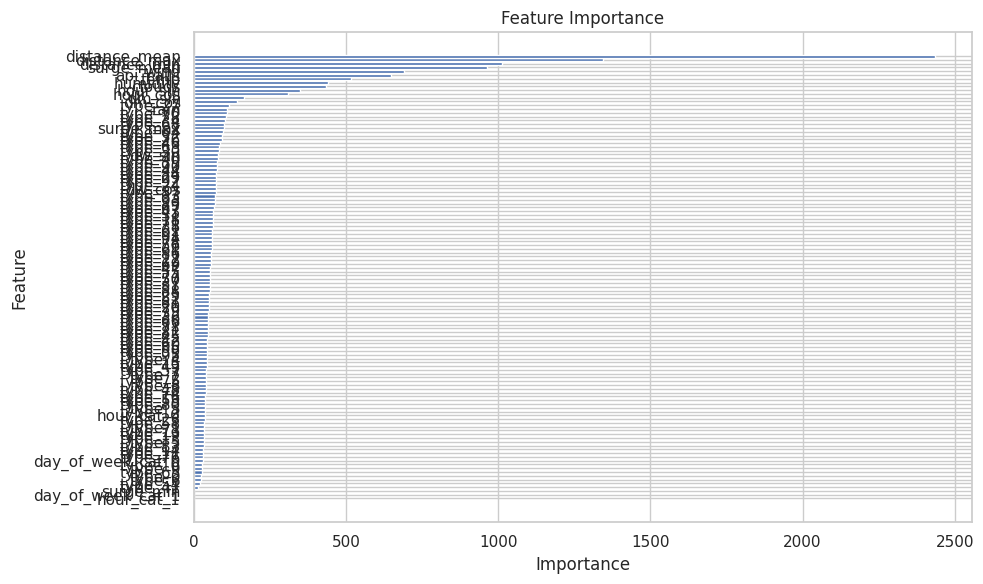

In [ ]:
selected_model = models['lightgbm']
selected_model.fit(X2, y2)

feature_importances = selected_model.feature_importances_
feature_names = df_train.columns

sorted_idx = np.argsort(feature_importances)[::]

# Plot feature importance
plt.figure(figsize=(10, 6))
plt.barh(range(len(feature_importances)), feature_importances[sorted_idx], align='center')
plt.yticks(range(len(feature_importances)), np.array(X2.columns)[sorted_idx])
plt.title('Feature Importance')
plt.ylabel('Feature')
plt.xlabel('Importance')
plt.tight_layout() # Adjust layout to fit feature names
plt.show()

##Model Fitting and Predicting

In [ ]:
from sklearn.model_selection import cross_val_score, KFold
from sklearn.metrics import make_scorer, mean_squared_error
import numpy as np

###Random Goofy Ah Prediction with 10-Fold Cross-Validation

In [ ]:
X.head()

0         1     2         3         4         5         6         7  \
0  3.03  1.726667  1.04  1.055556  1.530384  1.584343  1.567749  1.562201   
1  2.48  2.184546  1.35  1.000000  1.594084  1.575918  1.535170  1.536719   
2  4.03  2.893333  1.27  1.166667  1.549533  1.603170  1.539784  1.575851   
3  3.24  2.193750  1.27  1.062500  1.559662  1.515116  1.515955  1.519818   
4  2.80  1.502857  1.13  1.000000  1.575242  1.577343  1.573227  1.524141   

          8         9  ...        64        65        66        67        68  \
0  1.527866  1.535227  ...  1.555017  1.524636  1.598970  1.601713  1.582746   
1  1.582490  1.599691  ...  1.516756  1.520062  1.518822  1.530458  1.536864   
2  1.575588  1.556355  ...  1.604093  1.559253  1.599485  1.578019  1.601649   
3  1.491940  1.479692  ...  1.546000  1.518486  1.482067  1.513724  1.519851   
4  1.577920  1.617426  ...  1.555901  1.617357  1.581571  1.542636  1.527206   

         69        70        71        72        73  
0  1.509556  1.558851  1.561749  1.558594  1.579953  
1  1.595134  1.579940  1.559773  1.612567  1.544391  
2  1.579334  1.603100  1.559056  1.599427  1.536731  
3  1.504871  1.488827  1.475688  1.523129  1.474201  
4  1.587719  1.571901  1.594894  1.557785  1.575085  

[5 rows x 74 columns]

In [ ]:
y.head()

0    16.555556
1    28.227273
2    23.250000
3    22.250000
4    12.785714
Name: price_mean, dtype: float64

In [ ]:
import numpy as np

folds = 10

best_hyperparameters = {'l2_leaf_reg': 1.4362624578457377,
                  'max_bin': 181,
                  'learning_rate': 0.012506402834076311,
                  'max_depth': 7,
                  'random_state': 69,
                  'min_data_in_leaf': 110,
                   'rsm' : 0.5
                                           }

# Define a custom scoring function (RMSE)
def rmse(model, X_train, y_train):
    y_pred = model.predict(X_train)
    return np.sqrt(mean_squared_error(y_train, y_pred))

# Perform cross-validation with 5 folds
kf = KFold(n_splits=folds, shuffle=True, random_state=42)
cv_scores = cross_val_score(catboost_model, X, y, cv=kf, scoring=make_scorer(rmse))

rmse_list = []

# Print the RMSE for each fold
for i, (train_index, test_index) in enumerate(kf.split(X), start=1):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    catboost_model = CatBoostRegressor(**best_hyperparameters, verbose=0)

    catboost_model.fit(X_train, y_train)
    y_pred = catboost_model.predict(X_test)

    fold_rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    print(f"Fold {i}: RMSE = {fold_rmse}")

    rmse_list.append(fold_rmse)

# Calculate and print the mean RMSE
mean_rmse = np.mean(fold_rmse)
print(f"\nMean RMSE across folds: {mean_rmse}")

KeyError: ignored

###Simple and General Predicting

In [ ]:
#best_hyperparameters = {'max_depth': 5, 'learning_rate': 0.08, 'l2_leaf_reg': 6, 'iterations': 1500}

catboost_model = CatBoostRegressor(**best_hyperparameters)
catboost_model.fit(X, y, verbose=0)

###More Outliers Handling **(Optional)** (Only Run 1 SubHeader, not Both)

**Do Note that DBSCAN ALWAYS return the same cluster result, so one dbscan is all it takes.**

**However, the splitting in X and y to train and test is random, so a necessity to do dbscan inside the loop is relevant in cross-validation.**

####For 1 Try

#####The Outliers Splitting

In [ ]:
X = pd.DataFrame(X)
y = pd.DataFrame(y)
X.shape, y.shape

((20006, 74), (20006, 1))

In [ ]:
X.head()

0         1     2         3         4         5         6         7  \
0  3.03  1.726667  1.04  1.055556  1.530384  1.584343  1.567749  1.562201   
1  2.48  2.184546  1.35  1.000000  1.594084  1.575918  1.535170  1.536719   
2  4.03  2.893333  1.27  1.166667  1.549533  1.603170  1.539784  1.575851   
3  3.24  2.193750  1.27  1.062500  1.559662  1.515116  1.515955  1.519818   
4  2.80  1.502857  1.13  1.000000  1.575242  1.577343  1.573227  1.524141   

          8         9  ...        64        65        66        67        68  \
0  1.527866  1.535227  ...  1.555017  1.524636  1.598970  1.601713  1.582746   
1  1.582490  1.599691  ...  1.516756  1.520062  1.518822  1.530458  1.536864   
2  1.575588  1.556355  ...  1.604093  1.559253  1.599485  1.578019  1.601649   
3  1.491940  1.479692  ...  1.546000  1.518486  1.482067  1.513724  1.519851   
4  1.577920  1.617426  ...  1.555901  1.617357  1.581571  1.542636  1.527206   

         69        70        71        72        73  
0  1.509556  1.558851  1.561749  1.558594  1.579953  
1  1.595134  1.579940  1.559773  1.612567  1.544391  
2  1.579334  1.603100  1.559056  1.599427  1.536731  
3  1.504871  1.488827  1.475688  1.523129  1.474201  
4  1.587719  1.571901  1.594894  1.557785  1.575085  

[5 rows x 74 columns]

In [ ]:
from sklearn.cluster import DBSCAN

y = y.rename(columns={0: 'resp'})

df_combined = pd.concat([X, y], axis=1)

In [ ]:
df_combined.head()

0         1     2         3         4         5         6         7  \
0  3.03  1.726667  1.04  1.055556  1.530384  1.584343  1.567749  1.562201   
1  2.48  2.184546  1.35  1.000000  1.594084  1.575918  1.535170  1.536719   
2  4.03  2.893333  1.27  1.166667  1.549533  1.603170  1.539784  1.575851   
3  3.24  2.193750  1.27  1.062500  1.559662  1.515116  1.515955  1.519818   
4  2.80  1.502857  1.13  1.000000  1.575242  1.577343  1.573227  1.524141   

          8         9  ...        65        66        67        68        69  \
0  1.527866  1.535227  ...  1.524636  1.598970  1.601713  1.582746  1.509556   
1  1.582490  1.599691  ...  1.520062  1.518822  1.530458  1.536864  1.595134   
2  1.575588  1.556355  ...  1.559253  1.599485  1.578019  1.601649  1.579334   
3  1.491940  1.479692  ...  1.518486  1.482067  1.513724  1.519851  1.504871   
4  1.577920  1.617426  ...  1.617357  1.581571  1.542636  1.527206  1.587719   

         70        71        72        73  price_mean  
0  1.558851  1.561749  1.558594  1.579953   16.555556  
1  1.579940  1.559773  1.612567  1.544391   28.227273  
2  1.603100  1.559056  1.599427  1.536731   23.250000  
3  1.488827  1.475688  1.523129  1.474201   22.250000  
4  1.571901  1.594894  1.557785  1.575085   12.785714  

[5 rows x 75 columns]

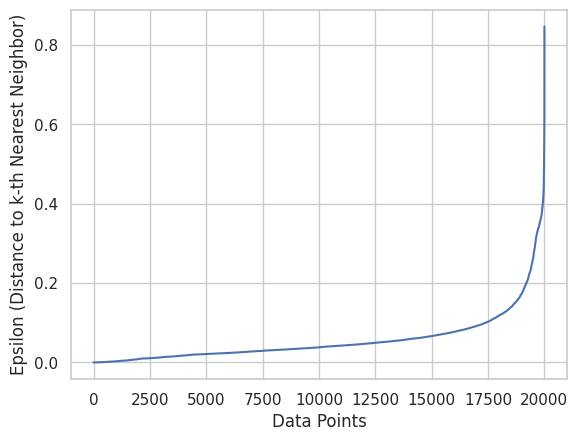

In [ ]:
from sklearn.neighbors import NearestNeighbors
import matplotlib.pyplot as plt

# Assuming X is your feature matrix
neighbors = NearestNeighbors(n_neighbors=2)
distances, indices = neighbors.fit(X).kneighbors(X)

distances = distances[:, 1]
distances = np.sort(distances, axis=0)

plt.plot(distances)
plt.xlabel('Data Points')
plt.ylabel('Epsilon (Distance to k-th Nearest Neighbor)')
plt.show()

In [ ]:
dbscan = DBSCAN(eps=3, min_samples=5)
df_combined.columns = df_combined.columns.astype(str)
df_combined['cluster_label'] = dbscan.fit_predict(df_combined)

In [ ]:
# Extract outliers (points with cluster_label == -1)
outliers_combined = df_combined[df_combined['cluster_label'] == -1]

In [ ]:
#The Outliers
outliers_combined.drop(['cluster_label'], axis=1, inplace=True)
X_outliers = outliers_combined.iloc[:, :-2]
y_outliers = outliers_combined.iloc[:, -1]

In [ ]:
# Without Outliers
df_no_outliers_combined = df_combined[df_combined['cluster_label'] != -1]
df_no_outliers_combined.drop('cluster_label', axis=1, inplace=True)

In [ ]:
X_no_outliers = df_no_outliers_combined.iloc[:, :-1]
y_no_outliers = df_no_outliers_combined.iloc[:, -1]

In [ ]:
X_no_outliers.shape, y_no_outliers.shape, X.shape, y.shape

((20001, 74), (20001,), (20006, 74), (20006, 1))

In [ ]:
X_no_outliers.head()

0         1     2         3         4         5         6         7  \
0  3.03  1.726667  1.04  1.055556  1.530384  1.584343  1.567749  1.562201   
1  2.48  2.184546  1.35  1.000000  1.594084  1.575918  1.535170  1.536719   
2  4.03  2.893333  1.27  1.166667  1.549533  1.603170  1.539784  1.575851   
3  3.24  2.193750  1.27  1.062500  1.559662  1.515116  1.515955  1.519818   
4  2.80  1.502857  1.13  1.000000  1.575242  1.577343  1.573227  1.524141   

          8         9  ...        64        65        66        67        68  \
0  1.527866  1.535227  ...  1.555017  1.524636  1.598970  1.601713  1.582746   
1  1.582490  1.599691  ...  1.516756  1.520062  1.518822  1.530458  1.536864   
2  1.575588  1.556355  ...  1.604093  1.559253  1.599485  1.578019  1.601649   
3  1.491940  1.479692  ...  1.546000  1.518486  1.482067  1.513724  1.519851   
4  1.577920  1.617426  ...  1.555901  1.617357  1.581571  1.542636  1.527206   

         69        70        71        72        73  
0  1.509556  1.558851  1.561749  1.558594  1.579953  
1  1.595134  1.579940  1.559773  1.612567  1.544391  
2  1.579334  1.603100  1.559056  1.599427  1.536731  
3  1.504871  1.488827  1.475688  1.523129  1.474201  
4  1.587719  1.571901  1.594894  1.557785  1.575085  

[5 rows x 74 columns]

In [ ]:
y_no_outliers.head()

0    16.555556
1    28.227273
2    23.250000
3    22.250000
4    12.785714
Name: price_mean, dtype: float64

#####The Cross Validation (Same Outliers)

In [ ]:
folds = 10

best_hyperparameters=  {'l2_leaf_reg': 1.3141397418018679,
                        'max_bin': 294,
                        'learning_rate': 0.027493905498416002,
                        'iterations': 10897,
                        'max_depth': 4,
                        'random_state': 69,
                        'min_data_in_leaf': 3,
                        'rsm': 0.5
                        }

catboost_model = CatBoostRegressor(**best_hyperparameters, verbose=0)

# Define a custom scoring function (RMSE)
def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

# Perform cross-validation with folds
kf = KFold(n_splits=folds, shuffle=True, random_state=69)
cv_scores = cross_val_score(catboost_model, X, y, cv=kf, scoring=make_scorer(rmse))

# Print the RMSE for each fold
for i, score in enumerate(cv_scores, start=1):
    print(f"Fold {i}: RMSE = {score}")

# Calculate and print the mean RMSE
mean_rmse = np.mean(cv_scores)
print(f"\nMean RMSE across folds: {mean_rmse}")

Fold 1: RMSE = 0.5693469867089836
Fold 2: RMSE = 0.5817659516077786
Fold 3: RMSE = 0.5041437121433128
Fold 4: RMSE = 0.5397378862360533
Fold 5: RMSE = 0.5670763065001154
Fold 6: RMSE = 0.5702094448549943
Fold 7: RMSE = 0.5628860802363559
Fold 8: RMSE = 0.5724377017195011
Fold 9: RMSE = 0.544496998179091
Fold 10: RMSE = 0.5363815997398064

Mean RMSE across folds: 0.5548482667925992


####For Cross Validation (Different Outliers as Different Train-Test-Split)



In [ ]:
X = pd.DataFrame(X)
y = pd.DataFrame(y)
X.shape, y.shape

((20006, 74), (20006, 1))

In [ ]:
from sklearn.cluster import DBSCAN
import pandas as pd

y = y.rename(columns={0: 'resp'})

In [ ]:
folds = 10
best_hyperparameters=  {'l2_leaf_reg': 1.3141397418018679,
                        'max_bin': 294,
                        'learning_rate': 0.027493905498416002,
                        'iterations': 10897,
                        'max_depth': 4,
                        'random_state': 69,
                        'min_data_in_leaf': 3,
                        'rsm': 0.5
                        }
catboost_model = CatBoostRegressor(**best_hyperparameters, verbose=0)

rmse_scores = []

# Define a custom scoring function (RMSE)
def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

# Perform cross-validation with folds
kf = KFold(n_splits=folds, shuffle=True, random_state=69)

for train_index, test_index in kf.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    # Apply DBSCAN on the training set
    df_train_combined = pd.concat([X_train, y_train], axis=1)
    dbscan = DBSCAN(eps=7, min_samples=5)
    df_train_combined.columns = df_train_combined.columns.astype(str)
    df_train_combined['cluster_label'] = dbscan.fit_predict(df_train_combined)

    # Without Outliers in the training set
    df_train_no_outliers_combined = df_train_combined[df_train_combined['cluster_label'] != -1]
    df_train_no_outliers_combined.drop('cluster_label', axis=1, inplace=True)
    X_train_no_outliers = df_train_no_outliers_combined.iloc[:, :-1]
    y_train_no_outliers = df_train_no_outliers_combined.iloc[:, -1]

    # Fit the CatBoost model on the training set without outliers
    catboost_model.fit(X_train_no_outliers, y_train_no_outliers, verbose=0)

    # Evaluate the model on the validation set
    y_pred = catboost_model.predict(X_test)
    rmse_score = rmse(y_test, y_pred)

    rmse_scores.append(rmse_score)

    print(f"RMSE on Validation Set: {rmse_score}")

# Calculate and print the mean RMSE
mean_rmse = np.mean(rmse_scores)
print(f"\nMean RMSE across folds: {mean_rmse}")

RMSE on Validation Set: 0.568707875040005
RMSE on Validation Set: 0.5817659516077786
RMSE on Validation Set: 0.5044396627265622
RMSE on Validation Set: 0.5416987848074913
RMSE on Validation Set: 0.5661906638748085
RMSE on Validation Set: 0.5720896473583846
RMSE on Validation Set: 0.5668536246152547
RMSE on Validation Set: 0.569586862013564
RMSE on Validation Set: 0.5529795044710256
RMSE on Validation Set: 0.5473574085144822

Mean RMSE across folds: 0.5571669985029357


###Feature Selection **(Optional)**

####For 1 Try

#####Fitting For Feature Selection

In [ ]:
best_hyperparameters=  {'l2_leaf_reg': 1.3141397418018679,
                        'max_bin': 294,
                        'learning_rate': 0.027493905498416002,
                        'iterations': 10897,
                        'max_depth': 4,
                        'random_state': 69,
                        'min_data_in_leaf': 3,
                        'rsm': 0.5
                        }

catboost_model = CatBoostRegressor(**best_hyperparameters)
catboost_model.fit(X, y, verbose=0)

#####The Filtering

In [ ]:
X = pd.DataFrame(X)

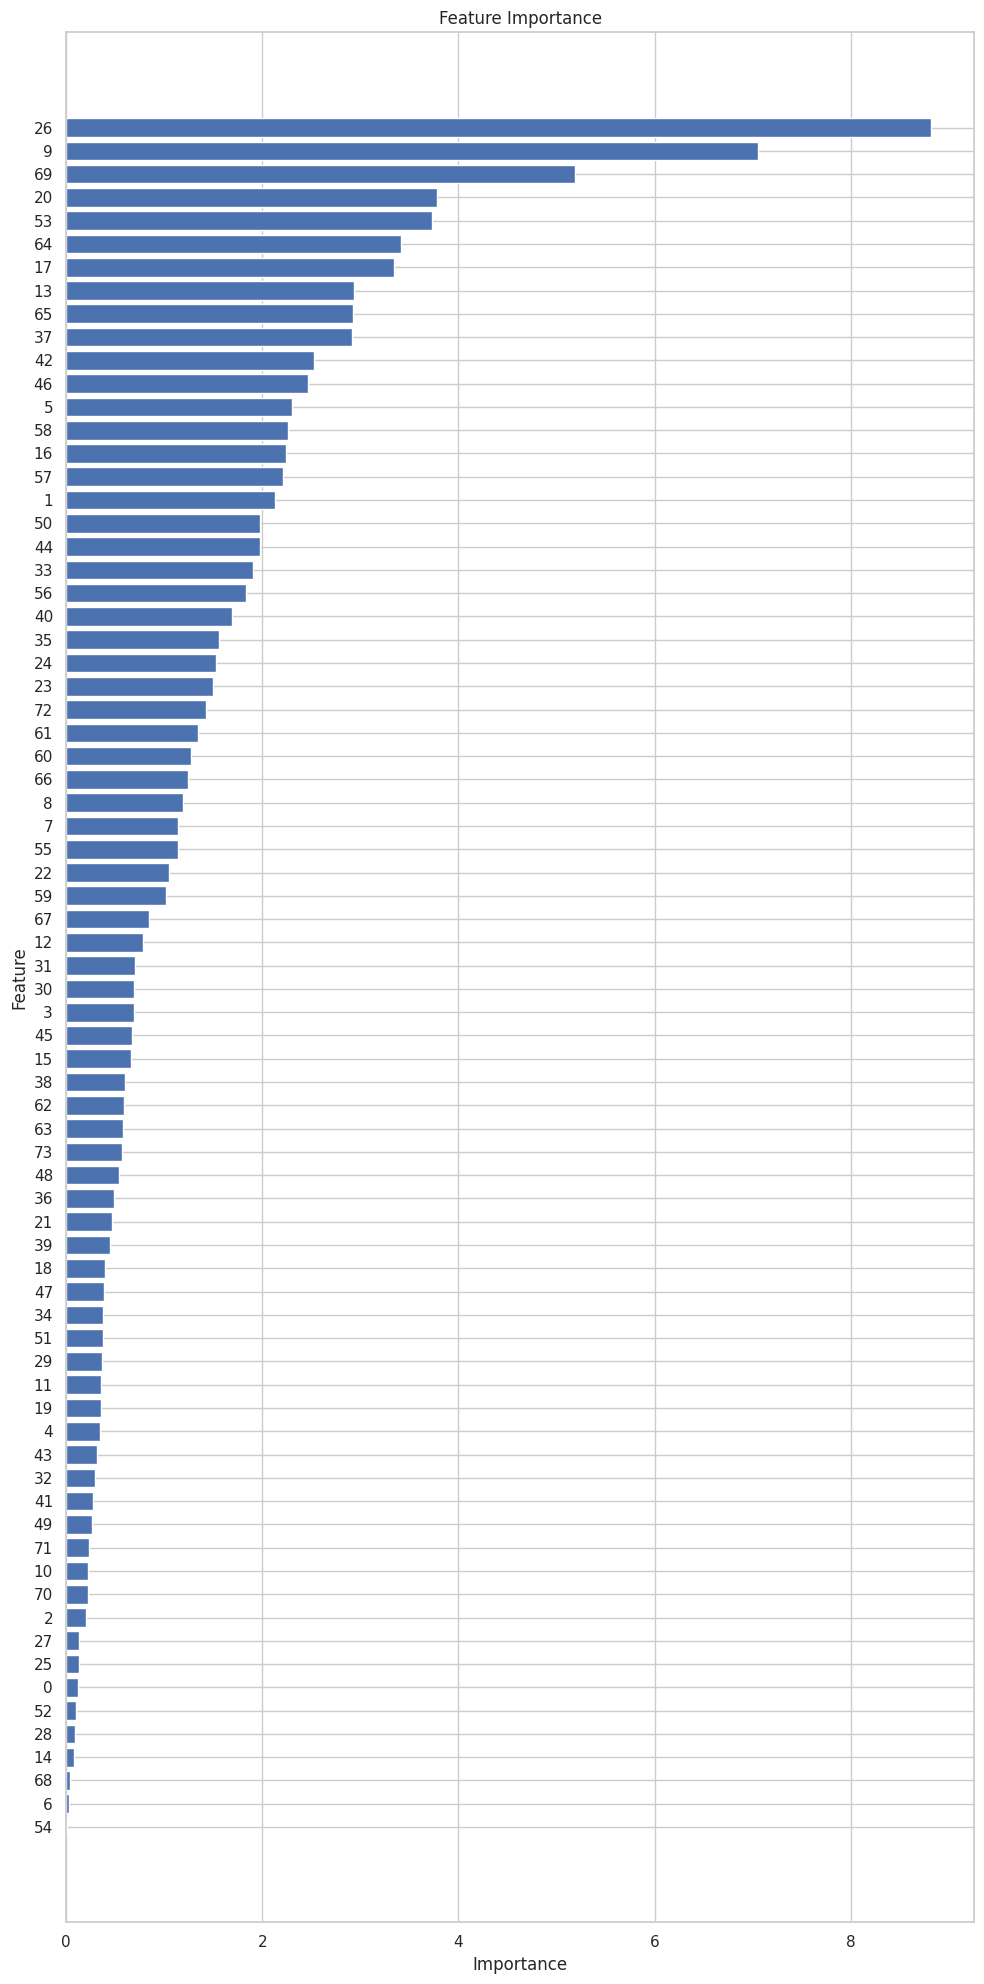

In [ ]:
feature_importances = catboost_model.get_feature_importance()

sorted_idx = np.argsort(feature_importances)[::]

# Plot feature importance
plt.figure(figsize=(10, 20))
plt.barh(range(len(feature_importances)), feature_importances[sorted_idx], align='center')
plt.yticks(range(len(feature_importances)), np.array(pd.DataFrame(X).columns)[sorted_idx])
plt.title('Feature Importance')
plt.ylabel('Feature')
plt.xlabel('Importance')
plt.tight_layout() # Adjust layout to fit feature names
plt.show()

In [ ]:
cutoff = 0.05
significant_features = X.columns[feature_importances > cutoff]
X_copy = X[significant_features]

In [ ]:
X.shape

(20006, 74)

In [ ]:
X_copy.shape

(20006, 71)

In [ ]:
df_test_2 = pd.DataFrame(df_test_2)

In [ ]:
df_test_2_copy = df_test_2.copy()
df_test_2_copy = df_test_2_copy[significant_features]

KeyError: ignored

In [ ]:
df_test_2_copy.shape

(11040, 82)

In [ ]:
X_copy.head()

2         3     4         8         57        59        60        61   \
0  3.03  1.726667  1.04  1.055556  1.584343  1.572928  1.562201  1.527866   
1  2.48  2.184546  1.35  1.000000  1.575918  1.541356  1.536719  1.582490   
2  4.03  2.893333  1.27  1.166667  1.603170  1.523680  1.575851  1.575588   
3  3.24  2.193750  1.27  1.062500  1.515116  1.559304  1.519818  1.491941   
4  2.80  1.502857  1.13  1.000000  1.577343  1.612080  1.524141  1.577920   

        62        64   ...       138       139       141       142       143  \
0  1.535227  1.594138  ...  1.555017  1.524636  1.598970  1.601713  1.582746   
1  1.599691  1.561520  ...  1.516757  1.520062  1.518822  1.530458  1.536864   
2  1.556355  1.582144  ...  1.604093  1.559253  1.599485  1.578019  1.601649   
3  1.479692  1.523125  ...  1.546000  1.518486  1.482067  1.513724  1.519851   
4  1.617426  1.555500  ...  1.555901  1.617357  1.581572  1.542636  1.527206   

        144       146       147       148       149  
0  1.509556  1.558851  1.561749  1.558594  1.579953  
1  1.595134  1.579940  1.559773  1.612567  1.544391  
2  1.579334  1.603100  1.559056  1.599427  1.536731  
3  1.504871  1.488827  1.475688  1.523129  1.474201  
4  1.587719  1.571901  1.594894  1.557785  1.575085  

[5 rows x 82 columns]

In [ ]:
df_test_2_copy.head()

2         3     4         8         57        59        60        61   \
0  3.02  1.980000  1.06  1.115385  1.584343  1.572928  1.562201  1.527866   
1  2.34  1.541429  1.04  1.000000  1.584343  1.572928  1.562201  1.527866   
2  3.00  2.010769  1.08  1.096154  1.584343  1.572928  1.562201  1.527866   
3  3.14  1.860833  1.06  1.020833  1.584343  1.572928  1.562201  1.527866   
4  2.41  1.634286  1.06  1.035714  1.584343  1.572928  1.562201  1.527866   

        62        64   ...       138       139      141       142       143  \
0  1.535227  1.594138  ...  1.555017  1.524636  1.59897  1.601713  1.582746   
1  1.535227  1.594138  ...  1.555017  1.524636  1.59897  1.601713  1.582746   
2  1.535227  1.594138  ...  1.555017  1.524636  1.59897  1.601713  1.582746   
3  1.535227  1.594138  ...  1.555017  1.524636  1.59897  1.601713  1.582746   
4  1.535227  1.594138  ...  1.555017  1.524636  1.59897  1.601713  1.582746   

        144       146       147       148       149  
0  1.509556  1.558851  1.561749  1.558594  1.579953  
1  1.509556  1.558851  1.561749  1.558594  1.579953  
2  1.509556  1.558851  1.561749  1.558594  1.579953  
3  1.509556  1.558851  1.561749  1.558594  1.579953  
4  1.509556  1.558851  1.561749  1.558594  1.579953  

[5 rows x 82 columns]

#####Cross Validation (Same Filters Throughout)

In [ ]:
folds = 10


best_hyperparameters= {
 'l2_leaf_reg': 0.00244211490930069,
 'max_bin': 367,
 'learning_rate': 0.0948179878235732,
 'max_depth': 4,
 'random_state': 69,
 'min_data_in_leaf': 53,
 'rsm' : 0.5
 }
catboost_model = CatBoostRegressor(**best_hyperparameters, verbose=0)

# Define a custom scoring function (RMSE)
def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

# Perform cross-validation with folds
kf = KFold(n_splits=folds, shuffle=True, random_state=69)
cv_scores = cross_val_score(catboost_model, X_copy, y, cv=kf, scoring=make_scorer(rmse))

# Print the RMSE for each fold
for i, score in enumerate(cv_scores, start=1):
    print(f"Fold {i}: RMSE = {score}")

# Calculate and print the mean RMSE
mean_rmse = np.mean(cv_scores)
print(f"\nMean RMSE across folds: {mean_rmse}")

Fold 1: RMSE = 0.5742470720054602
Fold 2: RMSE = 0.5932289015263452
Fold 3: RMSE = 0.5173803922283767
Fold 4: RMSE = 0.5509104031302721
Fold 5: RMSE = 0.5668297250679368
Fold 6: RMSE = 0.5790033261286001
Fold 7: RMSE = 0.5729770804765272
Fold 8: RMSE = 0.5820075337251581
Fold 9: RMSE = 0.5560297068290665
Fold 10: RMSE = 0.5385635600546687

Mean RMSE across folds: 0.5631177701172411


####Cross-Validation (Different Filters Throughout)


In [ ]:
X = pd.DataFrame(X)
y = pd.DataFrame(y)

In [ ]:
folds = 10


best_hyperparameters= {'l2_leaf_reg': 1.6705935201013231,
                       'max_bin': 190,
                       'learning_rate': 0.0356477327994906,
                       'iterations': 20282,
                       'max_depth': 5,
                       'random_state': 69,
                       'min_data_in_leaf': 134}
catboost_model = CatBoostRegressor(**best_hyperparameters, verbose=0)

rmse_scores = []

# Define a custom scoring function (RMSE)
def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

# Perform cross-validation with 10 folds
kf = KFold(n_splits=folds, shuffle=True, random_state=69)

for train_index, test_index in kf.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    # Fit the CatBoost model on the training set
    catboost_model.fit(X_train, y_train, verbose=0)
    # Get the Feature Importances
    feature_importances = catboost_model.get_feature_importance()

    # Remove the Insignificant Features
    cutoff = 0.05
    significant_features = X_train.columns[feature_importances > cutoff]
    X_train_copy = X_train[significant_features]

    X_test_copy = X_test.copy()
    X_test_copy = X_test_copy[significant_features]

    # Fit the CatBoost model on the new training set
    catboost_model.fit(X_train_copy, y_train, verbose=0)

    # Evaluate the model on the validation set
    y_pred = catboost_model.predict(X_test_copy)
    rmse_score = rmse(y_test, y_pred)

    rmse_scores.append(rmse_score)

    print(f"RMSE on Validation Set: {rmse_score}")

# Calculate and print the mean RMSE
mean_rmse = np.mean(rmse_scores)
print(f"\nMean RMSE across folds: {mean_rmse}")

RMSE on Validation Set: 0.592123175306631


KeyboardInterrupt: ignored

###Both Outliers Handling and Feature Selection **(Optional)** (Only Run 1 SubHeader, not Both)

In [ ]:
from sklearn.cluster import DBSCAN

####For 1 Try

#####The Outliers Splitting

In [ ]:
X = pd.DataFrame(X)
y = pd.DataFrame(y)
X.shape, y.shape

((20006, 74), (20006, 1))

In [ ]:
X.head()

0         1     2         3         4         5         6         7  \
0  3.03  1.726667  1.04  1.055556  1.530384  1.584343  1.567749  1.562201   
1  2.48  2.184546  1.35  1.000000  1.594084  1.575918  1.535170  1.536719   
2  4.03  2.893333  1.27  1.166667  1.549533  1.603170  1.539784  1.575851   
3  3.24  2.193750  1.27  1.062500  1.559662  1.515116  1.515955  1.519818   
4  2.80  1.502857  1.13  1.000000  1.575242  1.577343  1.573227  1.524141   

          8         9  ...        64        65        66        67        68  \
0  1.527866  1.535227  ...  1.555017  1.524636  1.598970  1.601713  1.582746   
1  1.582490  1.599691  ...  1.516756  1.520062  1.518822  1.530458  1.536864   
2  1.575588  1.556355  ...  1.604093  1.559253  1.599485  1.578019  1.601649   
3  1.491940  1.479692  ...  1.546000  1.518486  1.482067  1.513724  1.519851   
4  1.577920  1.617426  ...  1.555901  1.617357  1.581571  1.542636  1.527206   

         69        70        71        72        73  
0  1.509556  1.558851  1.561749  1.558594  1.579953  
1  1.595134  1.579940  1.559773  1.612567  1.544391  
2  1.579334  1.603100  1.559056  1.599427  1.536731  
3  1.504871  1.488827  1.475688  1.523129  1.474201  
4  1.587719  1.571901  1.594894  1.557785  1.575085  

[5 rows x 74 columns]

In [ ]:
from sklearn.cluster import DBSCAN

y = y.rename(columns={0: 'resp'})

df_combined = pd.concat([X, y], axis=1)

In [ ]:
df_combined.head()

0         1     2         3         4         5         6         7  \
0  3.03  1.726667  1.04  1.055556  1.530384  1.584343  1.567749  1.562201   
1  2.48  2.184546  1.35  1.000000  1.594084  1.575918  1.535170  1.536719   
2  4.03  2.893333  1.27  1.166667  1.549533  1.603170  1.539784  1.575851   
3  3.24  2.193750  1.27  1.062500  1.559662  1.515116  1.515955  1.519818   
4  2.80  1.502857  1.13  1.000000  1.575242  1.577343  1.573227  1.524141   

          8         9  ...        65        66        67        68        69  \
0  1.527866  1.535227  ...  1.524636  1.598970  1.601713  1.582746  1.509556   
1  1.582490  1.599691  ...  1.520062  1.518822  1.530458  1.536864  1.595134   
2  1.575588  1.556355  ...  1.559253  1.599485  1.578019  1.601649  1.579334   
3  1.491940  1.479692  ...  1.518486  1.482067  1.513724  1.519851  1.504871   
4  1.577920  1.617426  ...  1.617357  1.581571  1.542636  1.527206  1.587719   

         70        71        72        73  price_mean  
0  1.558851  1.561749  1.558594  1.579953   16.555556  
1  1.579940  1.559773  1.612567  1.544391   28.227273  
2  1.603100  1.559056  1.599427  1.536731   23.250000  
3  1.488827  1.475688  1.523129  1.474201   22.250000  
4  1.571901  1.594894  1.557785  1.575085   12.785714  

[5 rows x 75 columns]

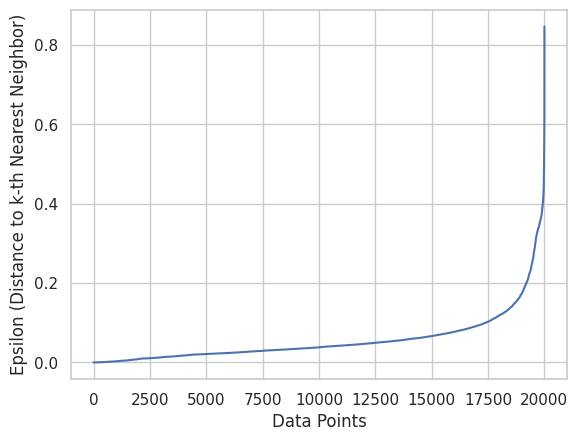

In [ ]:
from sklearn.neighbors import NearestNeighbors
import matplotlib.pyplot as plt

# Assuming X is your feature matrix
neighbors = NearestNeighbors(n_neighbors=2)
distances, indices = neighbors.fit(X).kneighbors(X)

distances = distances[:, 1]
distances = np.sort(distances, axis=0)

plt.plot(distances)
plt.xlabel('Data Points')
plt.ylabel('Epsilon (Distance to k-th Nearest Neighbor)')
plt.show()

In [ ]:
dbscan = DBSCAN(eps=3, min_samples=5)
df_combined.columns = df_combined.columns.astype(str)
df_combined['cluster_label'] = dbscan.fit_predict(df_combined)

In [ ]:
# Extract outliers (points with cluster_label == -1)
outliers_combined = df_combined[df_combined['cluster_label'] == -1]

In [ ]:
#The Outliers
outliers_combined.drop(['cluster_label'], axis=1, inplace=True)
X_outliers = outliers_combined.iloc[:, :-2]
y_outliers = outliers_combined.iloc[:, -1]

In [ ]:
# Without Outliers
df_no_outliers_combined = df_combined[df_combined['cluster_label'] != -1]
df_no_outliers_combined.drop('cluster_label', axis=1, inplace=True)

In [ ]:
X_no_outliers = df_no_outliers_combined.iloc[:, :-1]
y_no_outliers = df_no_outliers_combined.iloc[:, -1]

In [ ]:
X_no_outliers.shape, y_no_outliers.shape, X.shape, y.shape

((20001, 74), (20001,), (20006, 74), (20006, 1))

In [ ]:
X_no_outliers.head()

0         1     2         3         4         5         6         7  \
0  3.03  1.726667  1.04  1.055556  1.530384  1.584343  1.567749  1.562201   
1  2.48  2.184546  1.35  1.000000  1.594084  1.575918  1.535170  1.536719   
2  4.03  2.893333  1.27  1.166667  1.549533  1.603170  1.539784  1.575851   
3  3.24  2.193750  1.27  1.062500  1.559662  1.515116  1.515955  1.519818   
4  2.80  1.502857  1.13  1.000000  1.575242  1.577343  1.573227  1.524141   

          8         9  ...        64        65        66        67        68  \
0  1.527866  1.535227  ...  1.555017  1.524636  1.598970  1.601713  1.582746   
1  1.582490  1.599691  ...  1.516756  1.520062  1.518822  1.530458  1.536864   
2  1.575588  1.556355  ...  1.604093  1.559253  1.599485  1.578019  1.601649   
3  1.491940  1.479692  ...  1.546000  1.518486  1.482067  1.513724  1.519851   
4  1.577920  1.617426  ...  1.555901  1.617357  1.581571  1.542636  1.527206   

         69        70        71        72        73  
0  1.509556  1.558851  1.561749  1.558594  1.579953  
1  1.595134  1.579940  1.559773  1.612567  1.544391  
2  1.579334  1.603100  1.559056  1.599427  1.536731  
3  1.504871  1.488827  1.475688  1.523129  1.474201  
4  1.587719  1.571901  1.594894  1.557785  1.575085  

[5 rows x 74 columns]

In [ ]:
y_no_outliers.head()

0    16.555556
1    28.227273
2    23.250000
3    22.250000
4    12.785714
Name: price_mean, dtype: float64

#####Fitting For Feature Selection

In [ ]:
best_hyperparameters=  {'l2_leaf_reg': 1.3141397418018679,
                        'max_bin': 294,
                        'learning_rate': 0.027493905498416002,
                        'iterations': 10897,
                        'max_depth': 4,
                        'random_state': 69,
                        'min_data_in_leaf': 3}

catboost_model = CatBoostRegressor(**best_hyperparameters)
catboost_model.fit(X_no_outliers, y_no_outliers, verbose=0)

#####The Filtering (Feature Selection)

In [ ]:
X_no_outliers = pd.DataFrame(X_no_outliers)

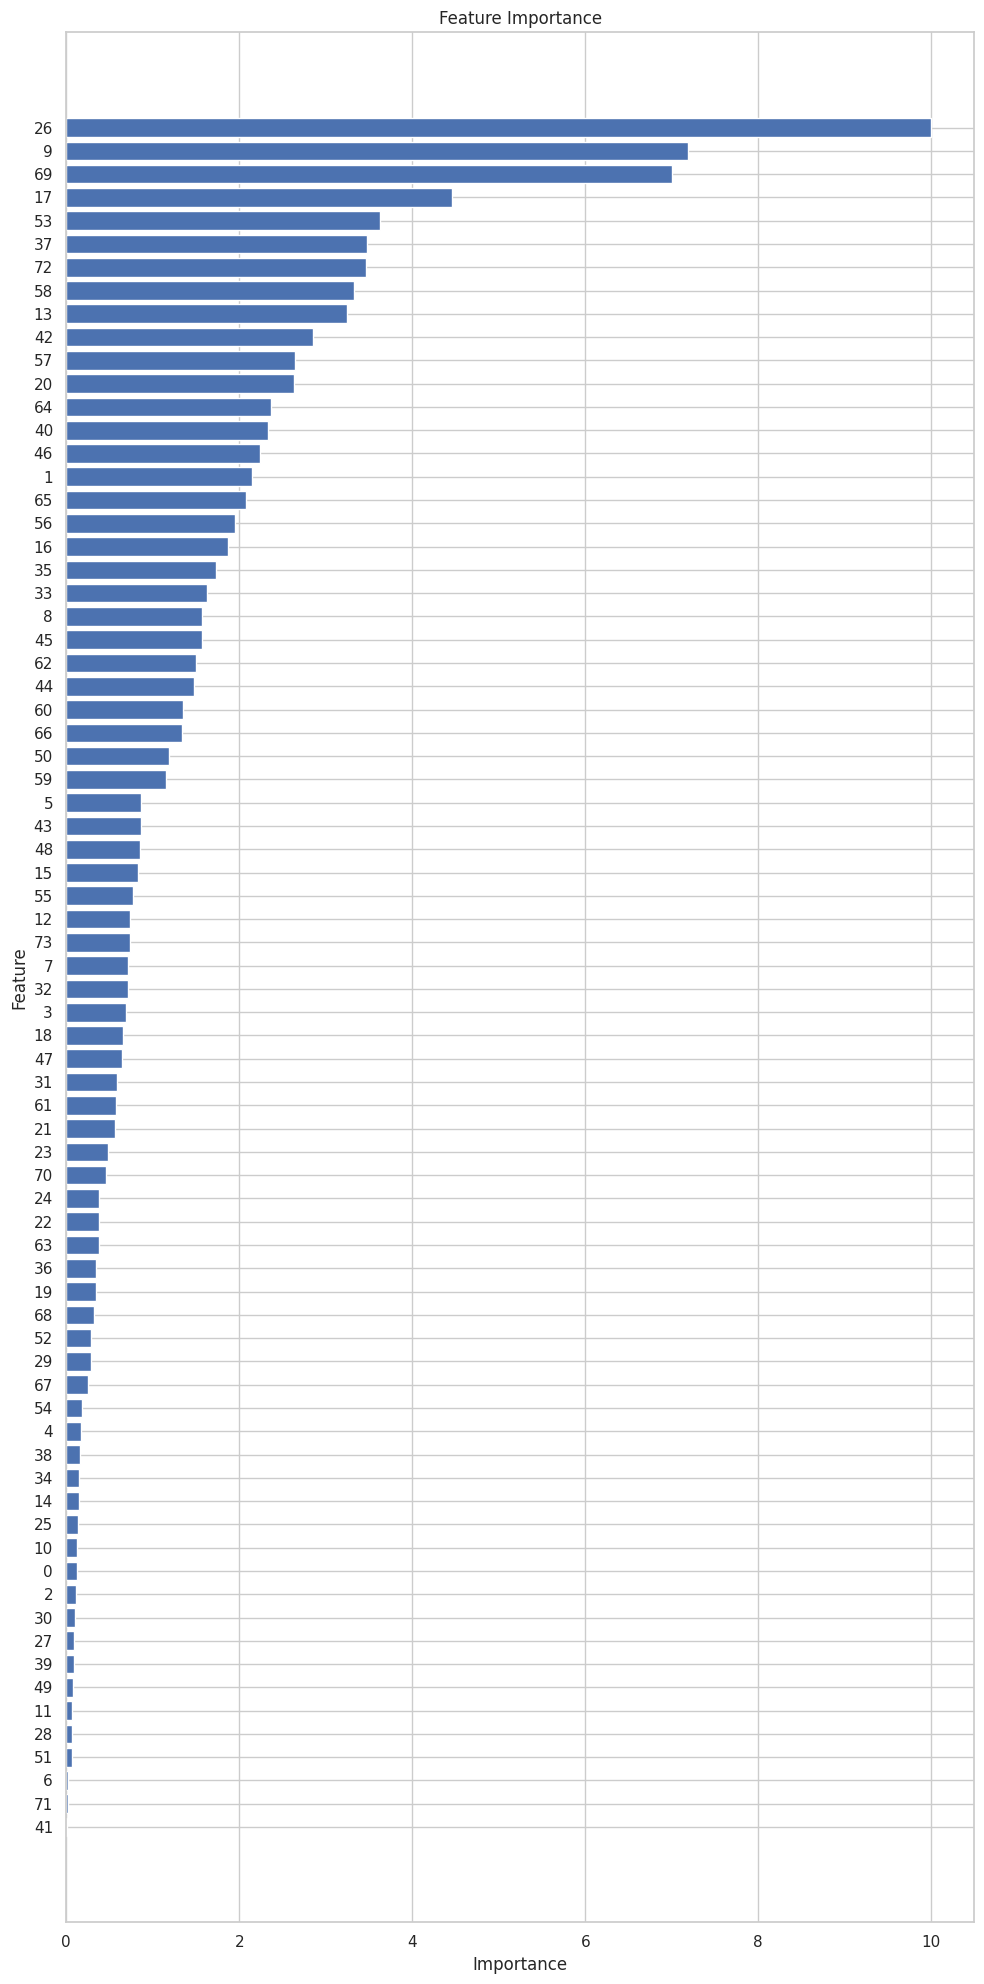

In [ ]:
feature_importances = catboost_model.get_feature_importance()

sorted_idx = np.argsort(feature_importances)[::]

# Plot feature importance
plt.figure(figsize=(10, 20))
plt.barh(range(len(feature_importances)), feature_importances[sorted_idx], align='center')
plt.yticks(range(len(feature_importances)), np.array(pd.DataFrame(X_no_outliers).columns)[sorted_idx])
plt.title('Feature Importance')
plt.ylabel('Feature')
plt.xlabel('Importance')
plt.tight_layout() # Adjust layout to fit feature names
plt.show()

In [ ]:
cutoff = 0.05
significant_features = X_no_outliers.columns[feature_importances > cutoff]
X_copy = X_no_outliers[significant_features]

In [ ]:
X_no_outliers.shape

(20001, 74)

In [ ]:
X_copy.shape

(20001, 71)

In [ ]:
df_test_2 = pd.DataFrame(df_test_2)

In [ ]:
df_test_2.columns = df_test_2.columns.astype(str)
df_test_2_copy = df_test_2.copy()
df_test_2_copy = df_test_2_copy[significant_features]

In [ ]:
df_test_2_copy.shape

(11040, 71)

In [ ]:
X_copy.head()

0         1     2         3         4         5         7         8  \
0  3.03  1.726667  1.04  1.055556  1.530384  1.584343  1.562201  1.527866   
1  2.48  2.184546  1.35  1.000000  1.594084  1.575918  1.536719  1.582490   
2  4.03  2.893333  1.27  1.166667  1.549533  1.603170  1.575851  1.575588   
3  3.24  2.193750  1.27  1.062500  1.559662  1.515116  1.519818  1.491940   
4  2.80  1.502857  1.13  1.000000  1.575242  1.577343  1.524141  1.577920   

          9        10  ...        63        64        65        66        67  \
0  1.535227  1.521993  ...  1.522311  1.555017  1.524636  1.598970  1.601713   
1  1.599691  1.580634  ...  1.576451  1.516756  1.520062  1.518822  1.530458   
2  1.556355  1.535003  ...  1.579264  1.604093  1.559253  1.599485  1.578019   
3  1.479692  1.476607  ...  1.543861  1.546000  1.518486  1.482067  1.513724   
4  1.617426  1.573669  ...  1.576997  1.555901  1.617357  1.581571  1.542636   

         68        69        70        72        73  
0  1.582746  1.509556  1.558851  1.558594  1.579953  
1  1.536864  1.595134  1.579940  1.612567  1.544391  
2  1.601649  1.579334  1.603100  1.599427  1.536731  
3  1.519851  1.504871  1.488827  1.523129  1.474201  
4  1.527206  1.587719  1.571901  1.557785  1.575085  

[5 rows x 71 columns]

In [ ]:
df_test_2_copy.head()

0     1     2     3         4     5    7     8         9   10  ...  \
0  0.0  13.0  0.69  3.02  1.980000  1.06  0.0  2.00  1.115385  1.0  ...   
1  0.0  14.0  0.77  2.34  1.541429  1.04  0.0  1.00  1.000000  1.0  ...   
2  0.0  13.0  0.59  3.00  2.010769  1.08  0.0  1.50  1.096154  1.0  ...   
3  0.0  12.0  0.68  3.14  1.860833  1.06  0.0  1.25  1.020833  1.0  ...   
4  0.0   7.0  0.72  2.41  1.634286  1.06  0.0  1.25  1.035714  1.0  ...   

        63        64        65        66        67        68        69  \
0  3.00033  3.072187  2.984945  3.071916  3.075117  3.063469  3.019605   
1  3.00033  3.072187  2.984945  3.071916  3.075117  3.063469  3.019605   
2  3.00033  3.072187  2.984945  3.071916  3.075117  3.063469  3.019605   
3  3.00033  3.072187  2.984945  3.071916  3.075117  3.063469  3.019605   
4  3.00033  3.072187  2.984945  3.071916  3.075117  3.063469  3.019605   

         70        72        73  
0  2.980871  3.068515  2.982571  
1  2.980871  3.068515  2.982571  
2  2.980871  3.068515  2.982571  
3  2.980871  3.068515  2.982571  
4  2.980871  3.068515  2.982571  

[5 rows x 71 columns]

#####Cross-Validation (Same Filters and Features Throughout)

In [ ]:
folds = 10


best_hyperparameters=  {'l2_leaf_reg': 1.3141397418018679,
                        'max_bin': 294,
                        'learning_rate': 0.027493905498416002,
                        'iterations': 10897,
                        'max_depth': 4,
                        'random_state': 69,
                        'min_data_in_leaf': 3}
catboost_model = CatBoostRegressor(**best_hyperparameters, verbose=0)

# Define a custom scoring function (RMSE)
def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

# Perform cross-validation with folds
kf = KFold(n_splits=folds, shuffle=True, random_state=69)
cv_scores = cross_val_score(catboost_model, X_copy, y_no_outliers, cv=kf, scoring=make_scorer(rmse))

# Print the RMSE for each fold
for i, score in enumerate(cv_scores, start=1):
    print(f"Fold {i}: RMSE = {score}")

# Calculate and print the mean RMSE
mean_rmse = np.mean(cv_scores)
print(f"\nMean RMSE across folds: {mean_rmse}")

Fold 1: RMSE = 0.5964375759426297
Fold 2: RMSE = 0.5799736820479501
Fold 3: RMSE = 0.5237200453537135
Fold 4: RMSE = 0.5809787402812862
Fold 5: RMSE = 0.5690086914616581
Fold 6: RMSE = 0.5262314151114517
Fold 7: RMSE = 0.555628408612521
Fold 8: RMSE = 0.5722785521554193
Fold 9: RMSE = 0.5216583163374668
Fold 10: RMSE = 0.5436886207332765

Mean RMSE across folds: 0.5569604048037373


####Cross-Validation (Different Filters and Features Throughout)

In [ ]:
folds = 10
best_hyperparameters=  {'l2_leaf_reg': 1.3141397418018679,
                        'max_bin': 294,
                        'learning_rate': 0.027493905498416002,
                        'iterations': 10897,
                        'max_depth': 4,
                        'random_state': 69,
                        'min_data_in_leaf': 3,
                        'rsm':0.5
                        }
catboost_model = CatBoostRegressor(**best_hyperparameters, verbose=0)

rmse_scores = []

# Define a custom scoring function (RMSE)
def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

# Perform cross-validation with 5 folds
kf = KFold(n_splits=folds, shuffle=True, random_state=69)

for train_index, test_index in kf.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    # Apply DBSCAN on the training set
    df_train_combined = pd.concat([X_train, y_train], axis=1)
    dbscan = DBSCAN(eps=7, min_samples=5)
    df_train_combined.columns = df_train_combined.columns.astype(str)
    df_train_combined['cluster_label'] = dbscan.fit_predict(df_train_combined)

    # Without Outliers in the training set
    df_train_no_outliers_combined = df_train_combined[df_train_combined['cluster_label'] != -1]
    df_train_no_outliers_combined.drop('cluster_label', axis=1, inplace=True)
    X_train_no_outliers = df_train_no_outliers_combined.iloc[:, :-1]
    y_train_no_outliers = df_train_no_outliers_combined.iloc[:, -1]

    # Fit the CatBoost model on the training set without outliers
    catboost_model.fit(X_train_no_outliers, y_train_no_outliers, verbose=0)
    # Get the Feature Importances
    feature_importances = catboost_model.get_feature_importance()

    # Remove the Insignificant Features
    cutoff = 0.05
    significant_features = X_train.columns[feature_importances > cutoff]
    X_train_copy = X_train[significant_features]

    X_test_copy = X_test.copy()
    X_test_copy = X_test_copy[significant_features]

    # Fit the CatBoost model on the new training set
    catboost_model.fit(X_train_copy, y_train, verbose=0)

    # Evaluate the model on the validation set
    y_pred = catboost_model.predict(X_test_copy)
    rmse_score = rmse(y_test, y_pred)

    rmse_scores.append(rmse_score)

    print(f"RMSE on Validation Set: {rmse_score}")

# Calculate and print the mean RMSE
mean_rmse = np.mean(rmse_scores)
print(f"\nMean RMSE across folds: {mean_rmse}")

RMSE on Validation Set: 0.5723093427449266
RMSE on Validation Set: 0.582870699932296
RMSE on Validation Set: 0.5075672836003903
RMSE on Validation Set: 0.5420349656191047
RMSE on Validation Set: 0.5651686000608724
RMSE on Validation Set: 0.5736751120953072
RMSE on Validation Set: 0.5656636313442752
RMSE on Validation Set: 0.5768464041636017
RMSE on Validation Set: 0.5475550002189004
RMSE on Validation Set: 0.5346801062016403

Mean RMSE across folds: 0.5568371145981315


###Manual Columns Filtering

####Feature Selection Only

In [ ]:
while True:

  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True)


  catboost_model = CatBoostRegressor(**best_hyperparameters, verbose=0)

  # Fit the CatBoost model on the training set without outliers
  catboost_model.fit(X_train, y_train, verbose=0)
  # Get the Feature Importances
  feature_importances = catboost_model.get_feature_importance()

  # Remove the Insignificant Features
  cutoff = 0.065
  significant_features = X_train.columns[feature_importances > cutoff]
  X_train_copy = X_train[significant_features]

  X_test_copy = X_test.copy()
  X_test_copy = X_test_copy[significant_features]

  catboost_model = CatBoostRegressor(**best_hyperparameters, verbose=0)

  #Fit the CatBoost model on the new training set
  catboost_model.fit(X_train_copy, y_train, verbose=0)

# Evaluate the model on the validation set
y_pred = catboost_model.predict(X_test_copy)
rmse_score = rmse(y_test, y_pred)

print(rmse_score)

if rmse_score<0.555:
    break
else:
    continue

In [ ]:
X_train_copy.columns

In [ ]:
df_test_2 = pd.DataFrame(df_test_2)
df_test_2_copy = df_test_2.copy()
df_test_2_copy = df_test_2_copy[X_train_copy.columns]

In [ ]:
df_test_2_copy

In [ ]:
X_copy2 = X.copy()
X_copy2 = X_copy2[X_train_copy.columns]

In [ ]:
folds = 10


catboost_model = CatBoostRegressor(**best_hyperparameters, verbose=0)

# Define a custom scoring function (RMSE)
def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

# Perform cross-validation with folds
kf = KFold(n_splits=folds, shuffle=True, random_state=69)
cv_scores = cross_val_score(catboost_model, X_copy2, y, cv=kf, scoring=make_scorer(rmse))

# Print the RMSE for each fold
for i, score in enumerate(cv_scores, start=1):
    print(f"Fold {i}: RMSE = {score}")

# Calculate and print the mean RMSE
mean_rmse = np.mean(cv_scores)
print(f"\nMean RMSE across folds: {mean_rmse}")

####Feature Selection and Outliers Handling

In [ ]:
while True:

  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True)

  best_hyperparameters =   {'l2_leaf_reg': 1.8830862508539454,
                         'max_bin': 506,
                         'learning_rate': 0.03154760539251062,
                         'iterations': 21313,
                         'max_depth': 4,
                         'random_state': 69,
                         'min_data_in_leaf': 121,
                         'rsm': 0.6}

  # Apply DBSCAN on the training set
  df_train_combined = pd.concat([X_train, y_train], axis=1)
  dbscan = DBSCAN(eps=6.5, min_samples=5)
  df_train_combined.columns = df_train_combined.columns.astype(str)
  df_train_combined['cluster_label'] = dbscan.fit_predict(df_train_combined)

  # Without Outliers in the training set
  df_train_no_outliers_combined = df_train_combined[df_train_combined['cluster_label'] != -1]
  df_train_no_outliers_combined.drop('cluster_label', axis=1, inplace=True)
  X_train_no_outliers = df_train_no_outliers_combined.iloc[:, :-1]
  y_train_no_outliers = df_train_no_outliers_combined.iloc[:, -1]

  catboost_model = CatBoostRegressor(**best_hyperparameters, verbose=0)

  # Fit the CatBoost model on the training set without outliers
  catboost_model.fit(X_train_no_outliers, y_train_no_outliers, verbose=0)
  # Get the Feature Importances
  feature_importances = catboost_model.get_feature_importance()

  # Remove the Insignificant Features
  cutoff = 0.05
  significant_features = X_train_no_outliers.columns[feature_importances > cutoff]
  X_train_no_outliers_copy = X_train_no_outliers[significant_features]

  X_test.columns = X_test.columns.astype(str)
  X_test_copy = X_test.copy()
  X_test_copy = X_test_copy[significant_features]

  catboost_model = CatBoostRegressor(**best_hyperparameters, verbose=0)

  # Fit the CatBoost model on the new training set
  catboost_model.fit(X_train_no_outliers_copy, y_train_no_outliers, verbose=0)

  # Evaluate the model on the validation set
  y_pred = catboost_model.predict(X_test_copy)
  rmse_score = mean_squared_error(y_test, y_pred, squared=False)


  print(rmse_score)

  if rmse_score<0.555:
    break
  else:
    continue

0.5739063460312224
0.5777650699770107
0.5800773839165821
0.5463640429331375


In [ ]:
X_train_no_outliers_copy.columns = X_train_no_outliers_copy.columns.astype(str)
print(X_train_no_outliers_copy.columns.dtype)

object


In [ ]:
print(X_train_no_outliers_copy.columns)

Index(['0', '1', '2', '3', '4', '5', '7', '8', '9', '10', '11', '12', '13',
       '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25',
       '26', '27', '28', '29', '30', '31', '32', '33', '34', '35', '36', '37',
       '38', '39', '40', '42', '43', '44', '45', '46', '47', '48', '49', '50',
       '51', '52', '53', '54', '55', '56', '57', '58', '59', '60', '61', '62',
       '63', '64', '65', '66', '67', '69', '70', '71', '72', '73'],
      dtype='object')


In [ ]:
df_test_2 = pd.DataFrame(df_test_2)
df_test_2.columns = df_test_2.columns.astype(str)
df_test_2_copy = df_test_2.copy()
df_test_2_copy.columns = df_test_2_copy.columns.astype(str)
df_test_2_copy = df_test_2_copy[X_train_no_outliers_copy.columns]

In [ ]:
df_test_2_copy

0     1     2     3         4     5    7     8         9   10  ...  \
0       0.0  13.0  0.69  3.02  1.980000  1.06  0.0  2.00  1.115385  1.0  ...   
1       0.0  14.0  0.77  2.34  1.541429  1.04  0.0  1.00  1.000000  1.0  ...   
2       0.0  13.0  0.59  3.00  2.010769  1.08  0.0  1.50  1.096154  1.0  ...   
3       0.0  12.0  0.68  3.14  1.860833  1.06  0.0  1.25  1.020833  1.0  ...   
4       0.0   7.0  0.72  2.41  1.634286  1.06  0.0  1.25  1.035714  1.0  ...   
...     ...   ...   ...   ...       ...   ...  ...   ...       ...  ...  ...   
11035  95.0  11.0  0.48  3.08  2.024545  0.72  0.0  1.00  1.000000  1.0  ...   
11036  95.0  16.0  0.34  3.20  2.002500  0.72  0.0  1.00  1.000000  1.0  ...   
11037  95.0   7.0  0.31  3.08  2.105714  0.72  0.0  1.00  1.000000  1.0  ...   
11038  95.0   8.0  0.15  3.20  1.952500  0.72  0.0  1.00  1.000000  1.0  ...   
11039  95.0   9.0  0.00  3.15  2.721111  1.06  0.0  1.00  1.000000  1.0  ...   

            63        64        65        66        67        69        70  \
0      3.00033  3.072187  2.984945  3.071916  3.075117  3.019604  2.980871   
1      3.00033  3.072187  2.984945  3.071916  3.075117  3.019604  2.980871   
2      3.00033  3.072187  2.984945  3.071916  3.075117  3.019604  2.980871   
3      3.00033  3.072187  2.984945  3.071916  3.075117  3.019604  2.980871   
4      3.00033  3.072187  2.984945  3.071916  3.075117  3.019604  2.980871   
...        ...       ...       ...       ...       ...       ...       ...   
11035  3.00033  3.072187  2.984945  3.071916  3.075117  3.019604  2.980871   
11036  3.00033  3.072187  2.984945  3.071916  3.075117  3.019604  2.980871   
11037  3.00033  3.072187  2.984945  3.071916  3.075117  3.019604  2.980871   
11038  3.00033  3.072187  2.984945  3.071916  3.075117  3.019604  2.980871   
11039  3.00033  3.072187  2.984945  3.071916  3.075117  3.019604  2.980871   

            71        72        73  
0      3.02219  3.068515  2.982571  
1      3.02219  3.068515  2.982571  
2      3.02219  3.068515  2.982571  
3      3.02219  3.068515  2.982571  
4      3.02219  3.068515  2.982571  
...        ...       ...       ...  
11035  3.02219  3.068515  2.982571  
11036  3.02219  3.068515  2.982571  
11037  3.02219  3.068515  2.982571  
11038  3.02219  3.068515  2.982571  
11039  3.02219  3.068515  2.982571  

[11040 rows x 71 columns]

In [ ]:
X_copy2 = X.copy()
X_copy2 = X_copy2[X_train_no_outliers_copy.columns]

In [ ]:
folds = 10
best_hyperparameters =   {'l2_leaf_reg': 1.8830862508539454,
                         'max_bin': 506,
                         'learning_rate': 0.03154760539251062,
                         'iterations': 21313,
                         'max_depth': 4,
                         'random_state': 69,
                         'min_data_in_leaf': 121,
                         'rsm': 0.6}
catboost_model = CatBoostRegressor(**best_hyperparameters, verbose=0)
# Define a custom scoring function (RMSE)
def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

# Perform cross-validation with folds
kf = KFold(n_splits=folds, shuffle=True, random_state=69)
cv_scores = cross_val_score(catboost_model, X_copy2, y, cv=kf, scoring=make_scorer(rmse))

# Print the RMSE for each fold
for i, score in enumerate(cv_scores, start=1):
    print(f"Fold {i}: RMSE = {score}")

# Calculate and print the mean RMSE
mean_rmse = np.mean(cv_scores)
print(f"\nMean RMSE across folds: {mean_rmse}")

Fold 1: RMSE = 0.5818995186384399
Fold 2: RMSE = 0.586505383818315
Fold 3: RMSE = 0.5120727015765215
Fold 4: RMSE = 0.5508919558829891
Fold 5: RMSE = 0.578077432107439
Fold 6: RMSE = 0.5705188106346301
Fold 7: RMSE = 0.5683764701666315
Fold 8: RMSE = 0.5809999105351974
Fold 9: RMSE = 0.5531524755280716
Fold 10: RMSE = 0.5487568513988086

Mean RMSE across folds: 0.5631251510287043


###Permanent Changing of Data Test **(Alert)**
---
Changing in respect of the columns considered not significant by feature selection and rows from outliers handling

In [ ]:
try:
  X = X_copy2
except:
  X = X_copy

In [ ]:
df_test_2 = df_test_2_copy

###Predicting to Submit

In [ ]:
catboost_model = CatBoostRegressor(**best_hyperparameters)
catboost_model.fit(X, y, verbose=0)

In [ ]:
try:
  print(catboost_model.predict(df_test_2))
except:
  print(catboost_model.predict(df_test))

[27.12839243 25.82931973 26.45563217 ... 21.9211071  21.90968775
 21.81676983]


In [ ]:
index = np.arange(0, 11040)
try:
  price_mean = catboost_model.predict(df_test_2)
except:
  price_mean = catboost_model.predict(df_test)

submission = pd.DataFrame({'index': index, 'price_mean': price_mean})
submission.head()

index  price_mean
0      0   26.372854
1      1   25.432688
2      2   26.309090
3      3   26.223228
4      4   24.377242

In [ ]:
from sklearn.metrics import mean_squared_error

df_to_check = pd.read_csv("/content/submission8-16-11-23-catboost-preproc-tin2-95embed_tuned_filt.csv")
df_to_check.head(3)

index  price_mean
0      0   18.417190
1      1   14.400977
2      2   18.055505

In [ ]:
y_true = df_to_check['price_mean']
y_pred = submission['price_mean']
mean_squared_error(y_true, y_pred) ** (0.5)

0.1707739380531229

In [ ]:
submission.to_csv('submission17-opt-no-out-20-11-23-catboost-preproc-tin2-95embed_tuned_filt.csv', index=False)

In [ ]:
import pickle
filename = 'catboost17-opt-no-out-20-11-23-catboost-preproc-tin2-95embed_tuned_filt.pkl'
pickle.dump(catboost_model, open(filename, 'wb'))

In [ ]:
# simpen df train
X = np.array(X)
y = np.array(y)
data = np.concatenate((X, y.reshape(-1, 1)), axis=1)
data = pd.DataFrame(data)
data.to_csv('df_train_submission17-opt-no-out-20-11-23-catboost-preproc-tin2-95embed_tuned_filt.csv', index=False)

In [ ]:
# simpen df test
try:
  data= pd.DataFrame(df_test_2)
except:
  data = pd.DataFrame(df_test)
data.to_csv('df_test_submission17-opt-no-out-20-11-23-catboost-preproc-tin2-95embed_tuned_filt.csv', index=False)